In [1]:
import pandas as pd
import json
from pathlib import Path
import numpy as np
from openff.toolkit import Molecule
import ase
import ase.units
from ase.optimize import LBFGS
import torch
from openbabel import pybel
import numpy as np
import re
import io
import sys
from PIL import Image
sys.path.append('../../aimnet2/AIMNet2/calculators/')
from aimnet2ase import AIMNet2Calculator
import qcelemental as qcel
from pint import UnitRegistry
import matplotlib.pyplot as plt
from tabulate import tabulate
sys.path.append('../')
from visualization import show_oemol_struc
from cinnabar.stats import bootstrap_statistic
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
from matplotlib import rcParams

/home/maverick/miniconda3/envs/aimnet2/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_2188878/3542810741.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/maverick/miniconda3/envs/aimnet2/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/

In [2]:
def get_relative_energies(energies, conv_factor):
    min_energy = min(energies)
    energies = [conv_factor*(ener - min_energy) for ener in energies]
    return energies
rcParams.update({"font.size": 12})

In [3]:
REF_SPEC = 'mp2/heavy-aug-cc-pv[tq]z + d:ccsd(t)/heavy-aug-cc-pvdz'
with open('../data/'+REF_SPEC.replace('/','_')+'_single_points_data.json', 'r') as file:
        ref_dict = json.load(file)
with open('../data/MP2_heavy-aug-cc-pVTZ_torsiondrive_data.json', 'r') as file:
    mp2_data = json.load(file)

In [4]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

ureg = UnitRegistry()
electron_volt = 1 * ureg.electron_volt
eV_to_kcalmol_conversion_factor = electron_volt.to(ureg.kilocalorie/(ureg.avogadro_constant*ureg.mole)).magnitude

hartree = 1 * ureg.hartree
HARTREE_TO_KCALMOL = hartree.to(ureg.kilocalorie/(ureg.avogadro_constant*ureg.mole)).magnitude

model = '../../aimnet2/AIMNet2/models/aimnet2_wb97m-d3_ens.jpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Loading AIMNet2 model from file', model)
model = torch.jit.load(model, map_location=device)
calc = AIMNet2Calculator(model)

pdf = PdfPages("../output/torsion_profiles_aimnet2.pdf")

Loading AIMNet2 model from file ../../aimnet2/AIMNet2/models/aimnet2_wb97m-d3_ens.jpt


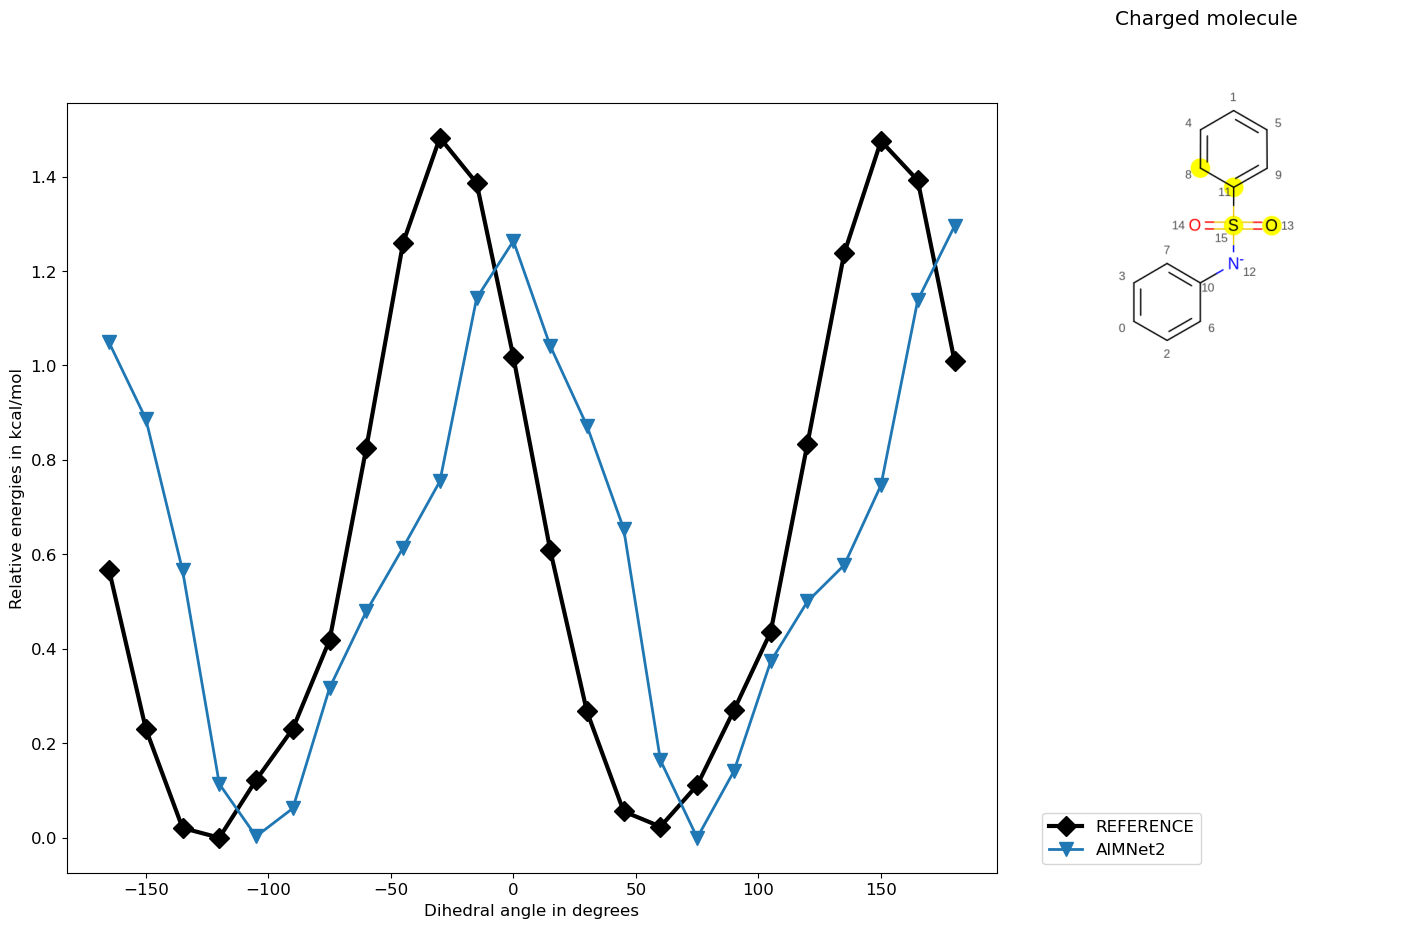

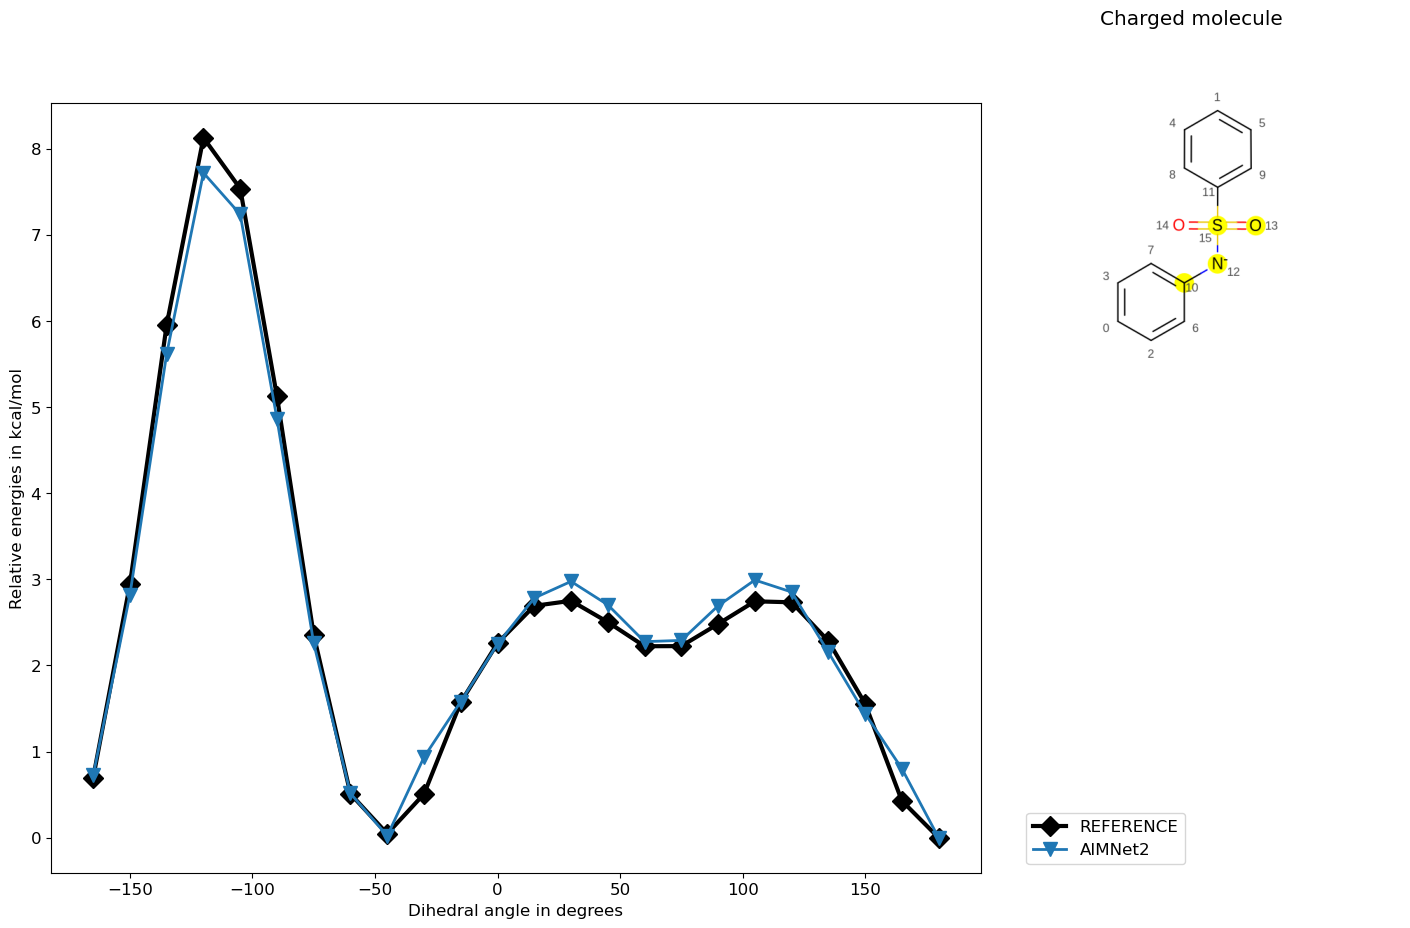

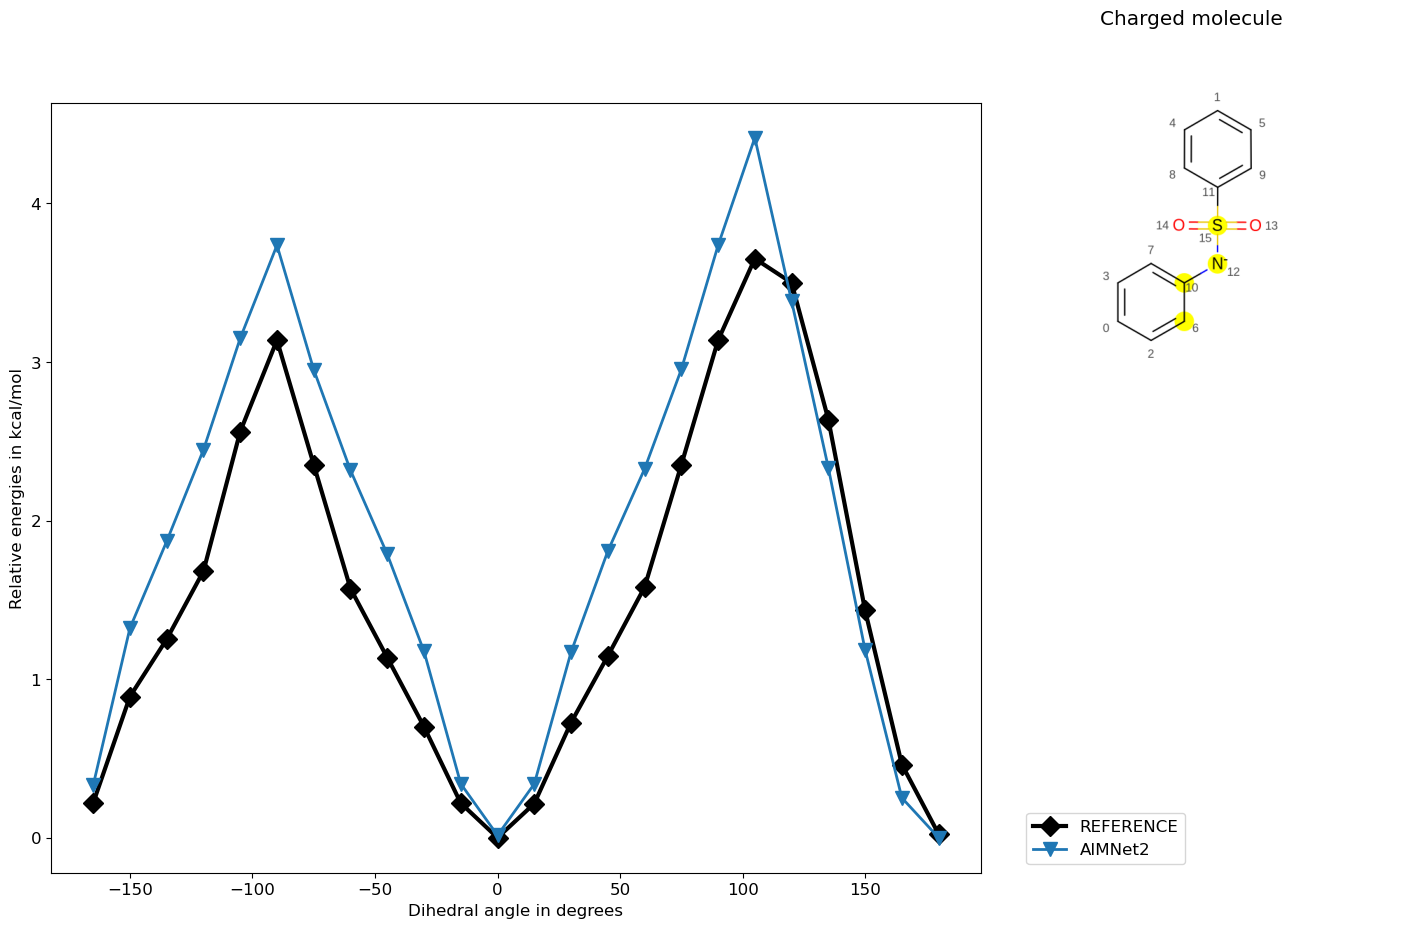

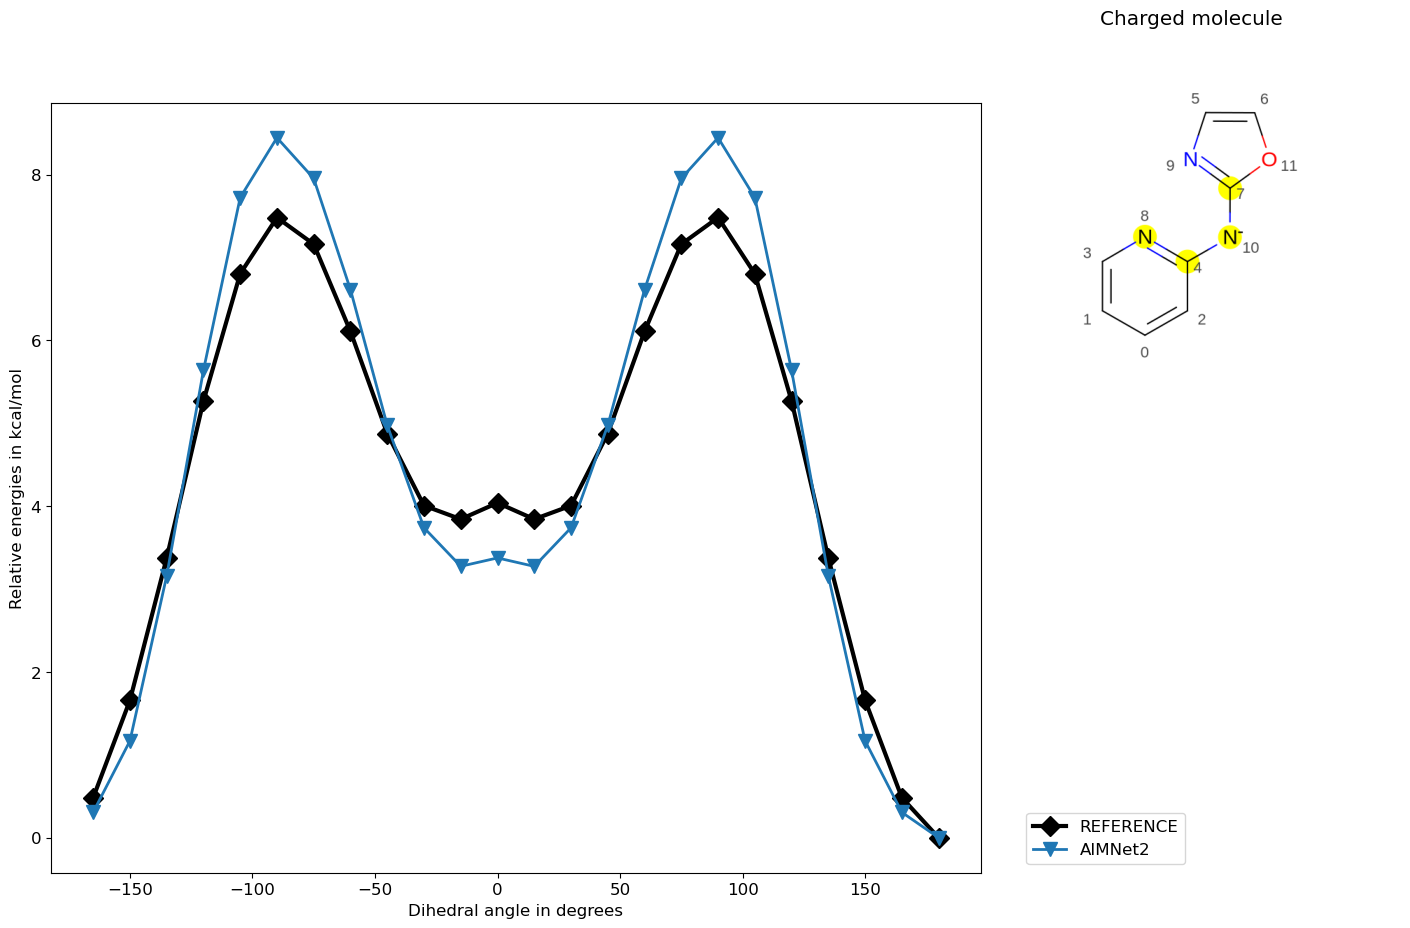

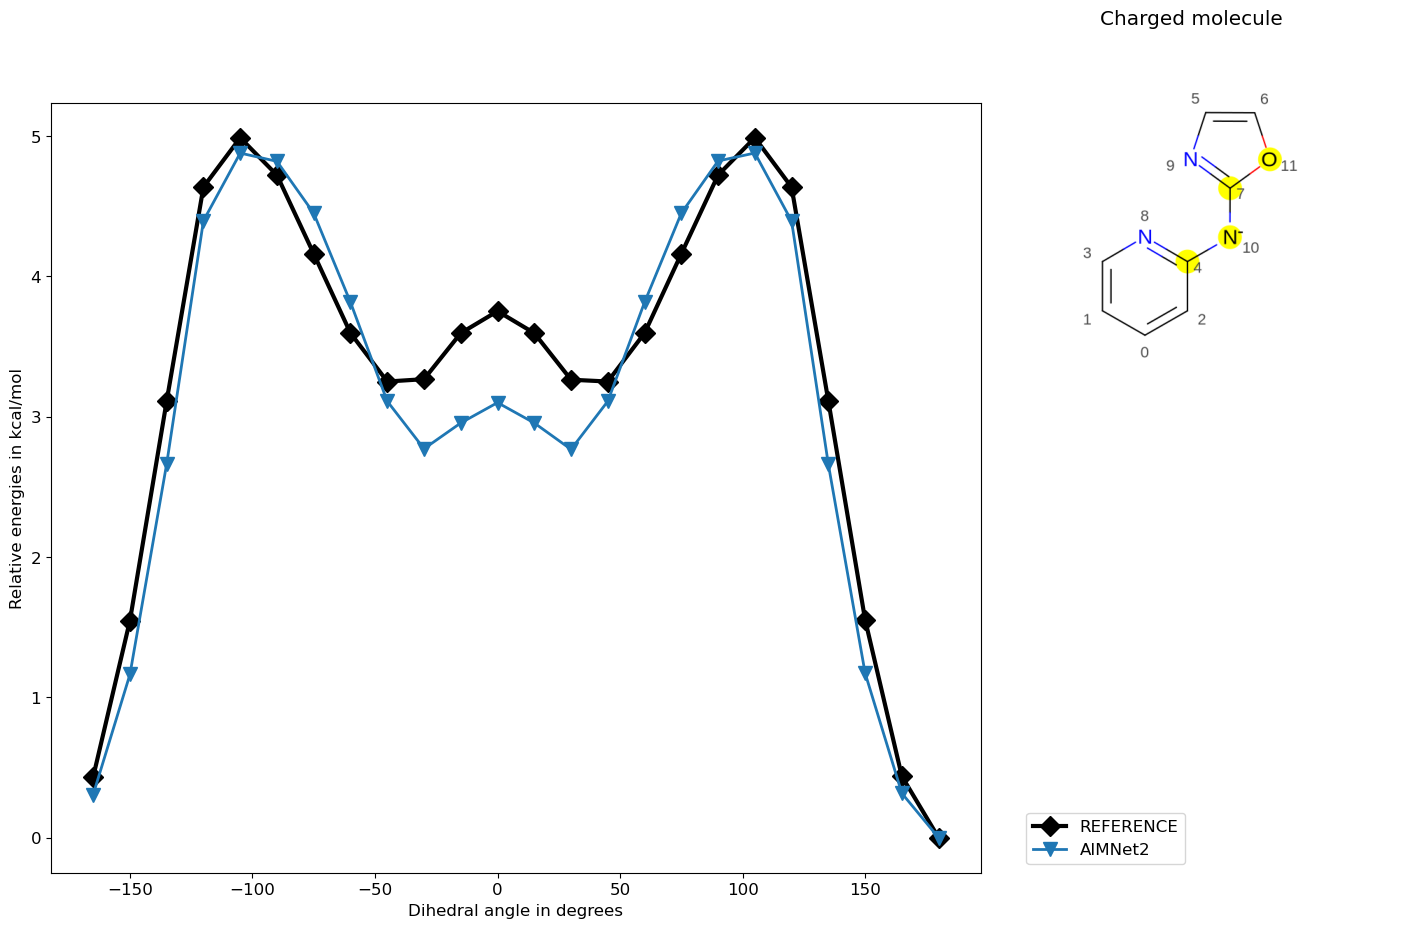

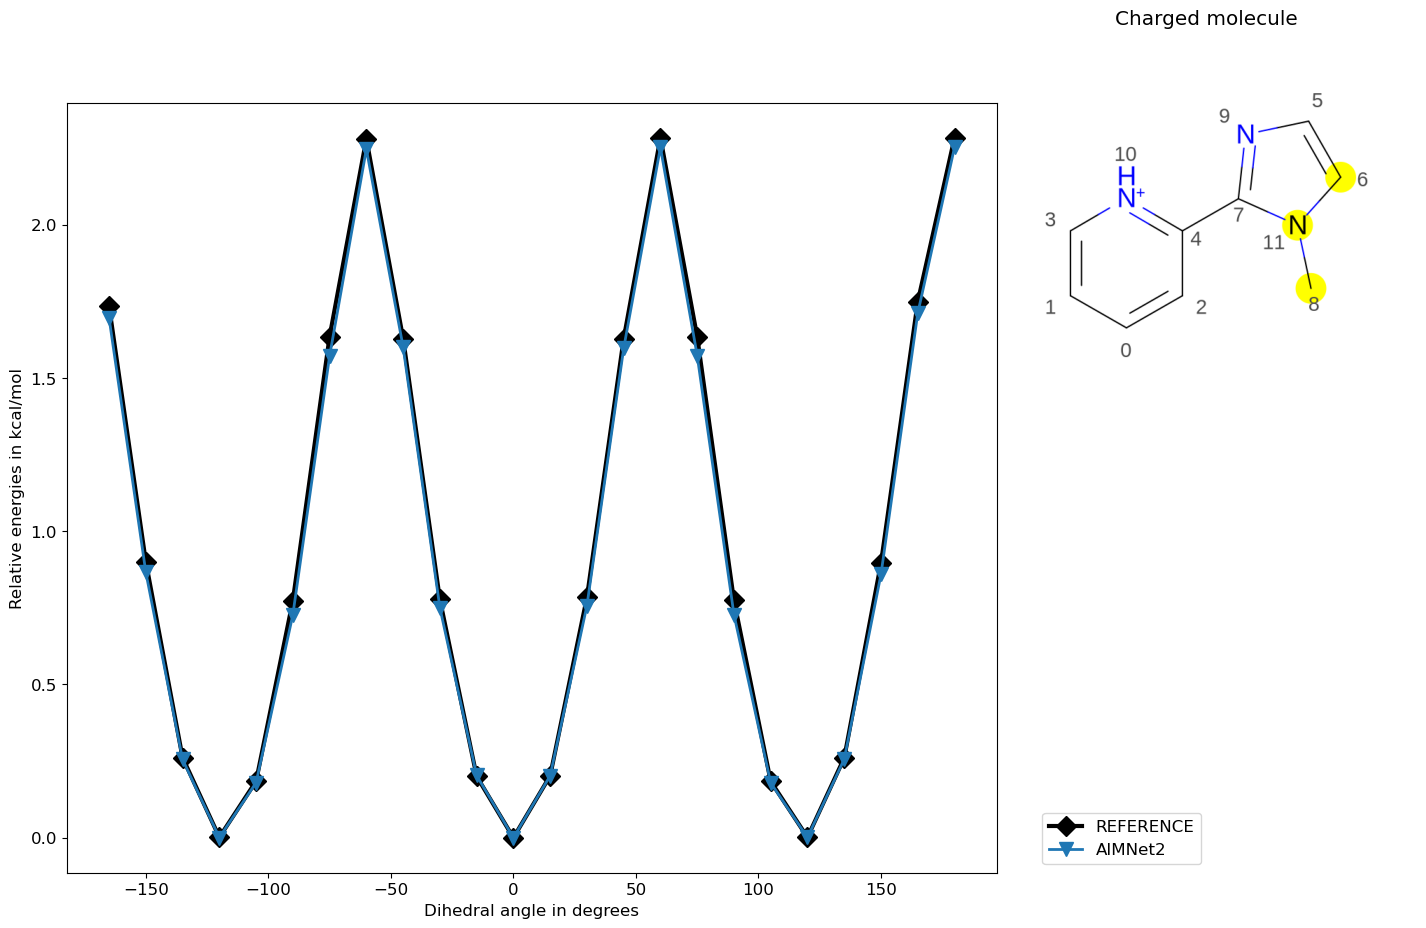

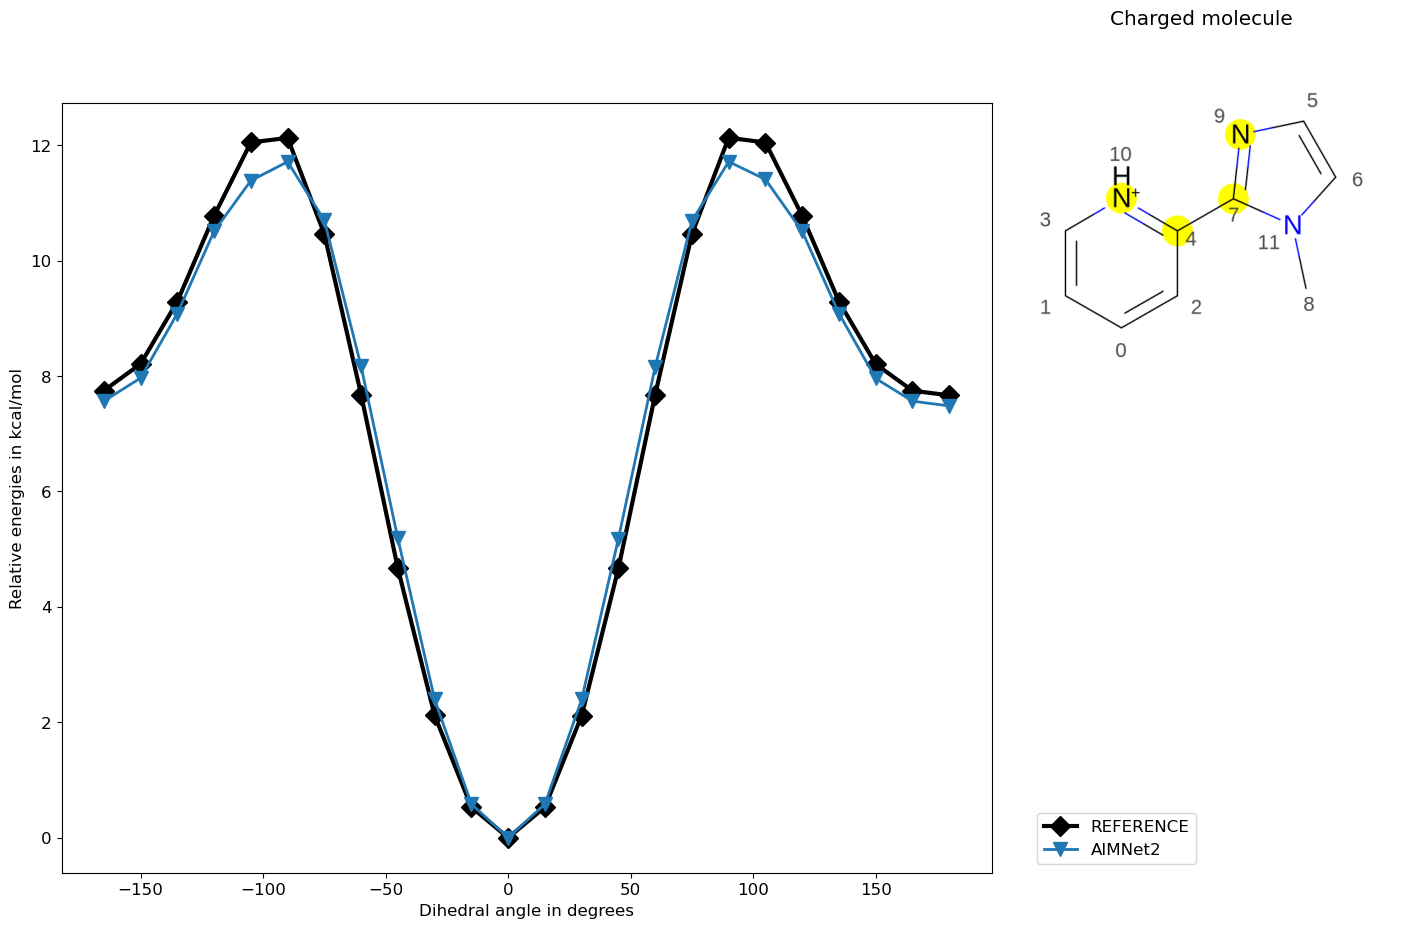

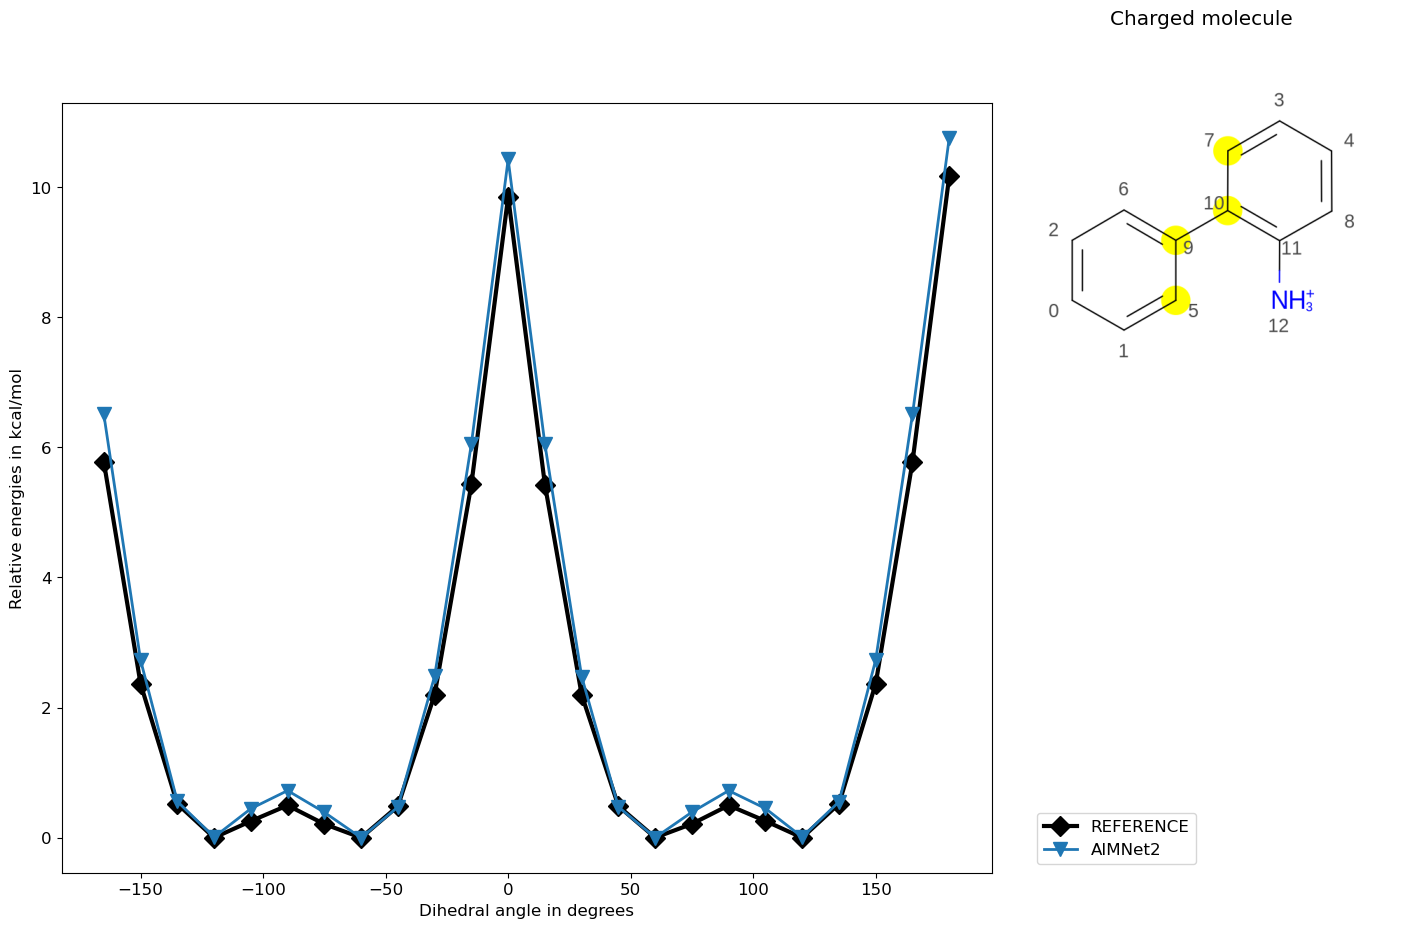

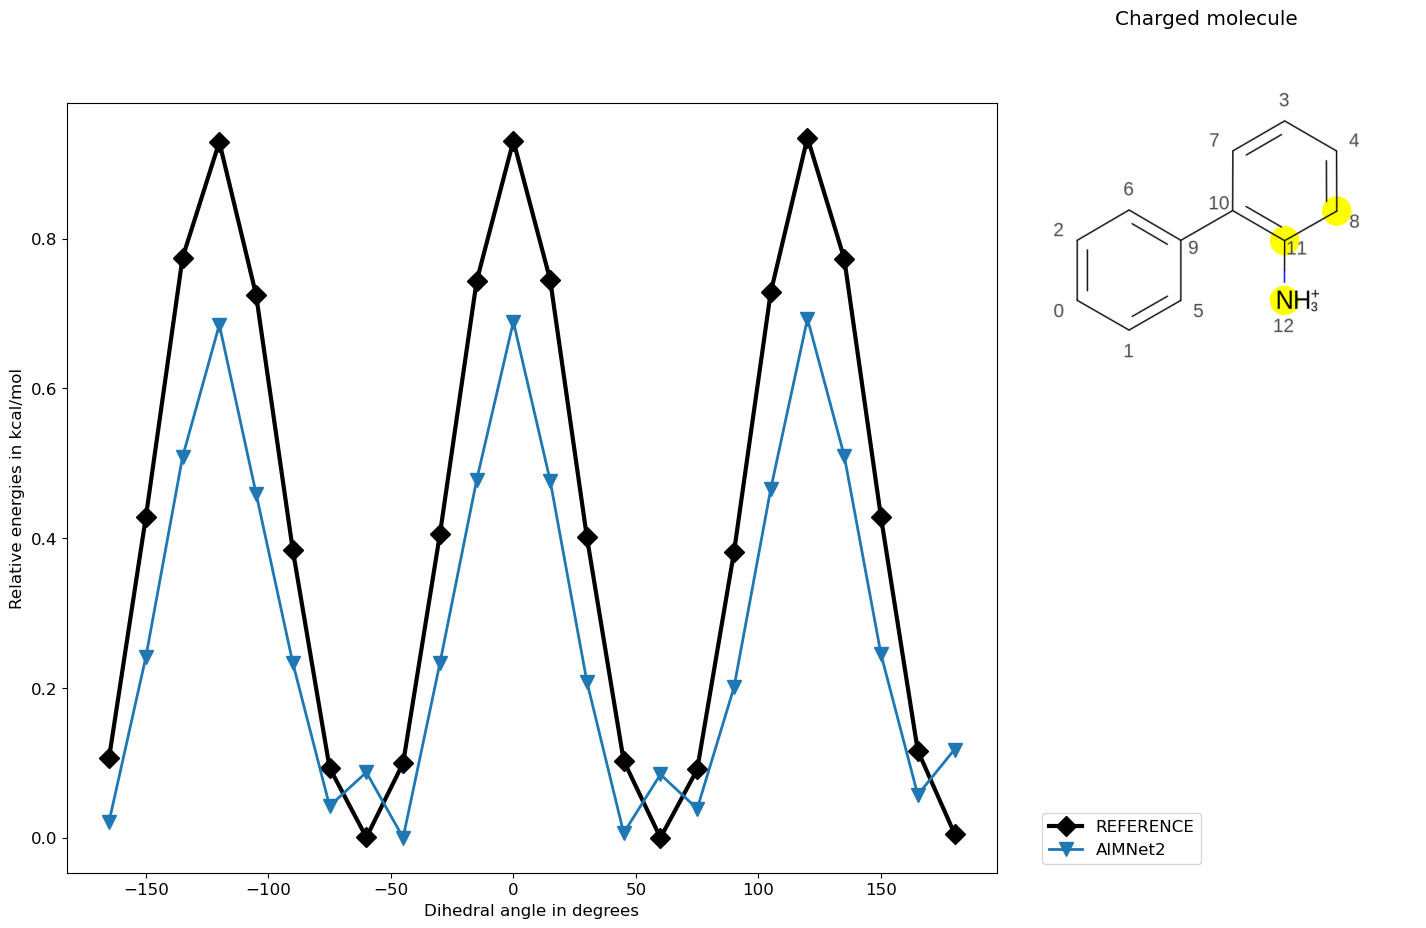

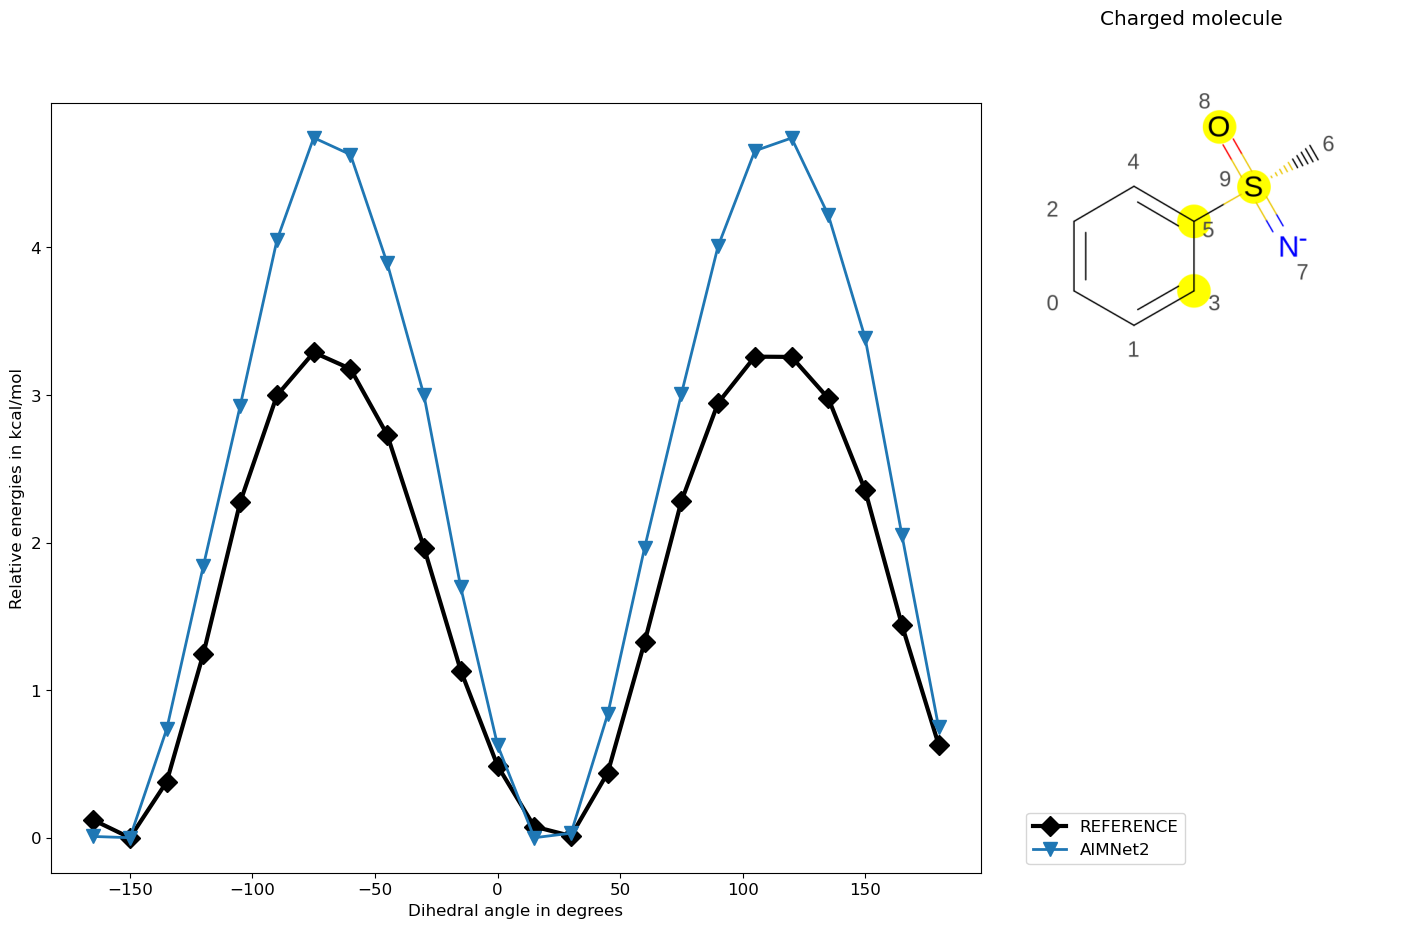

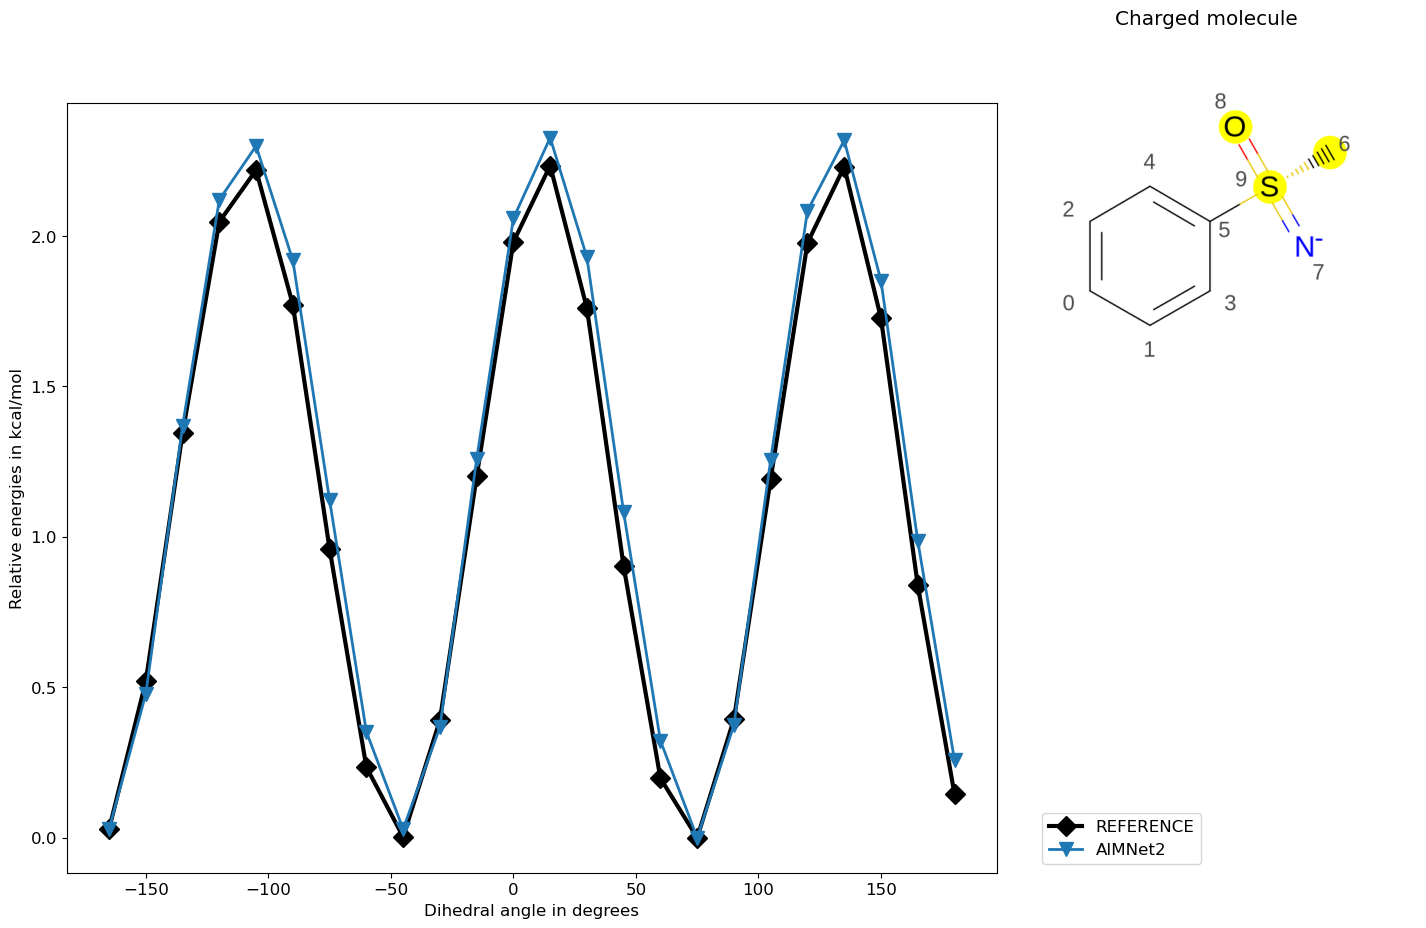

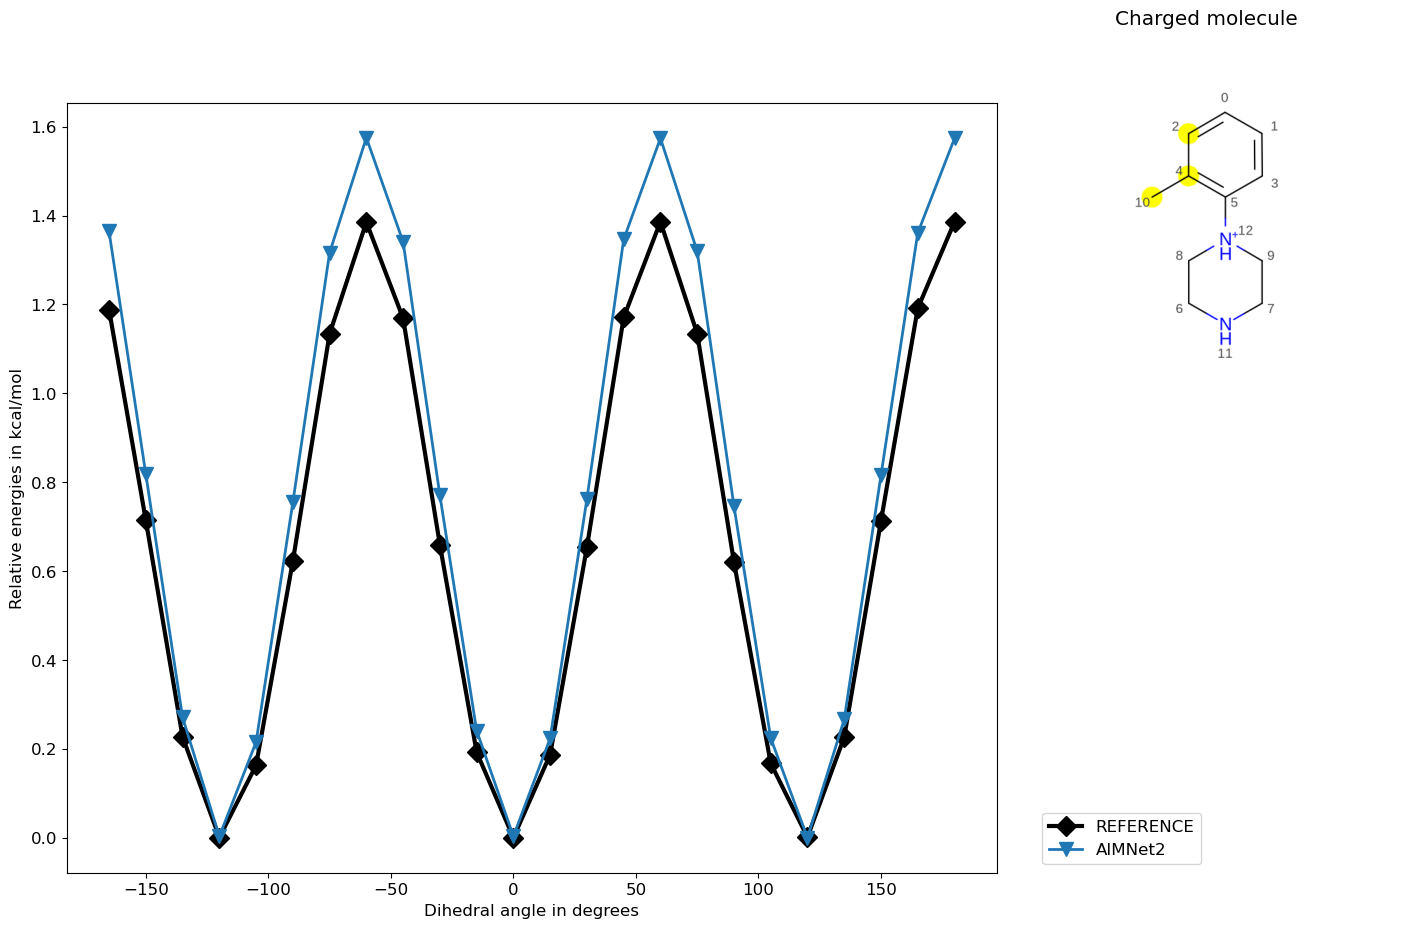

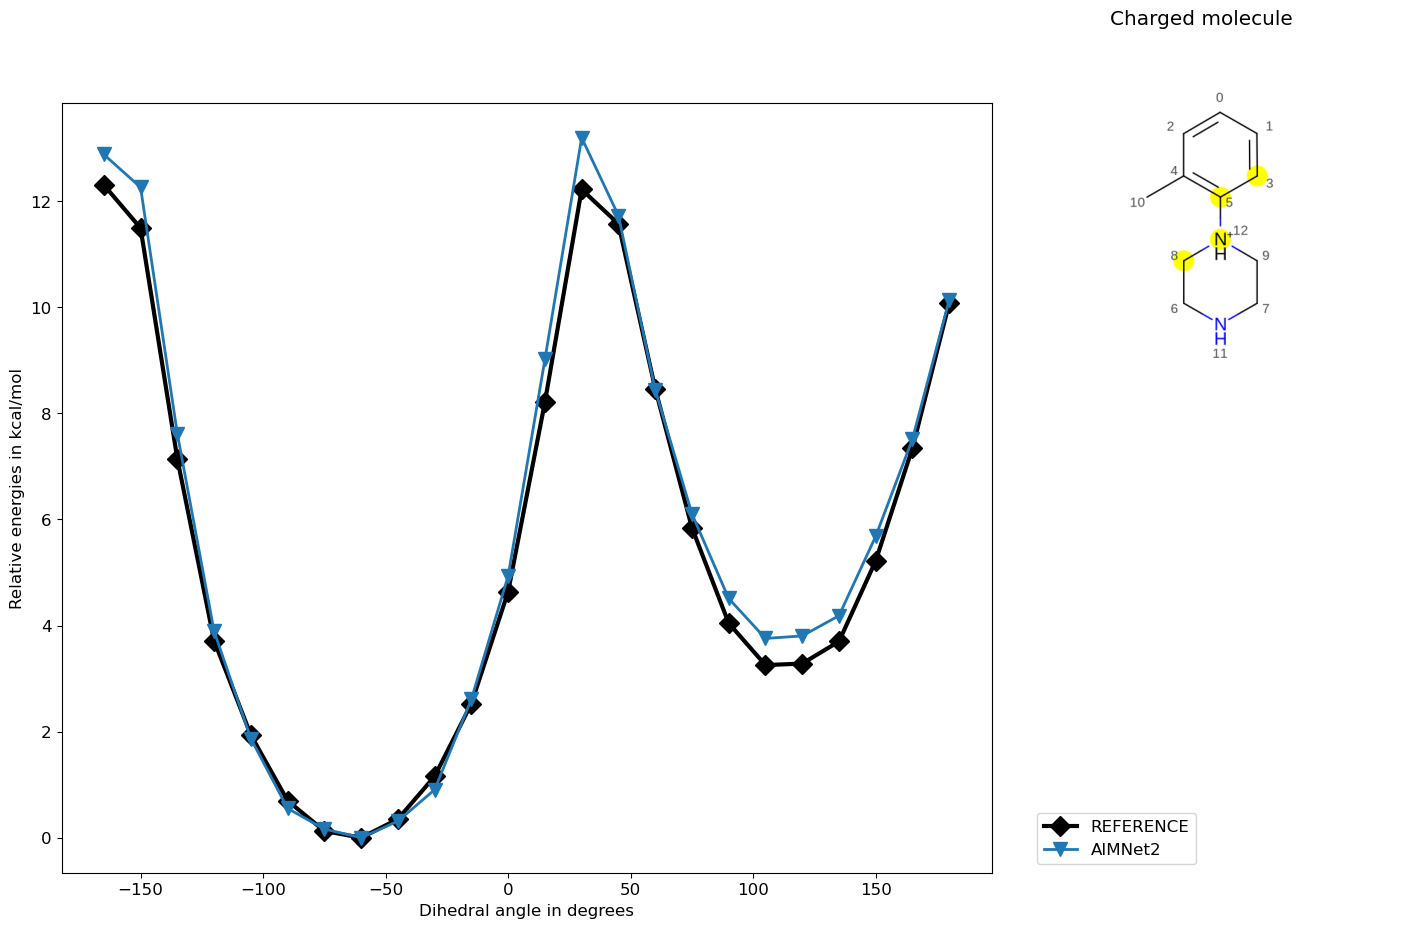

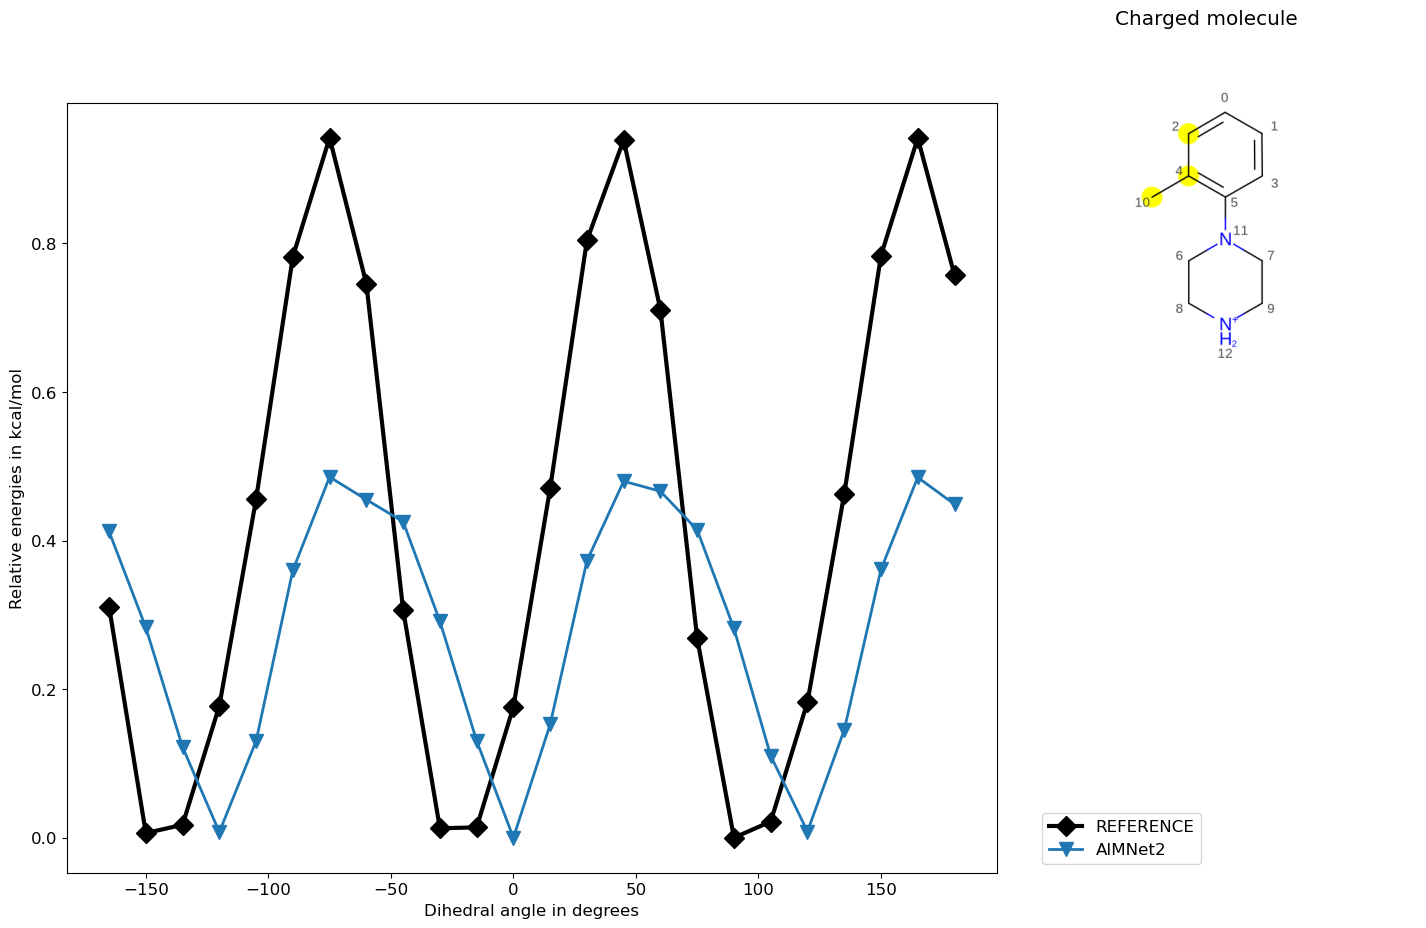

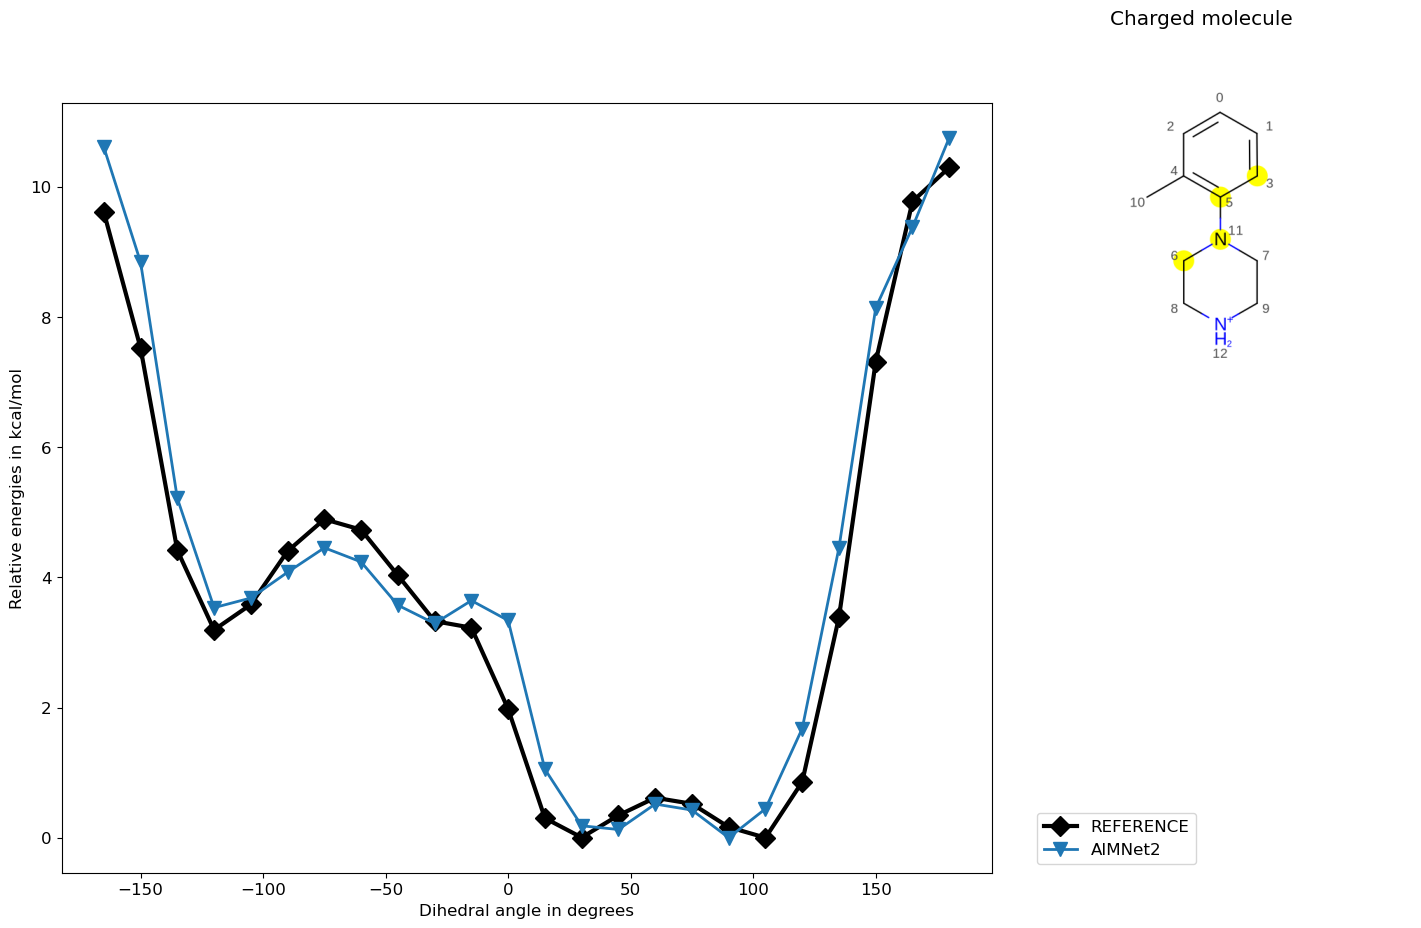

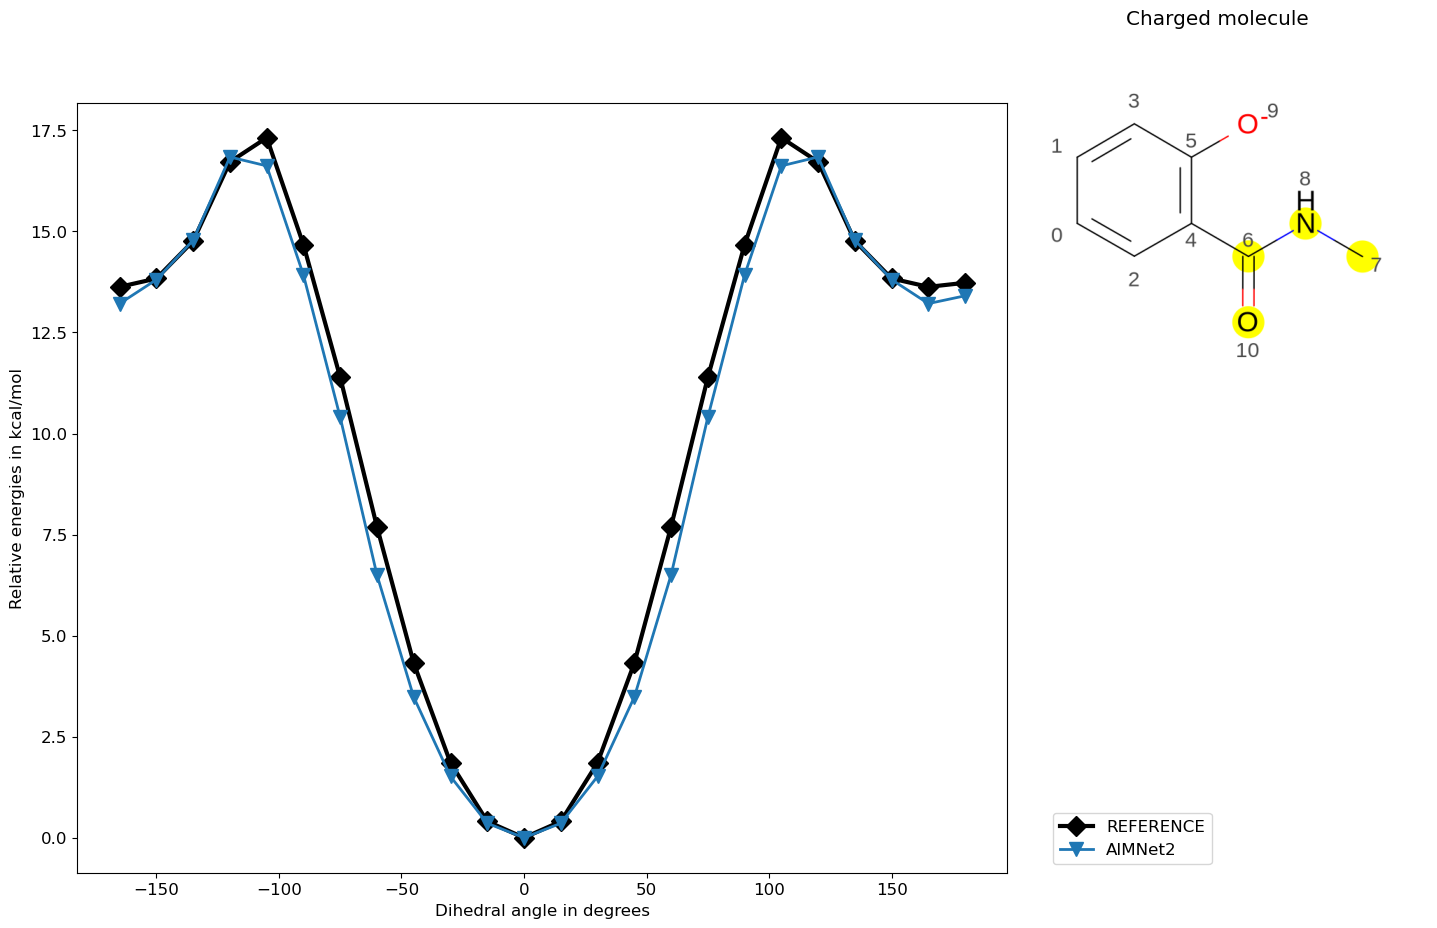

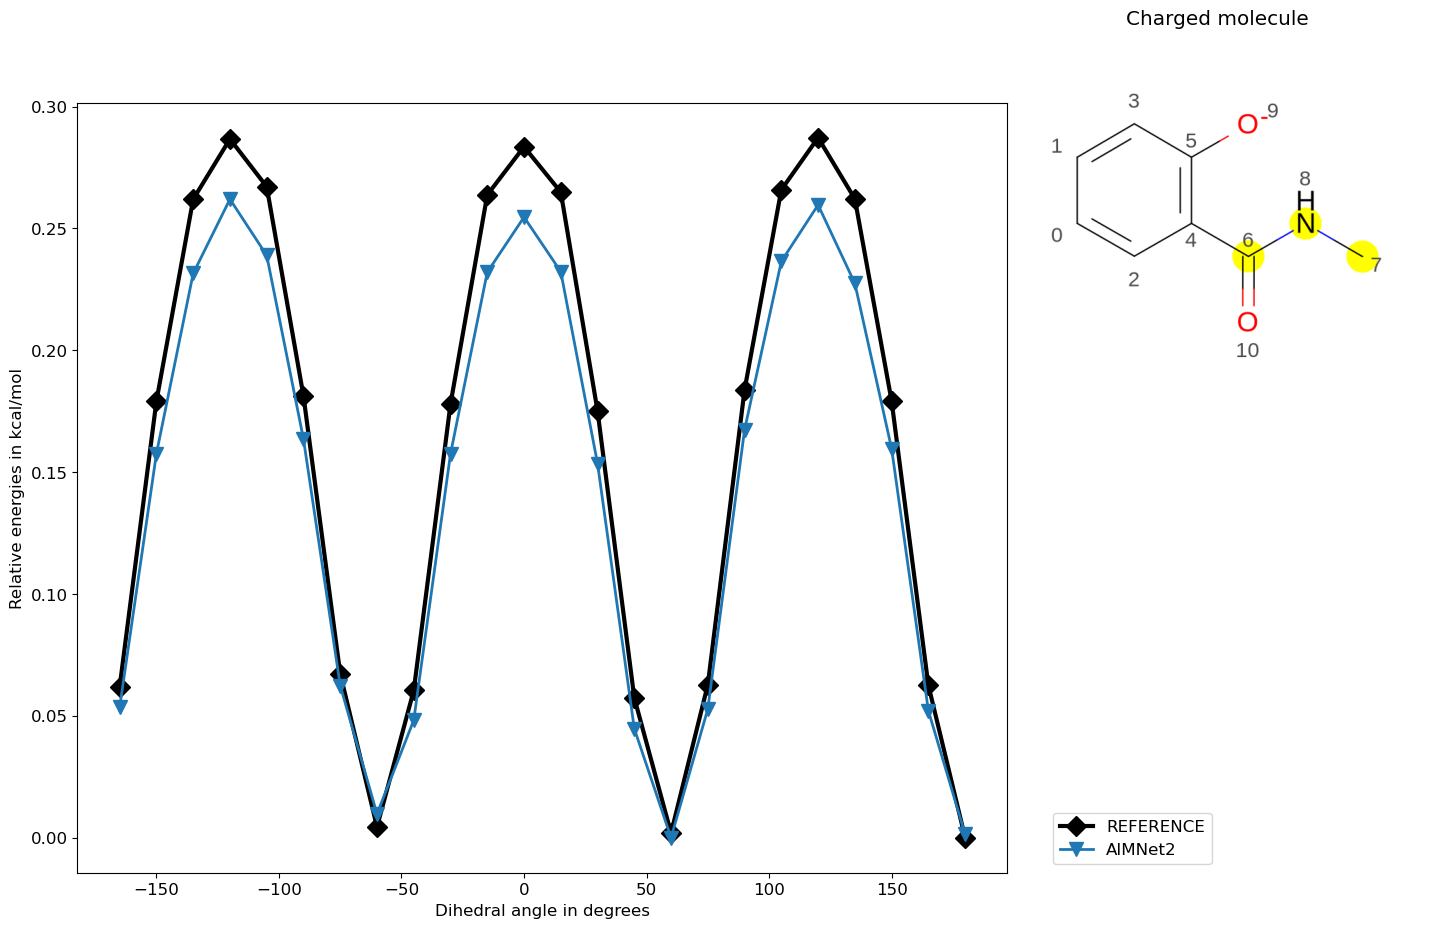

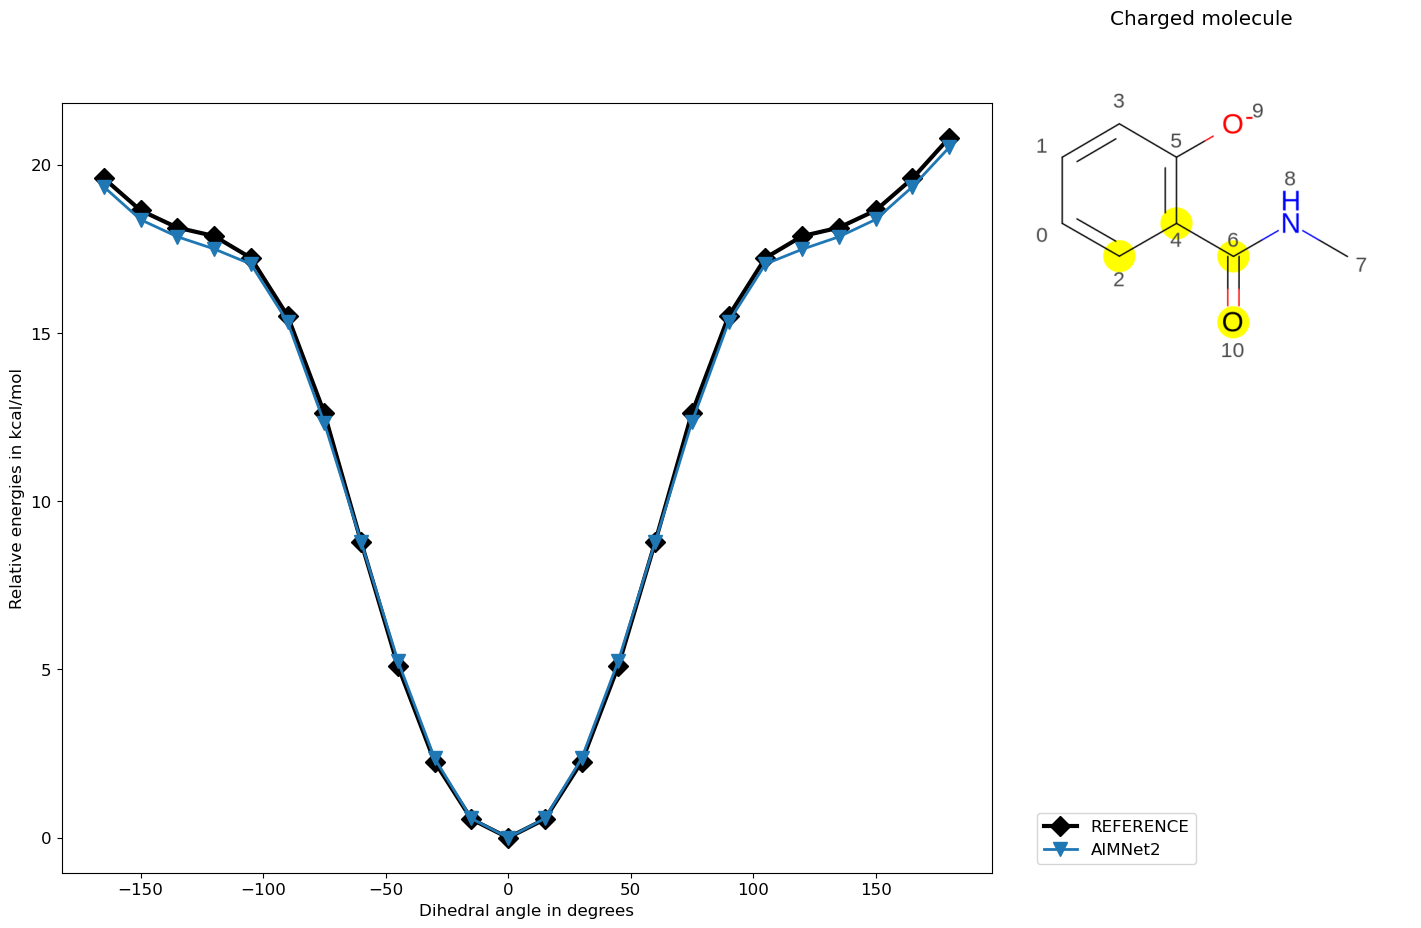

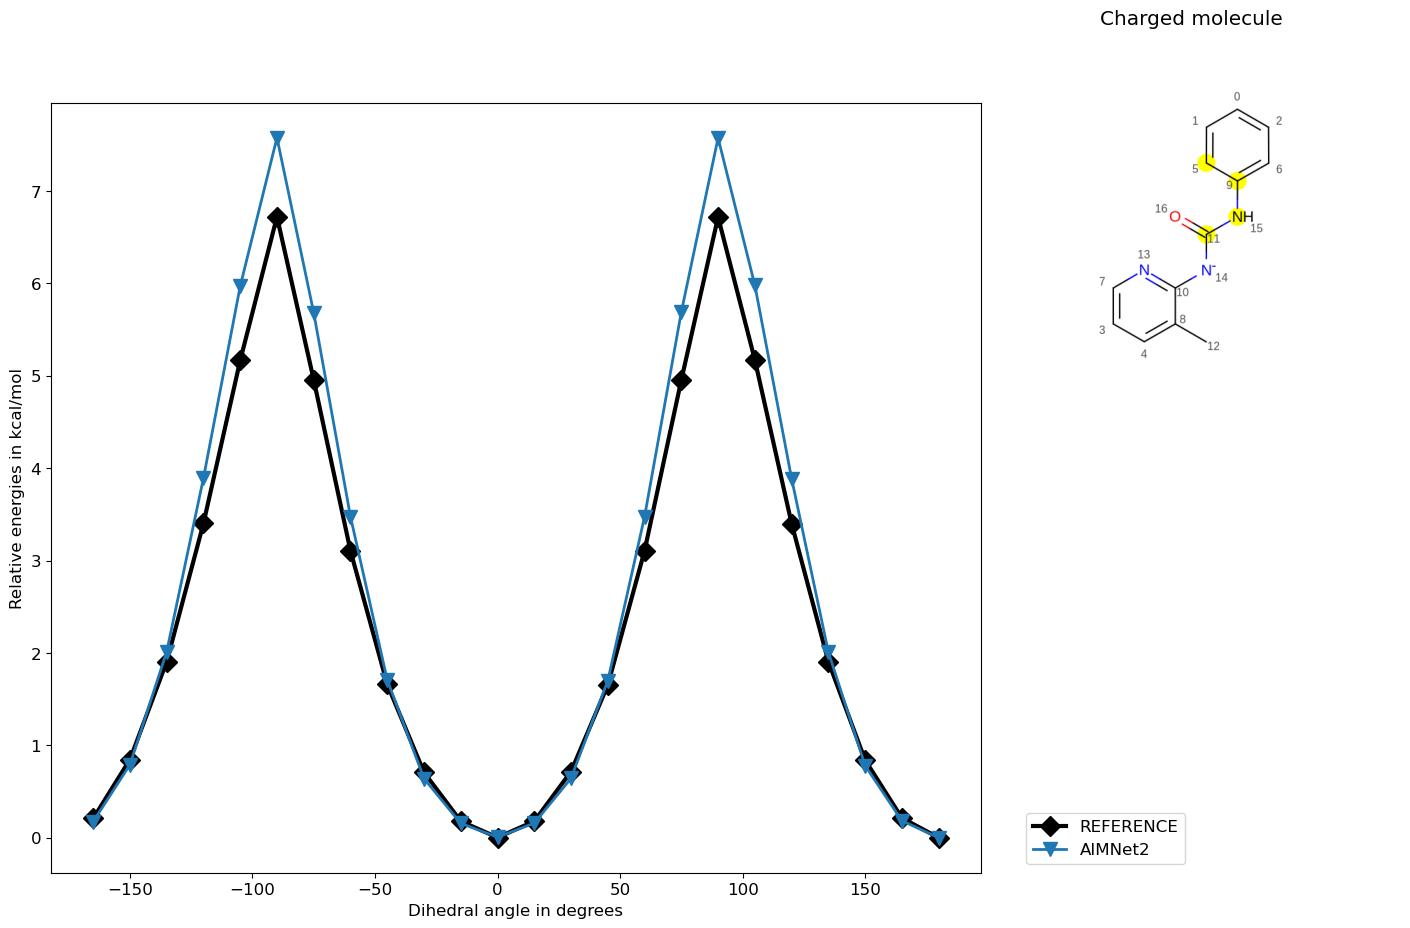

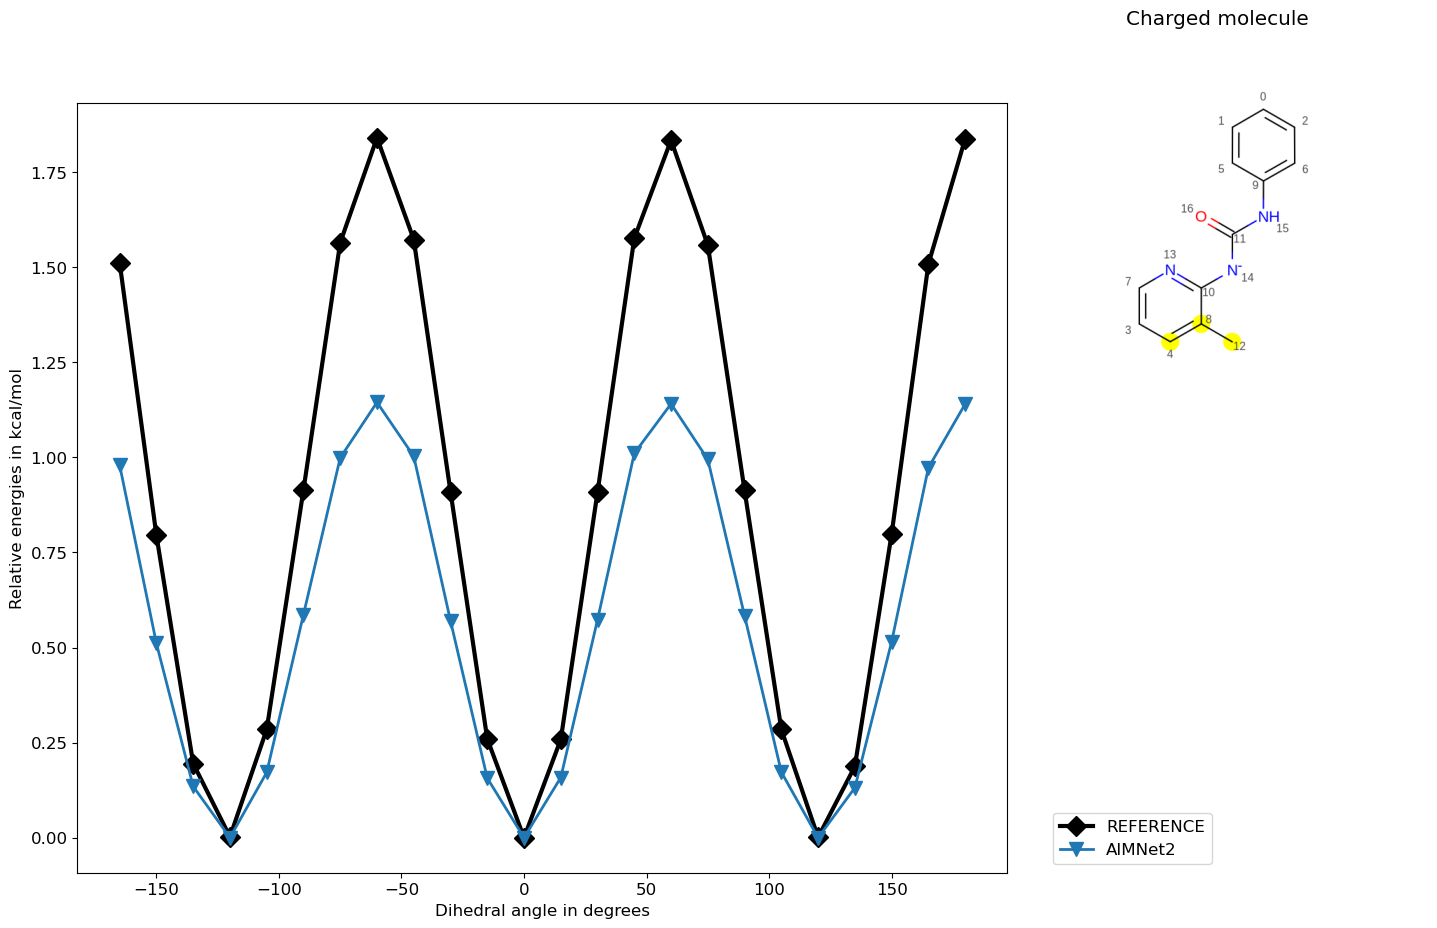

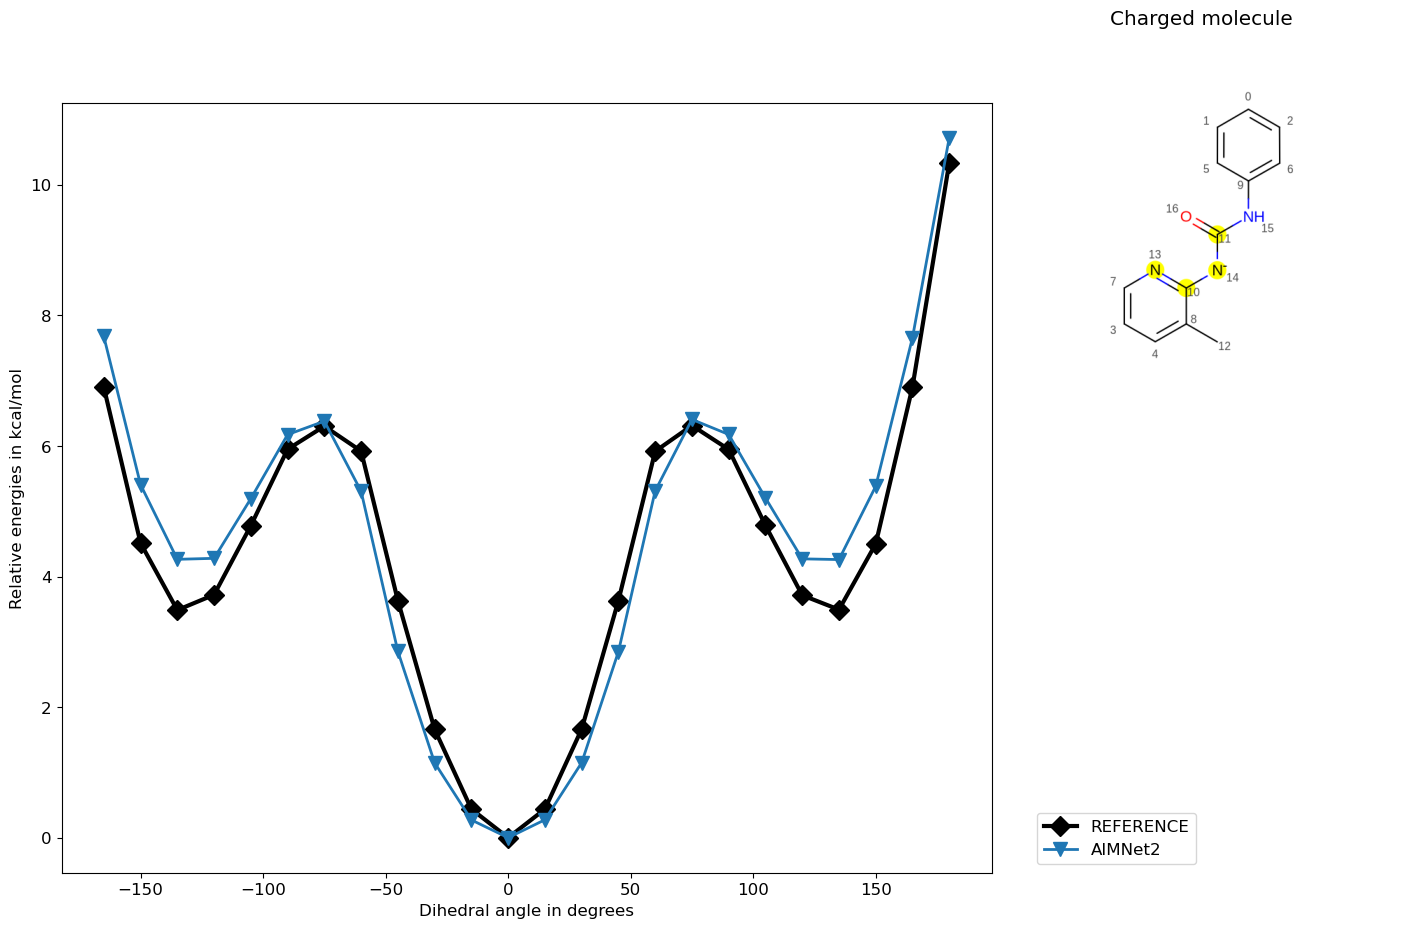

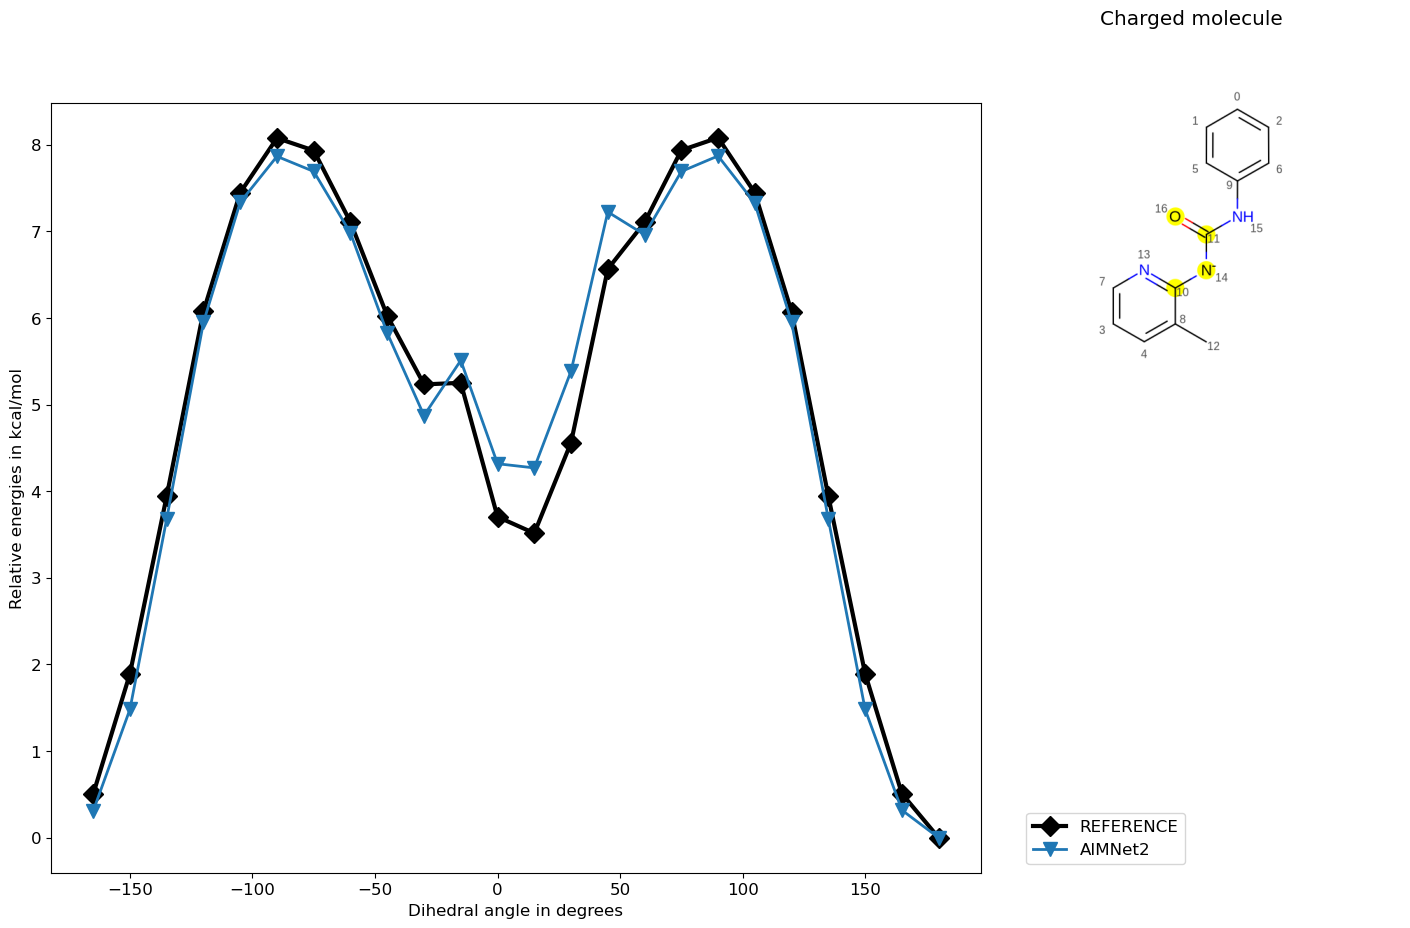

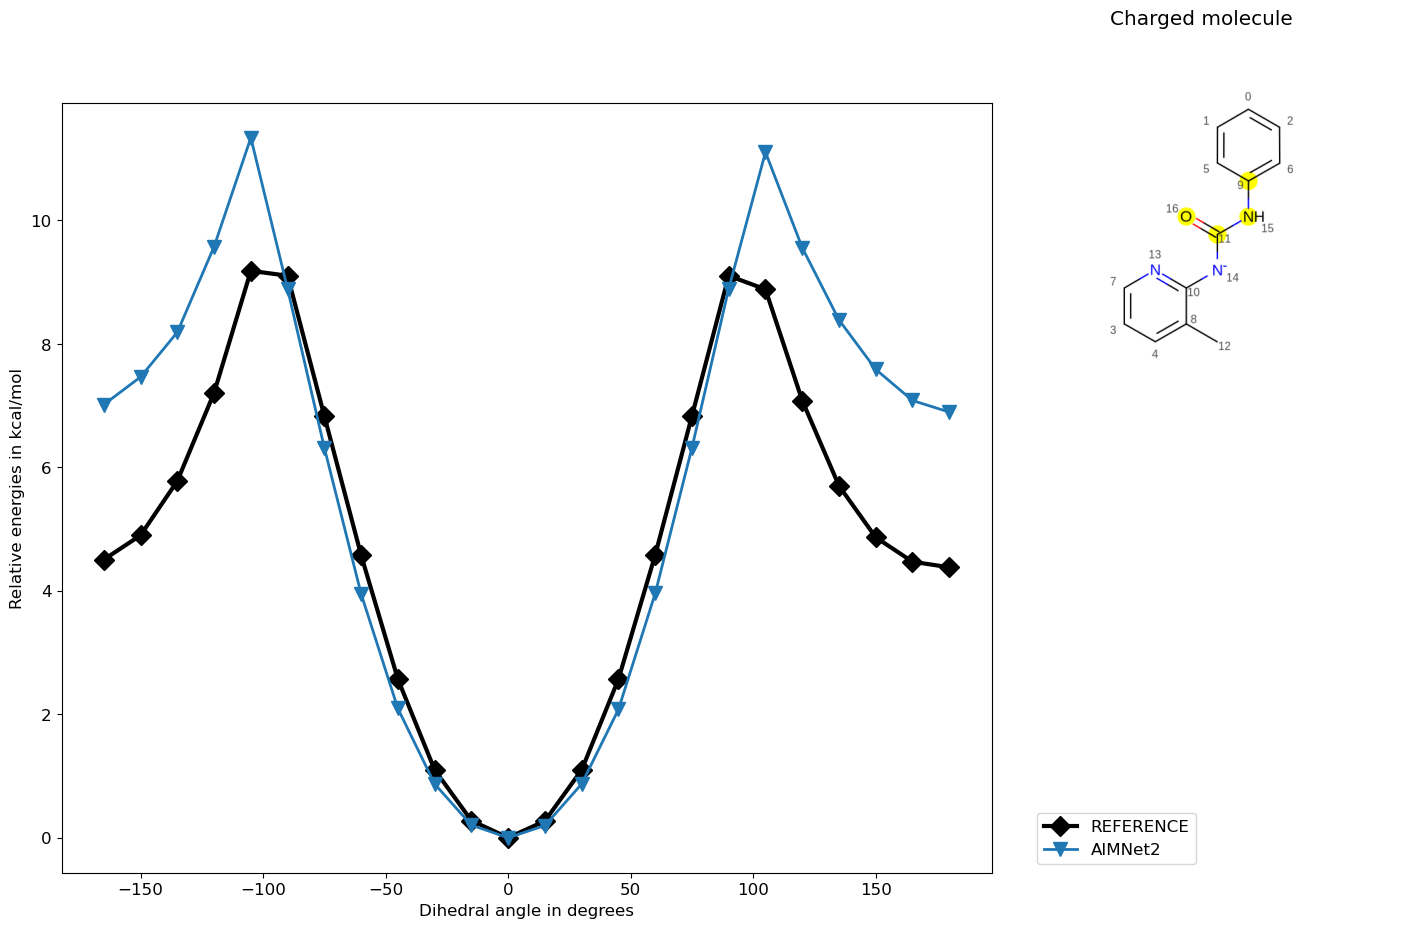

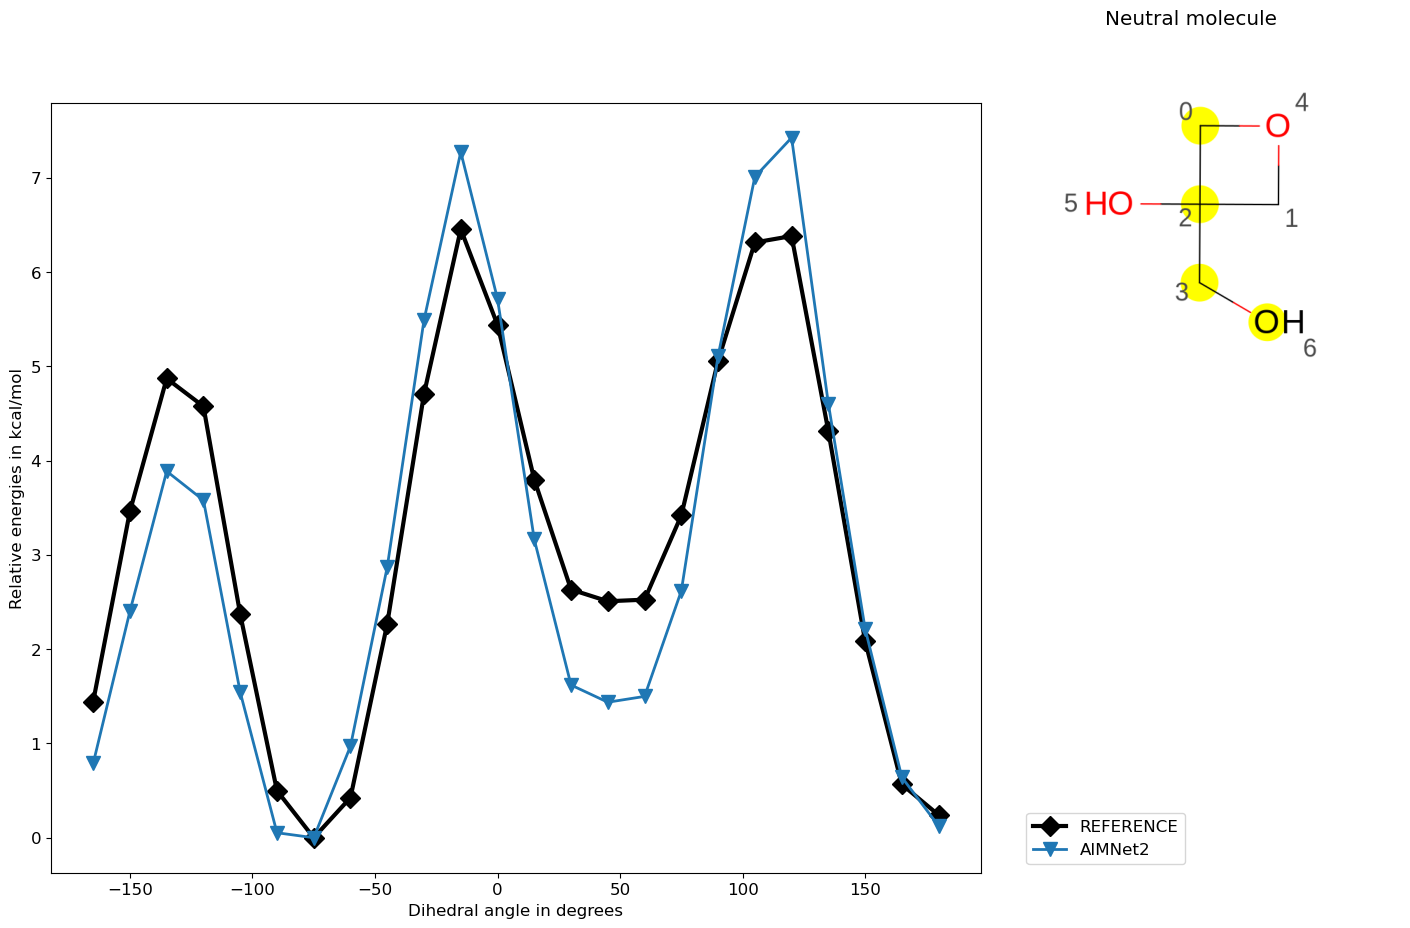

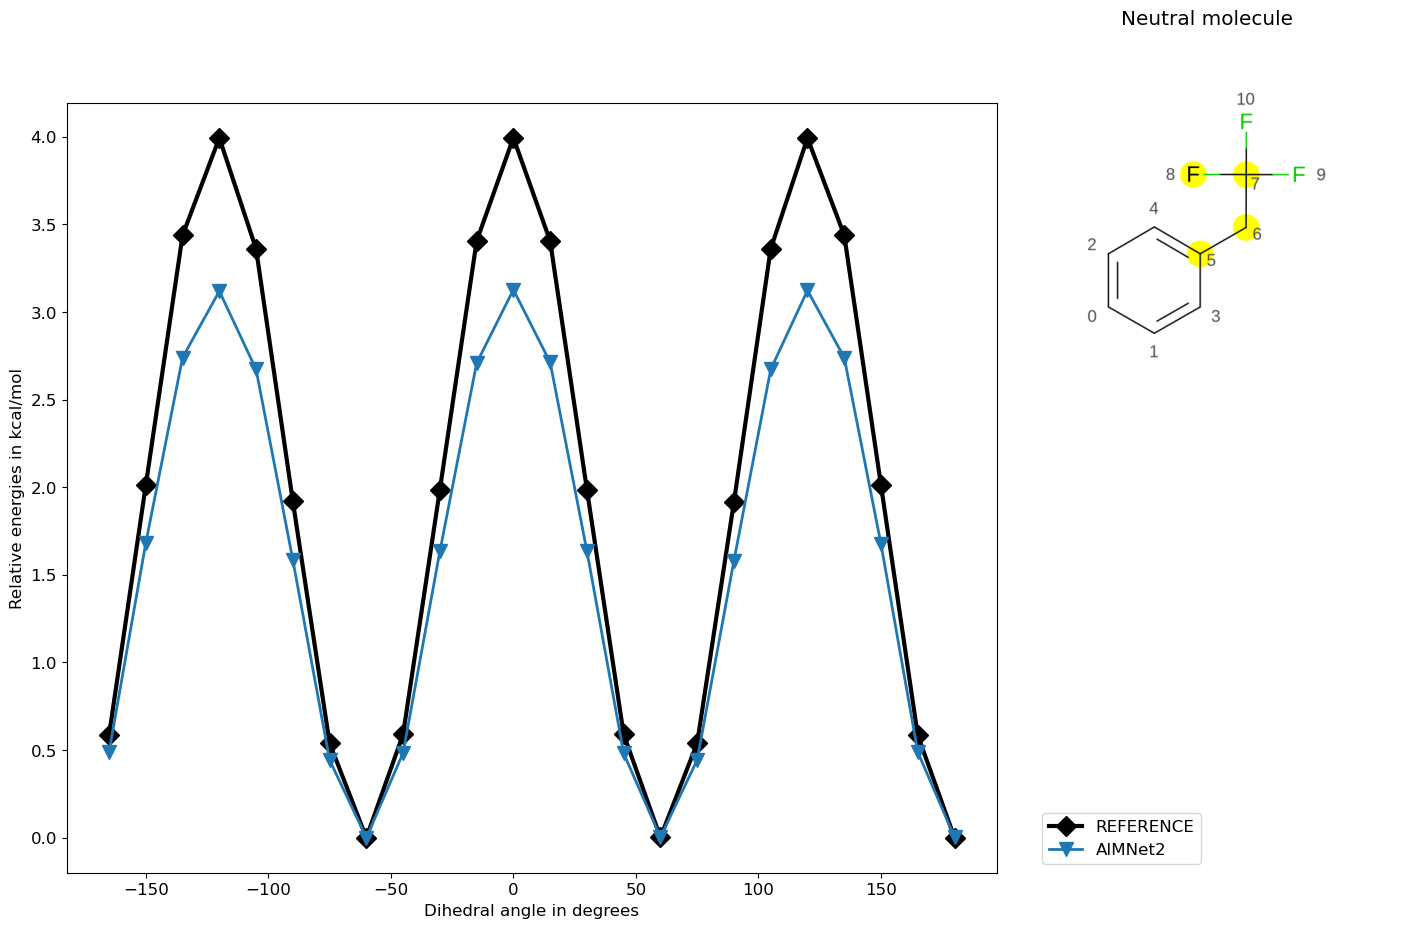

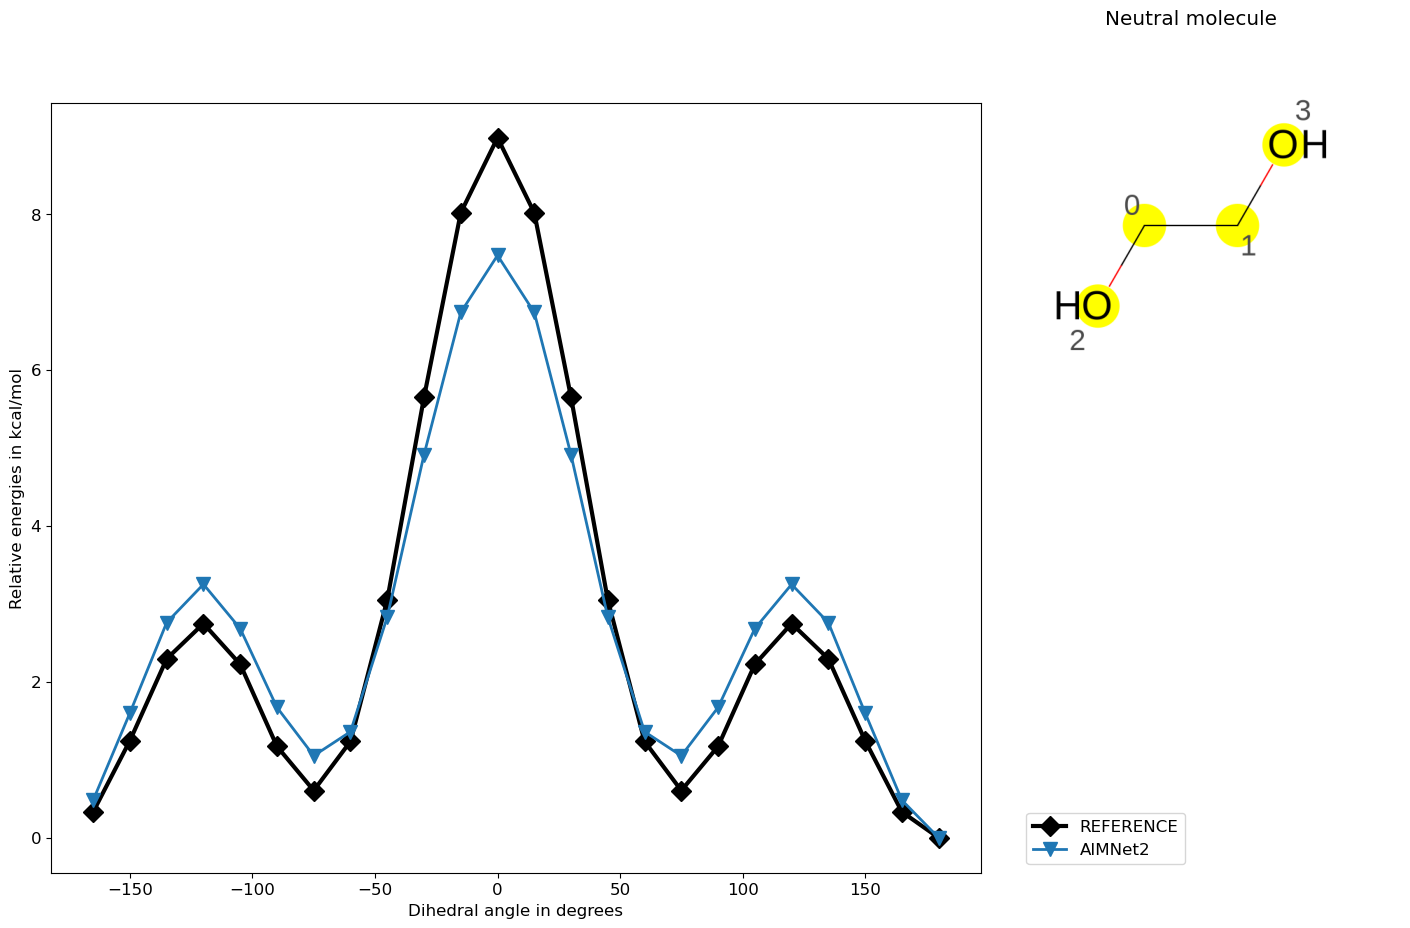

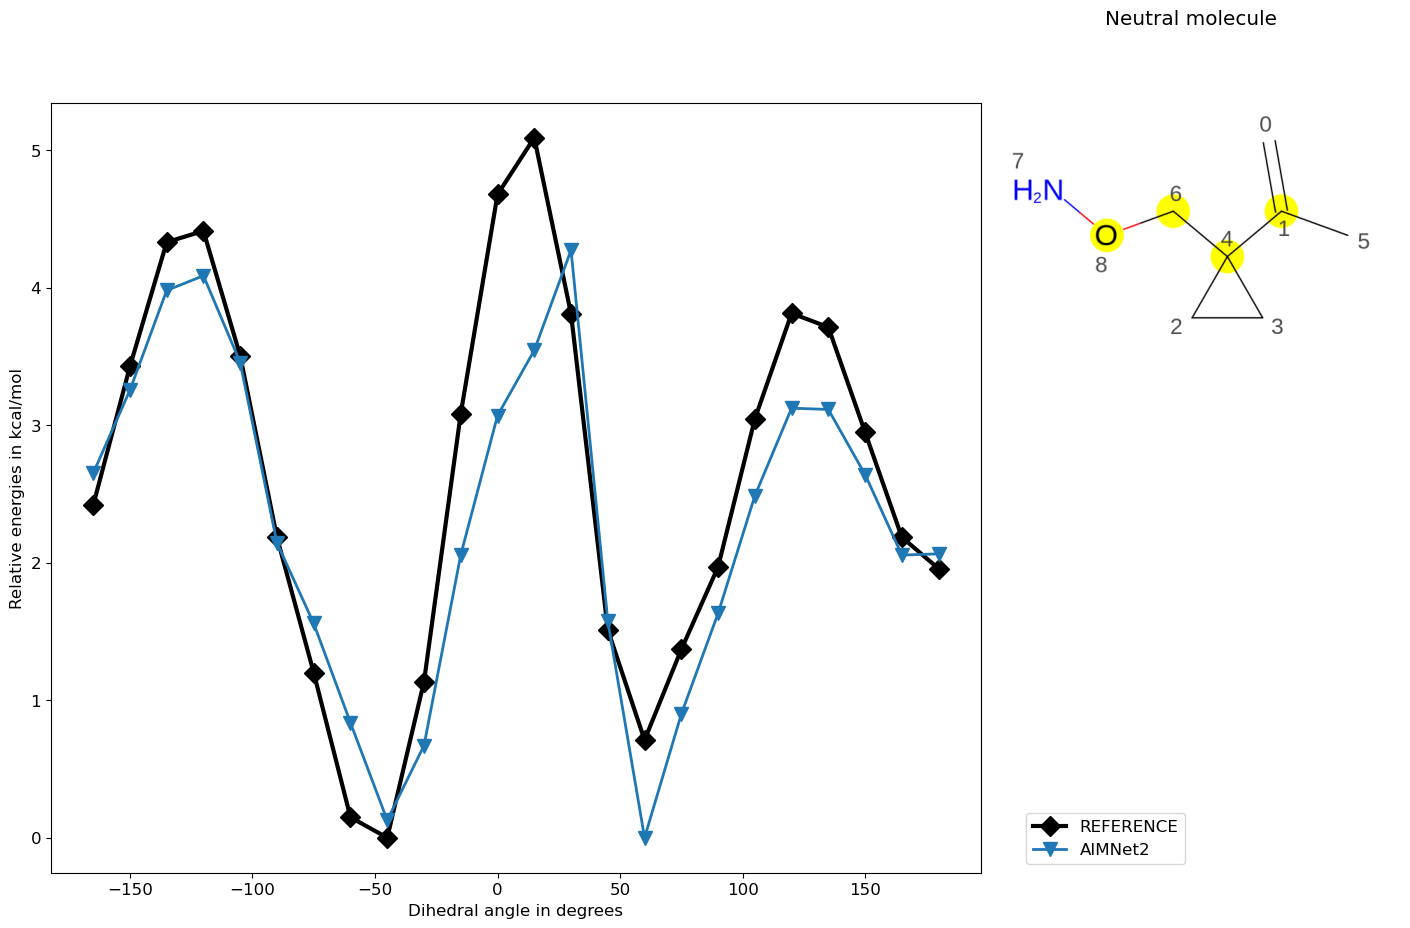

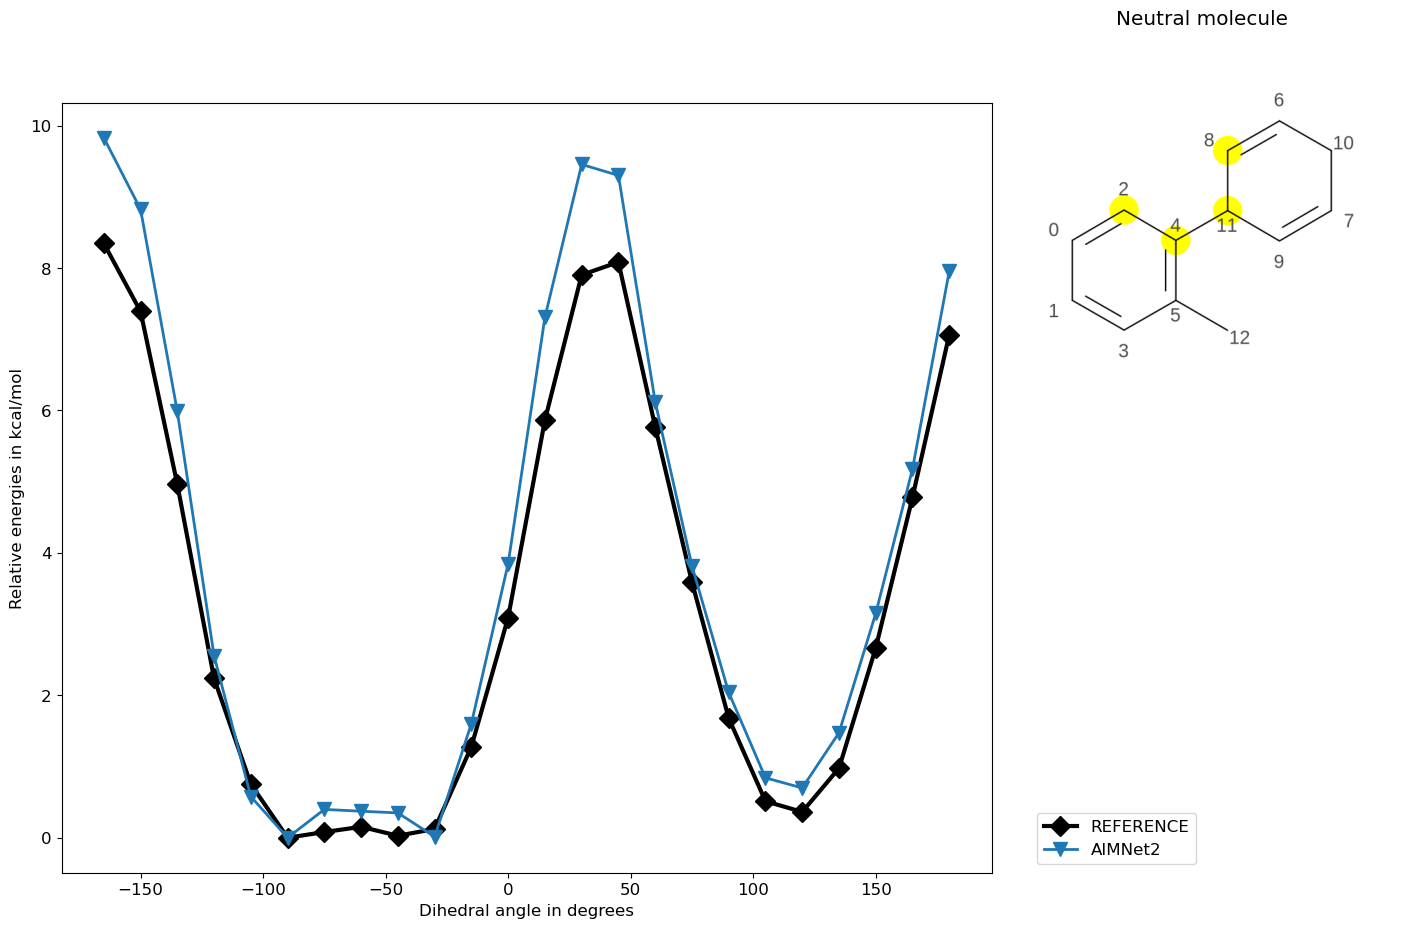

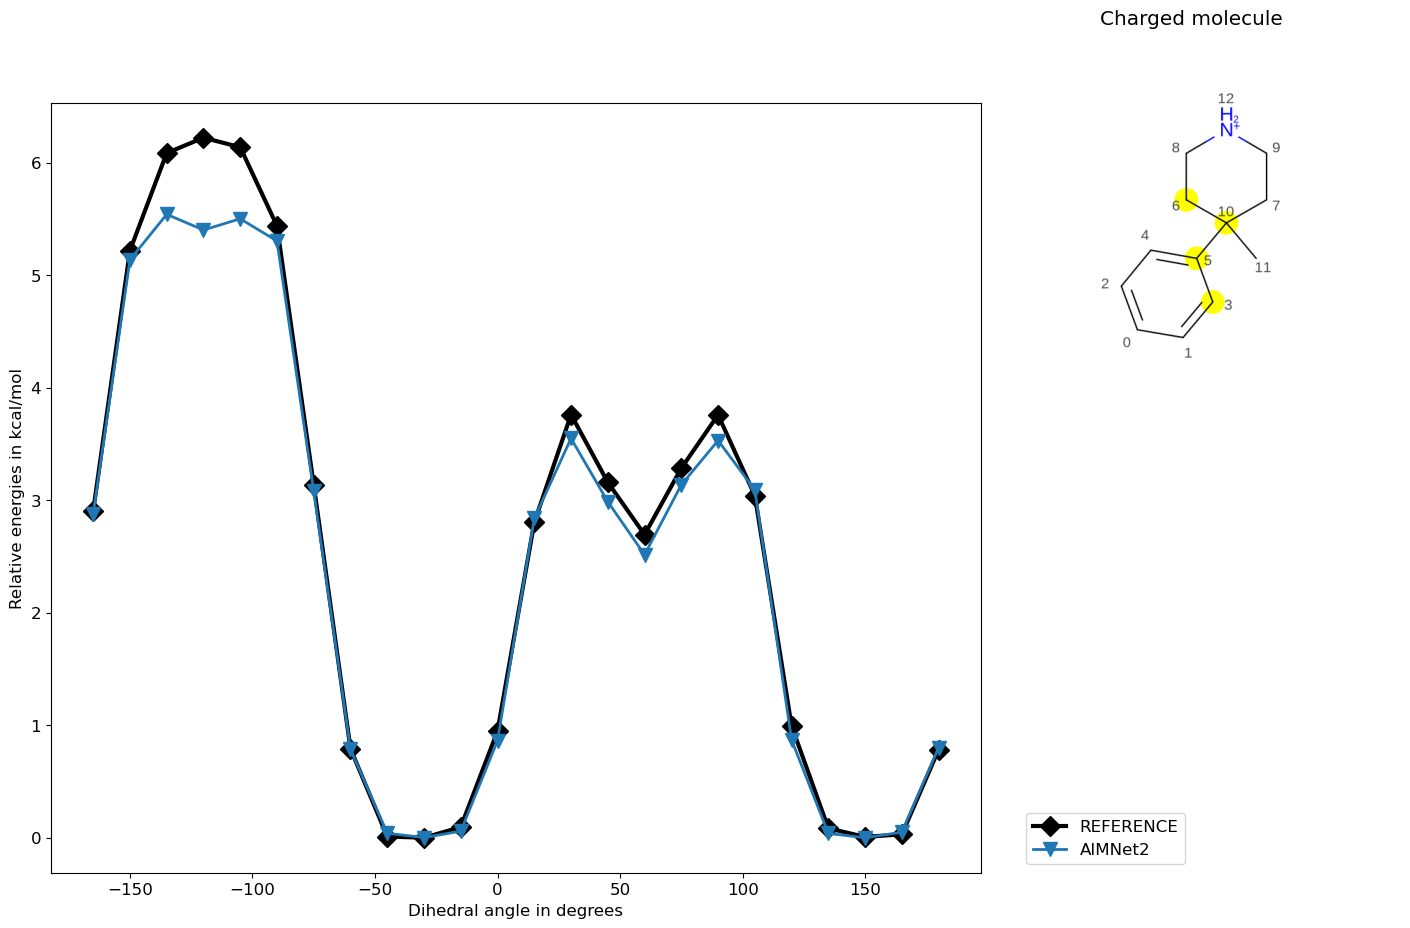

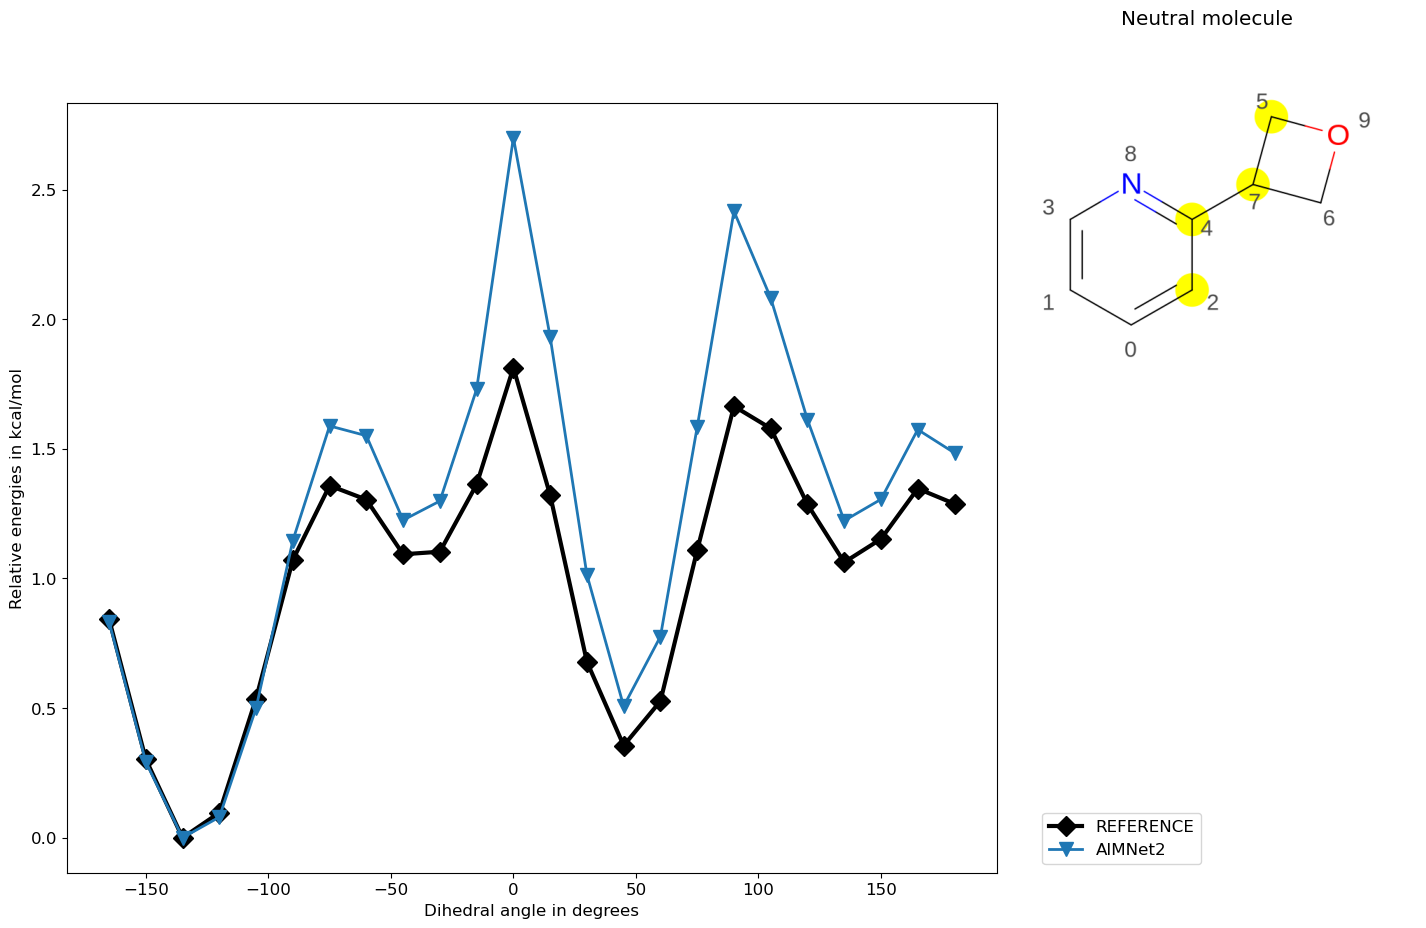

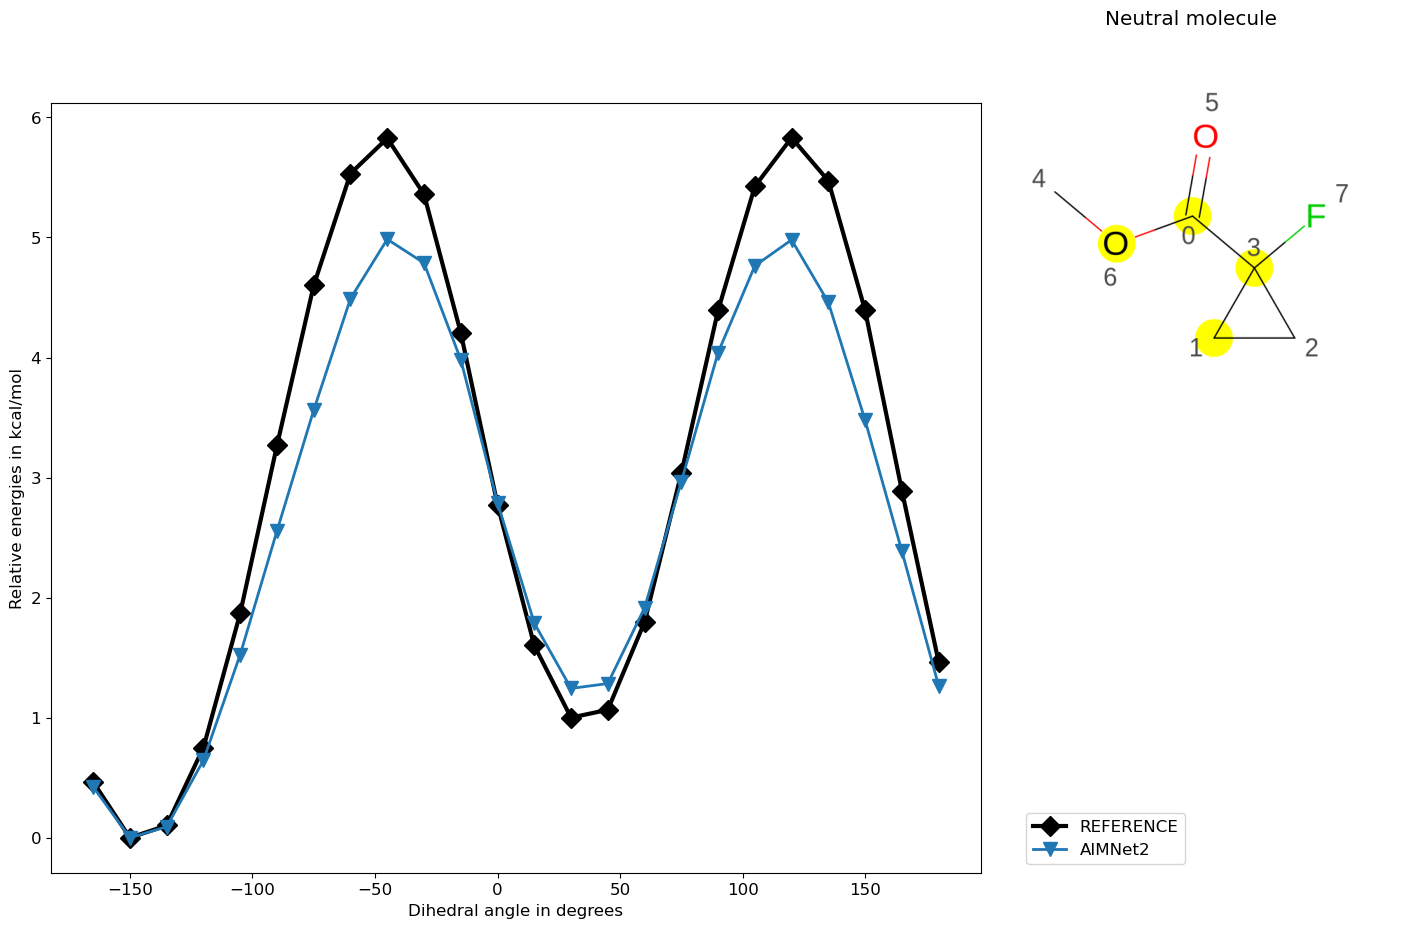

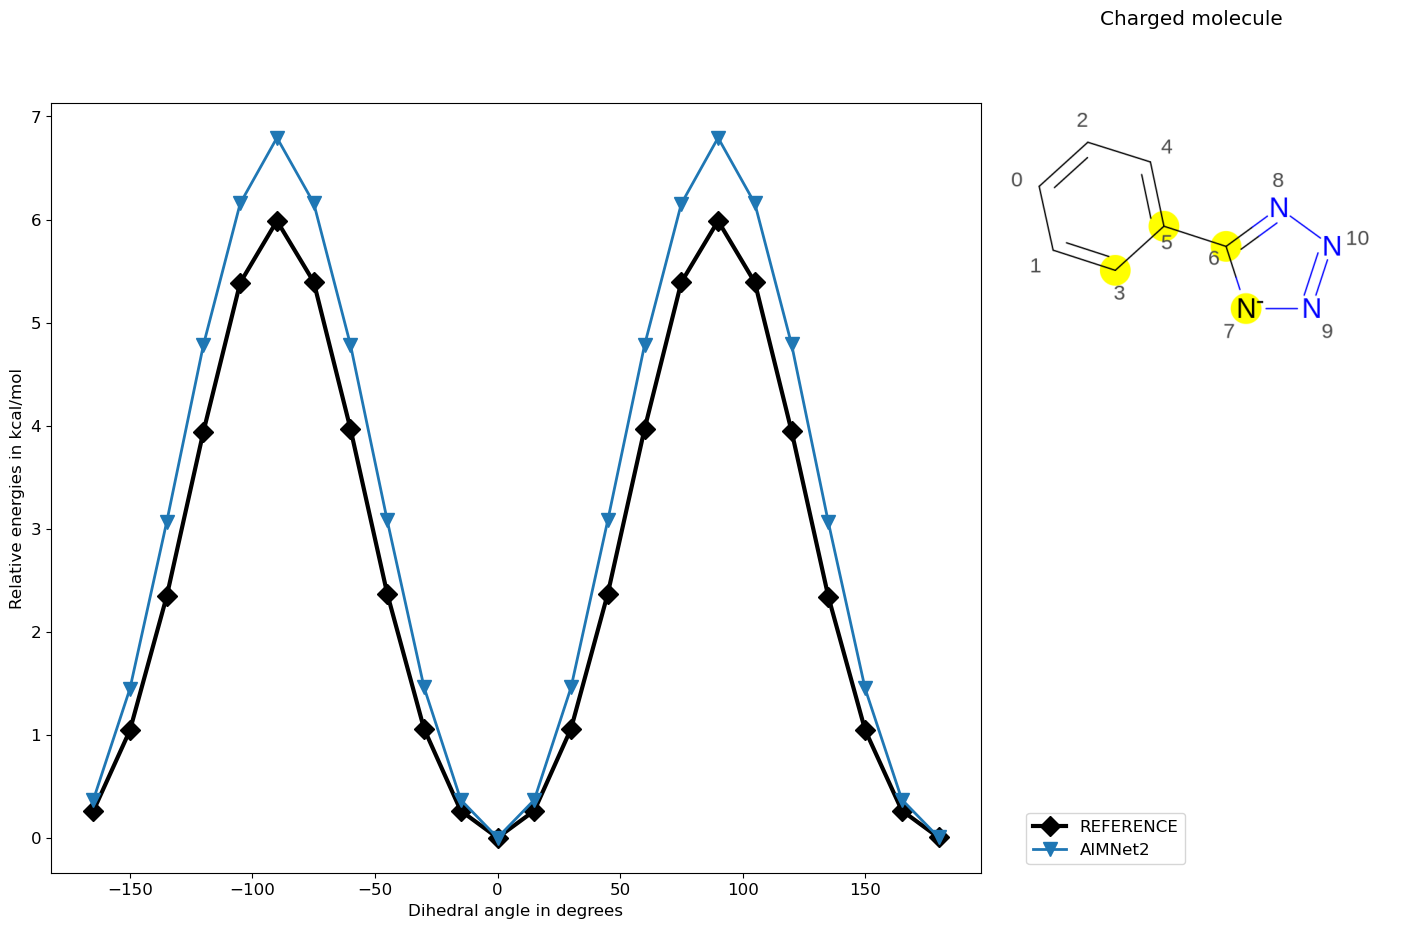

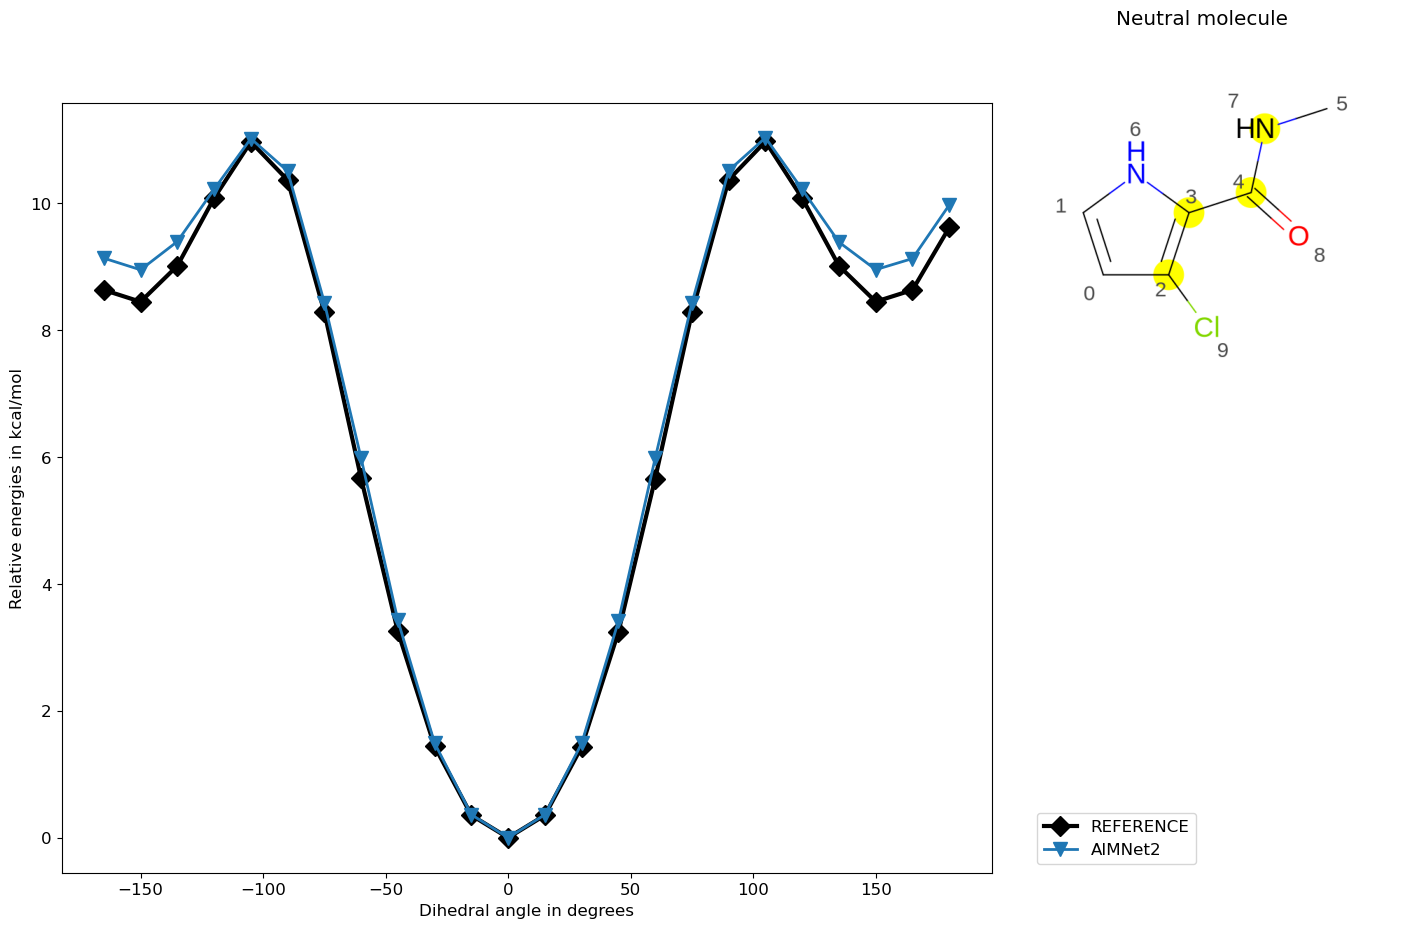

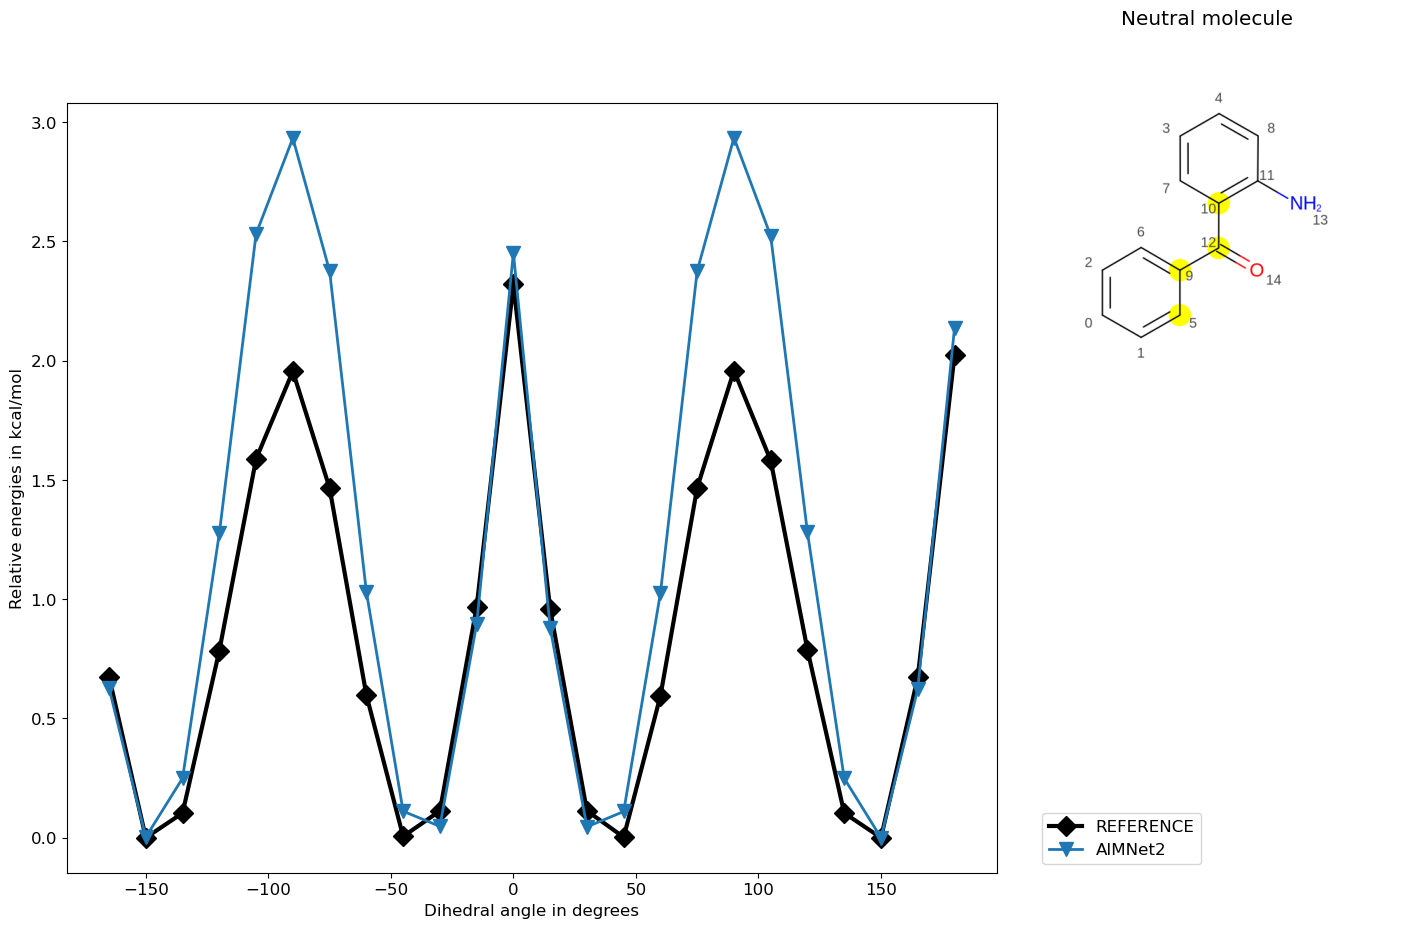

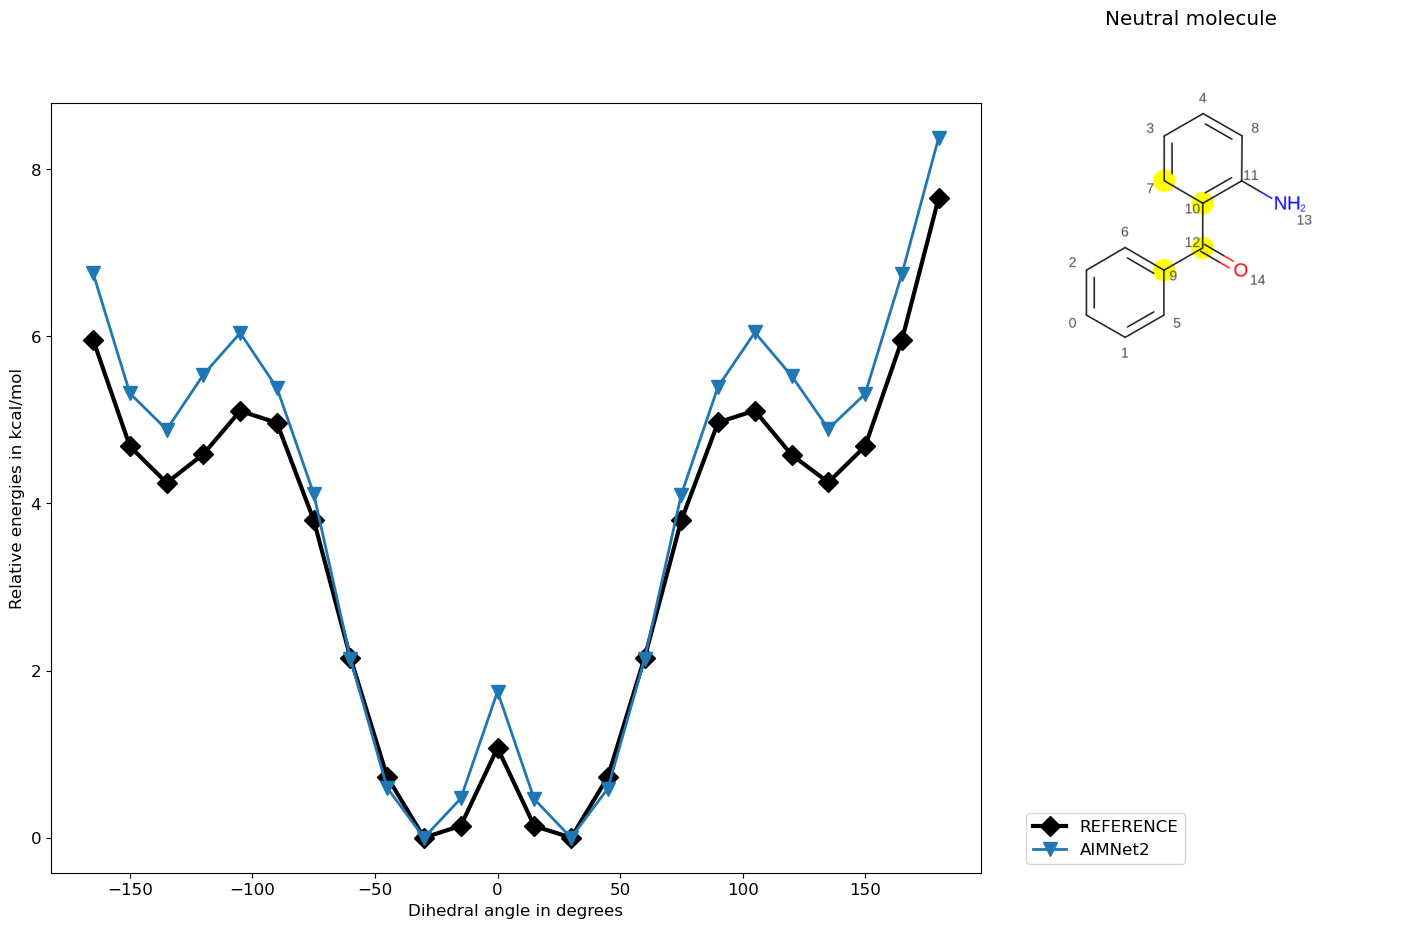

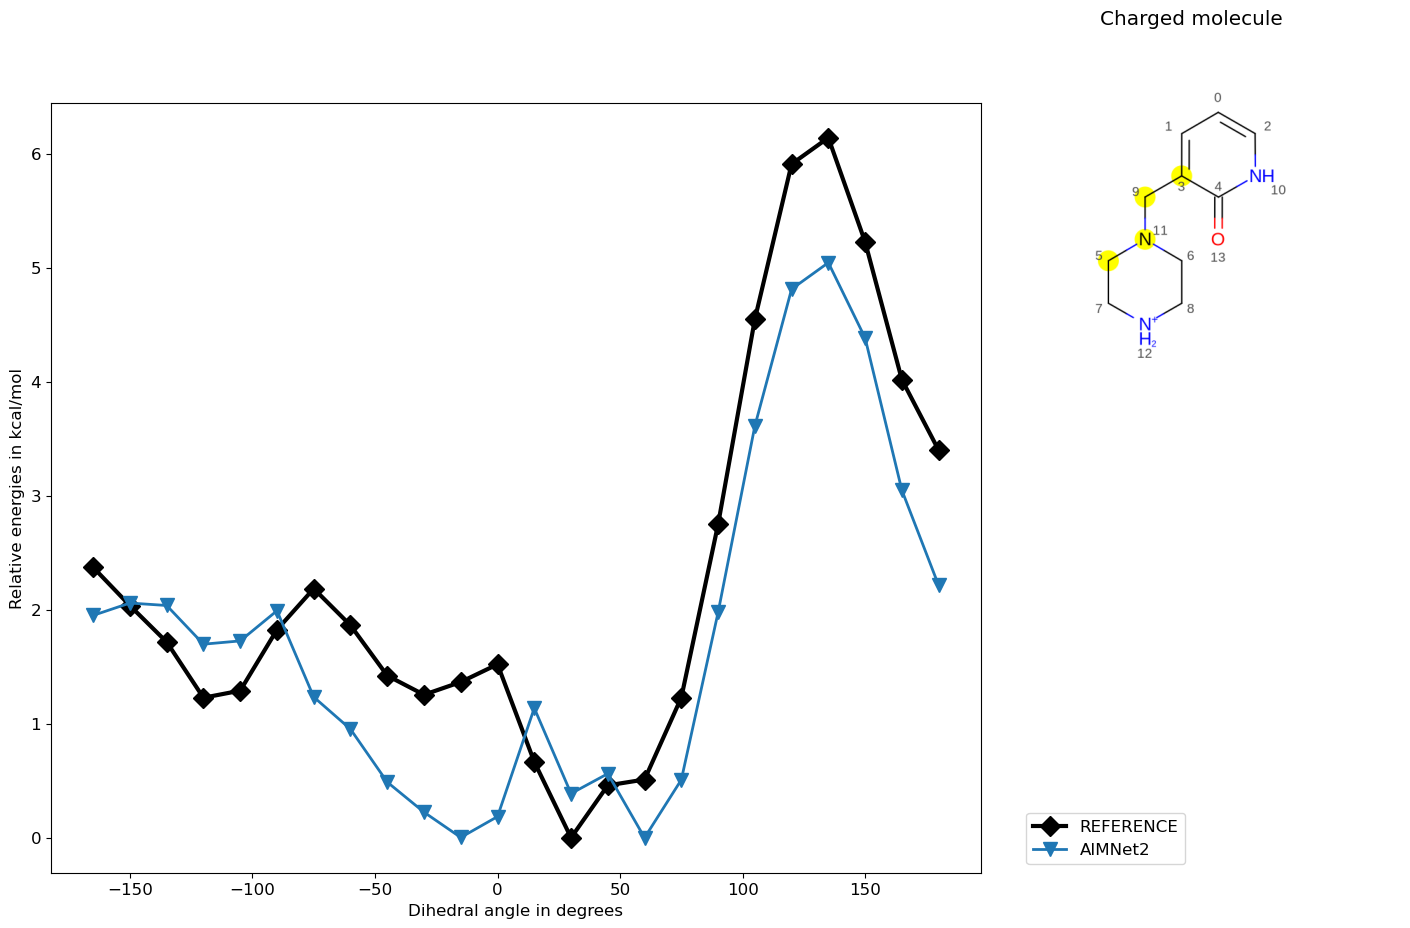

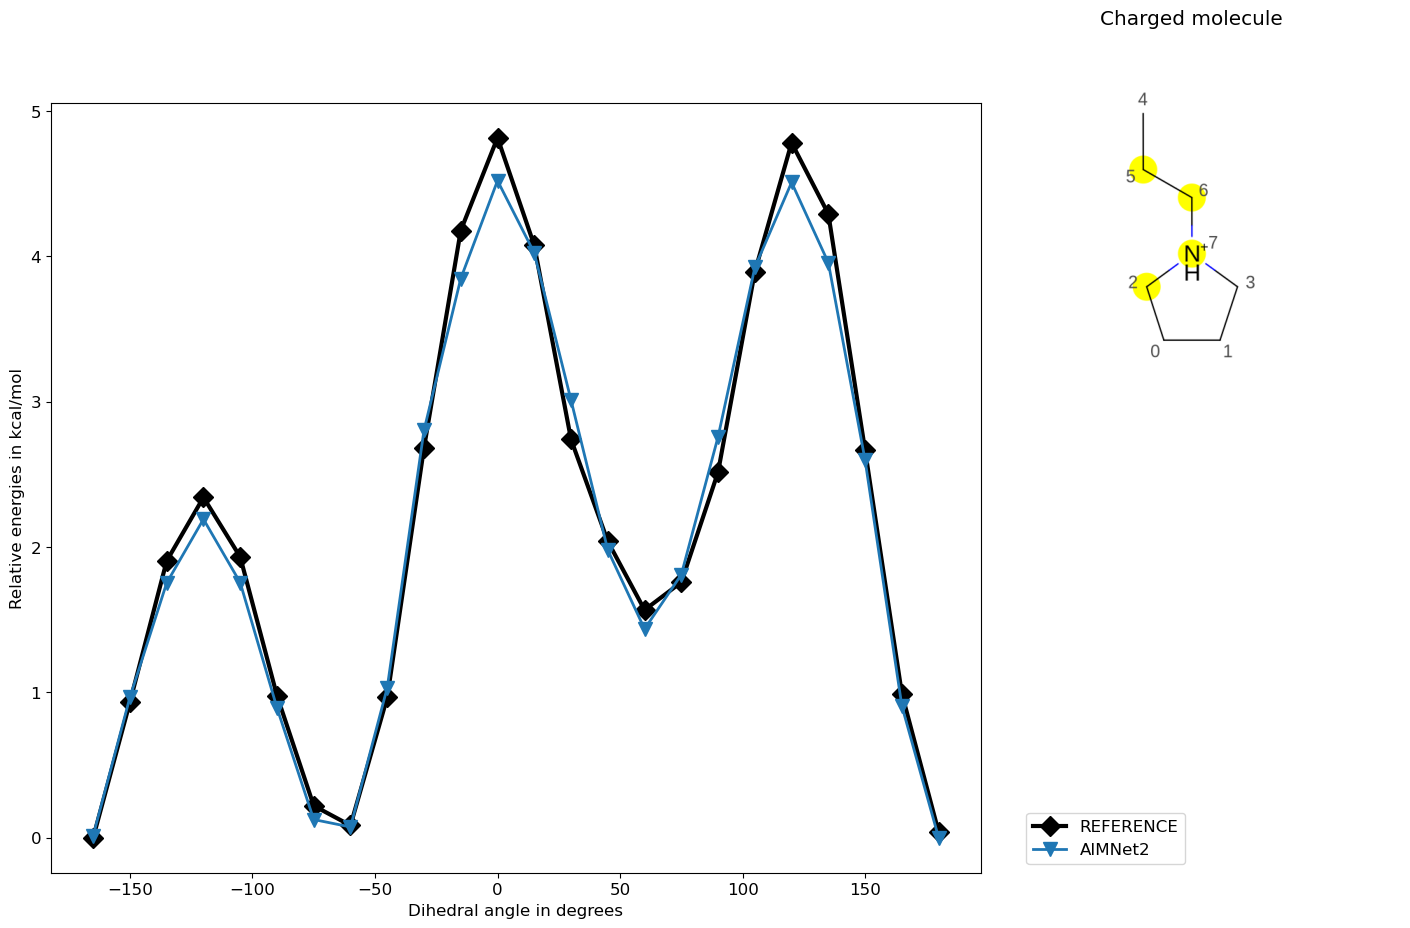

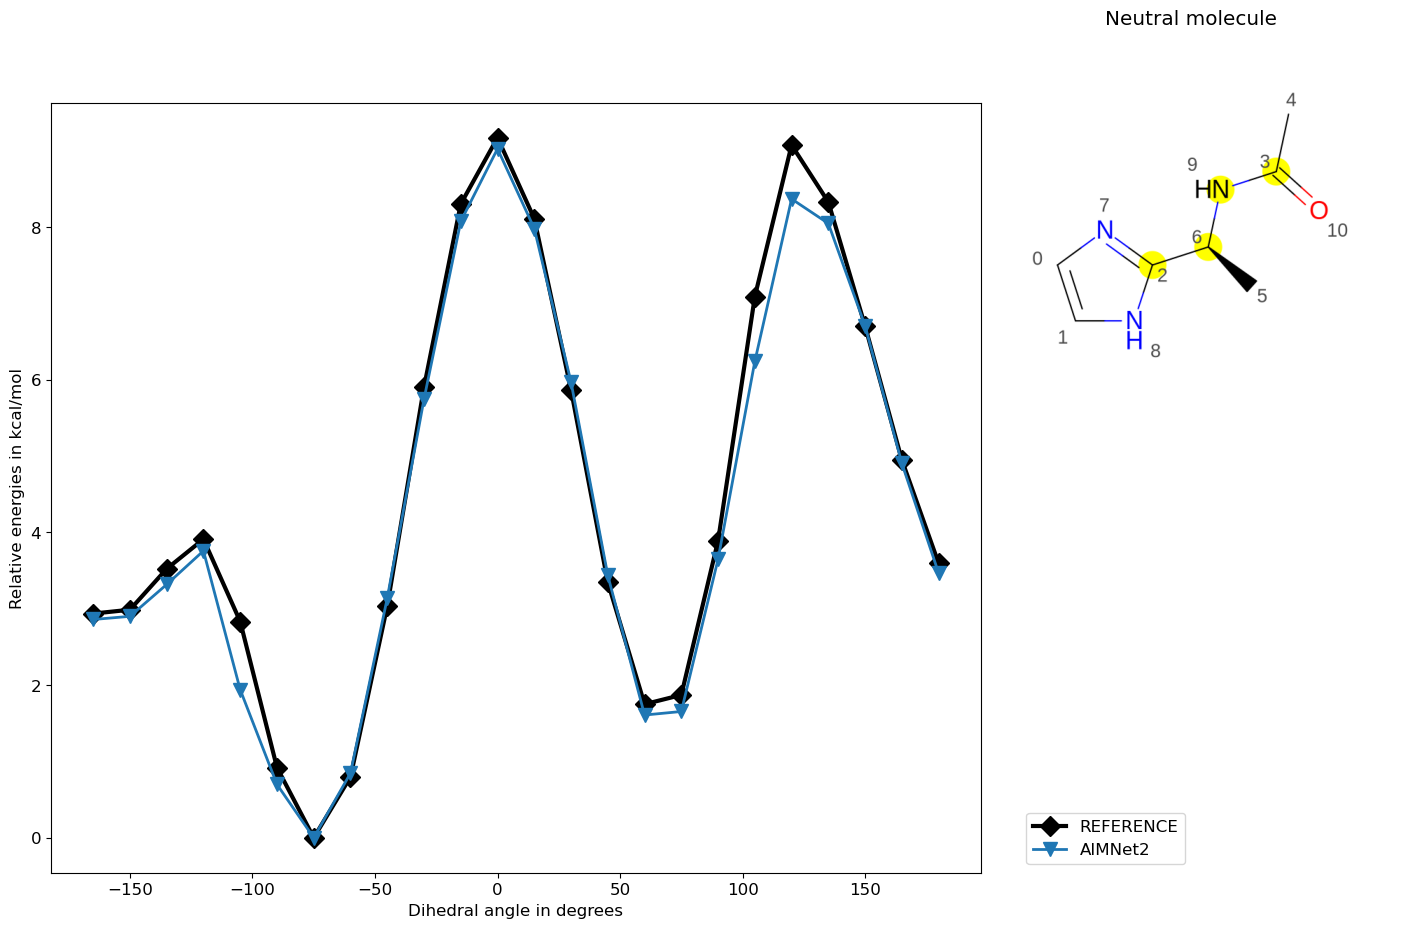

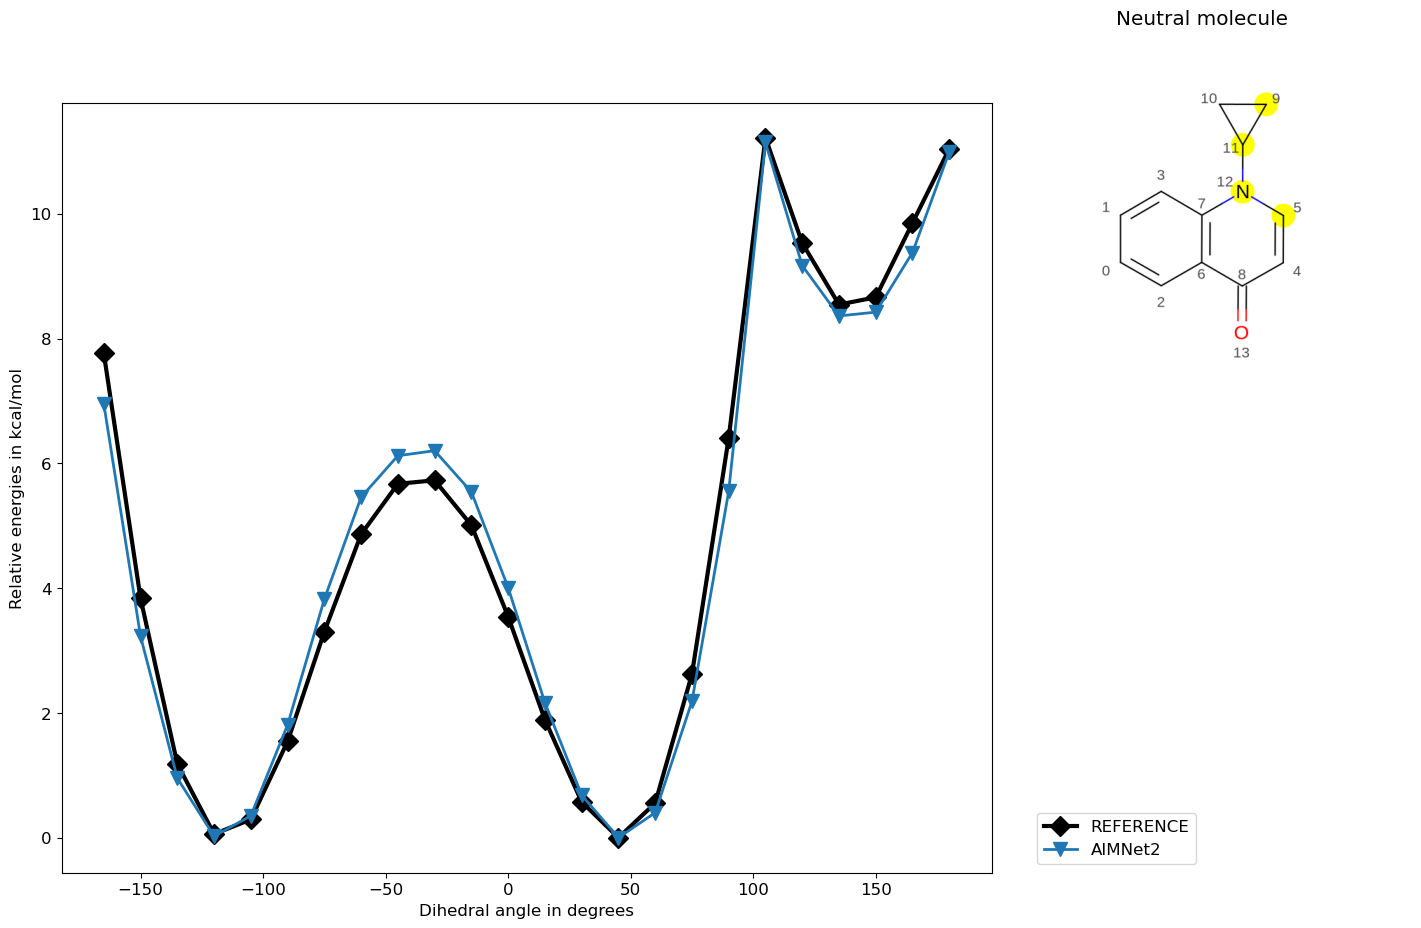

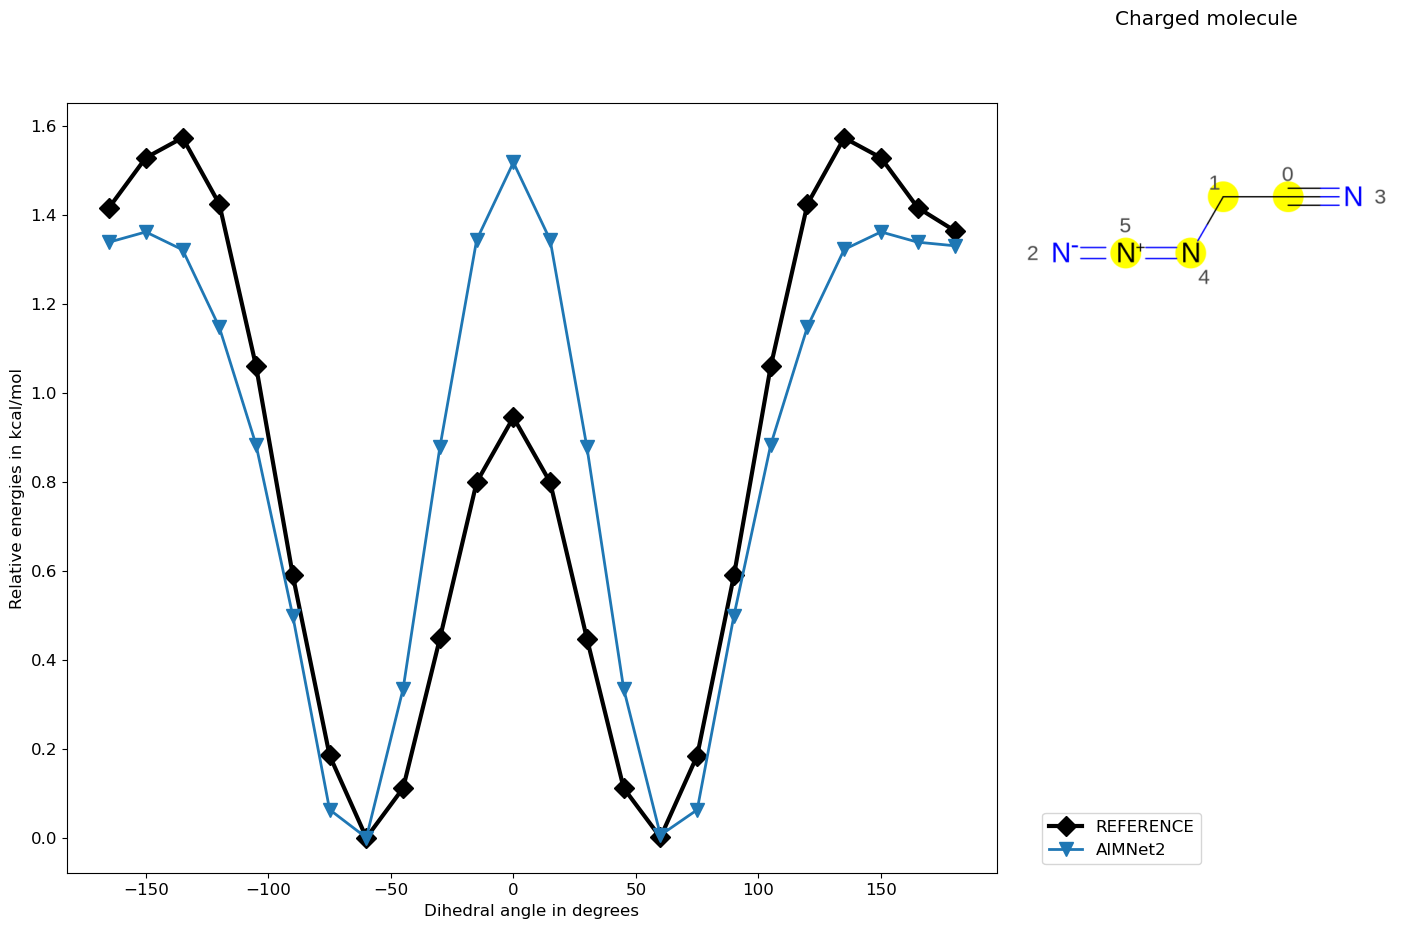

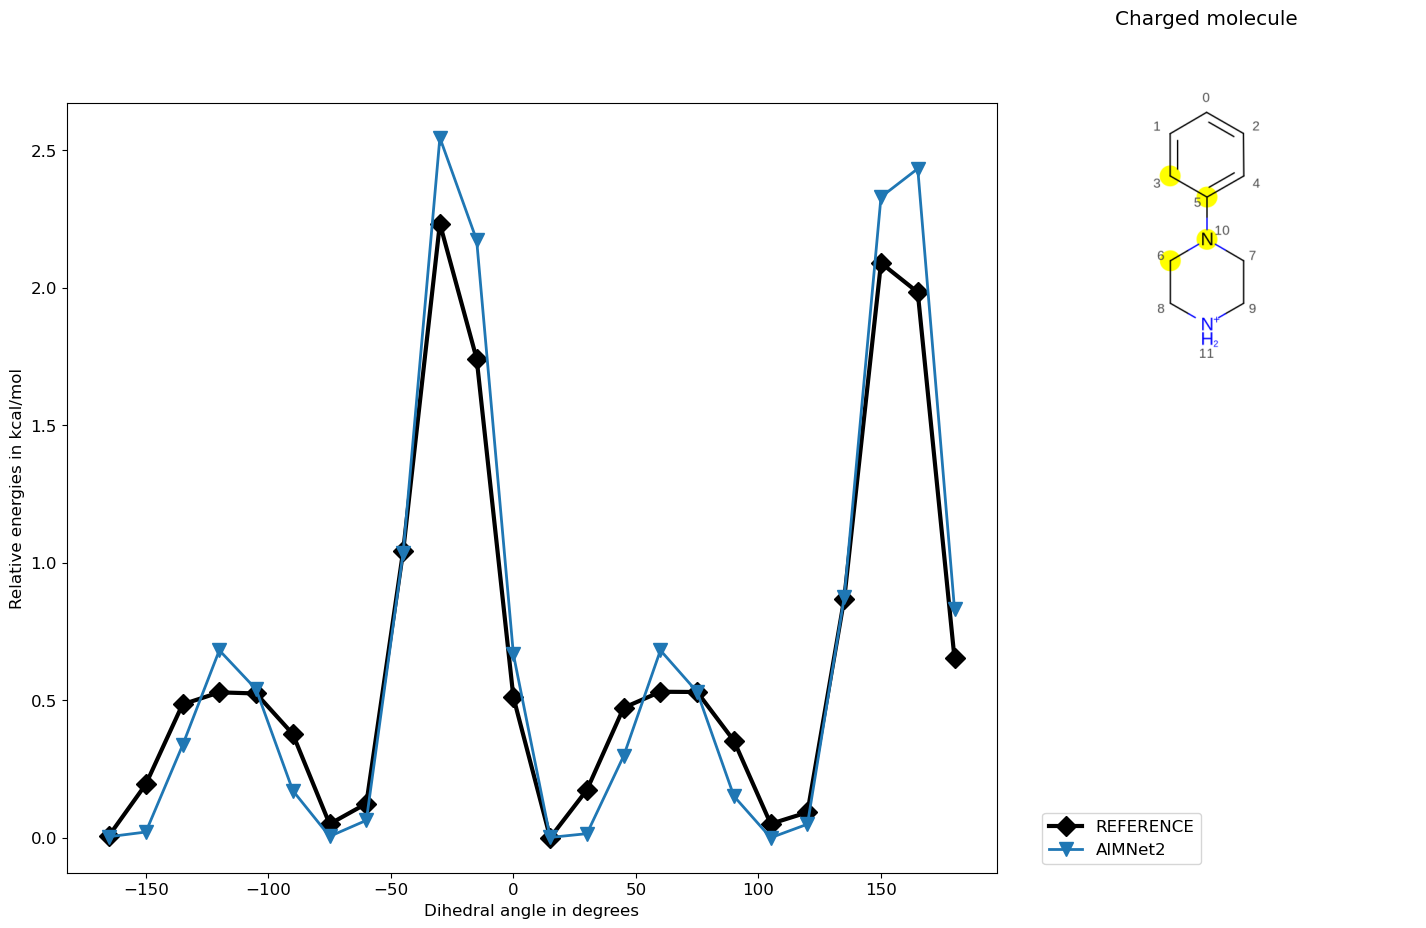

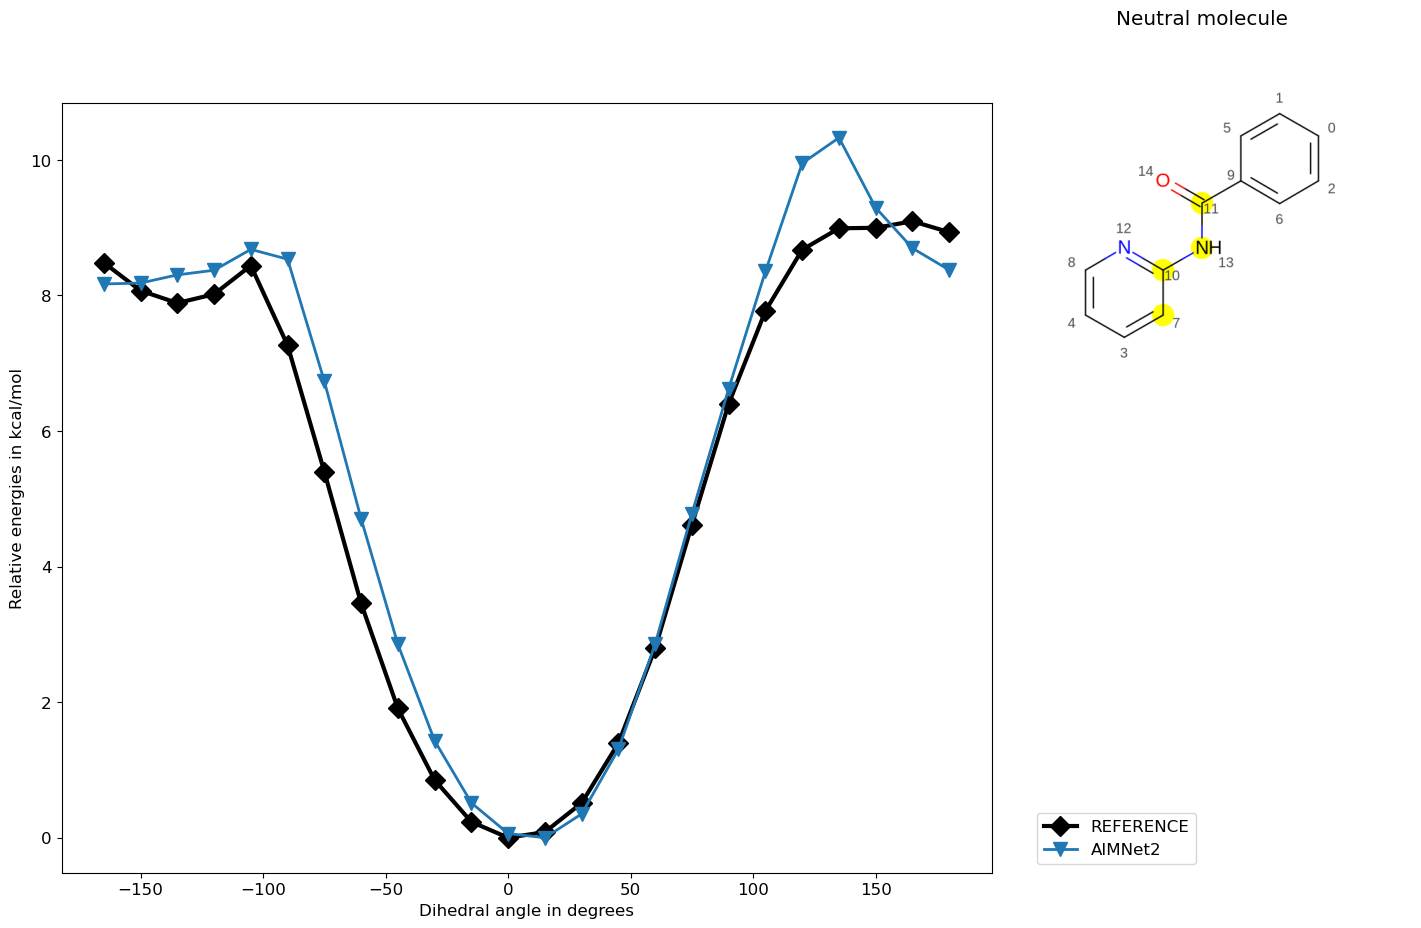

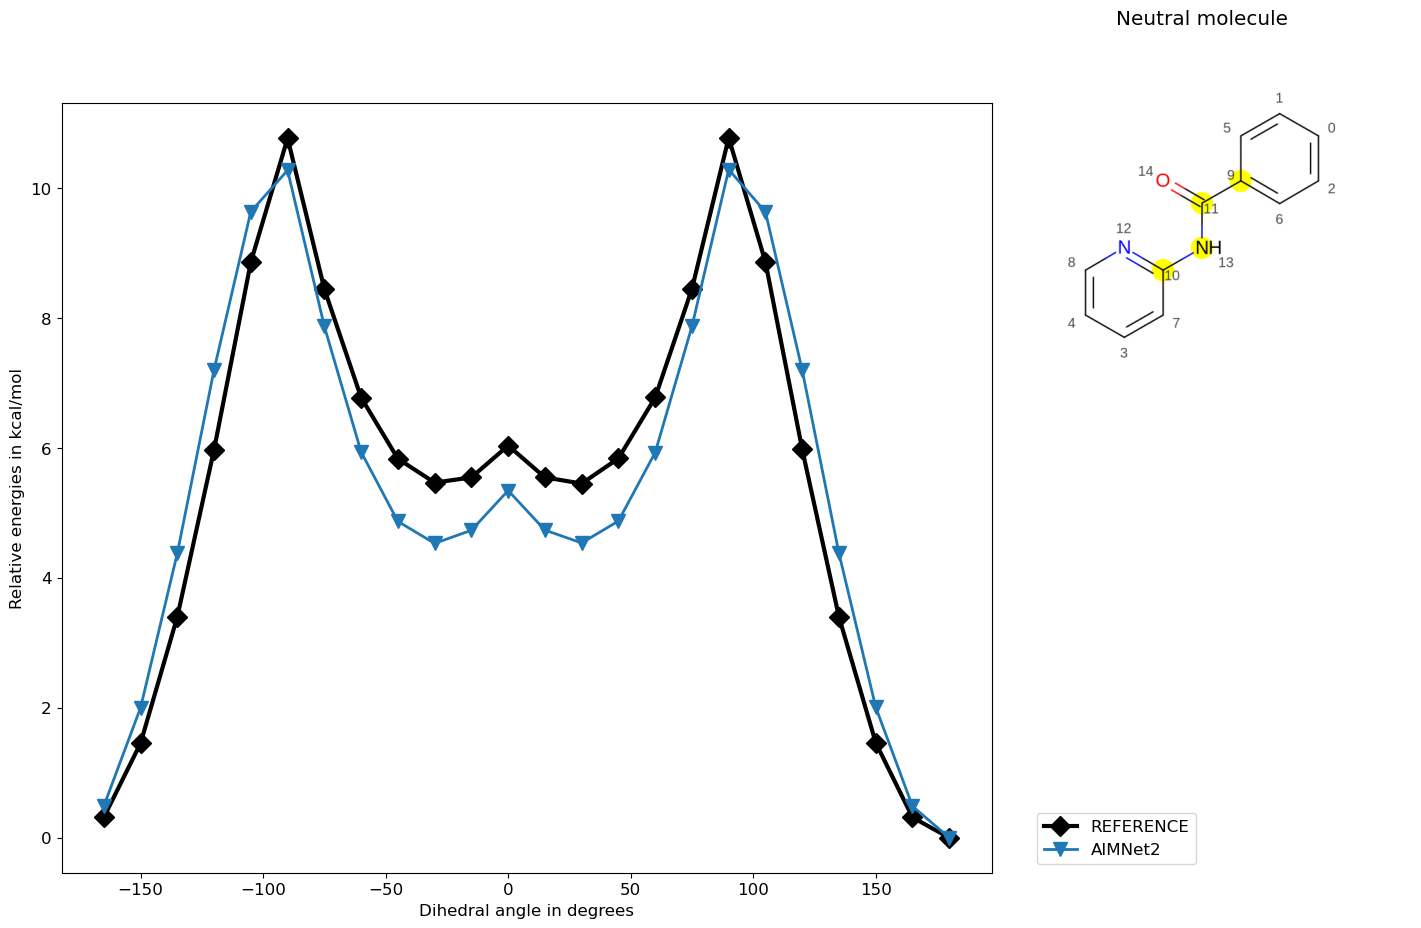

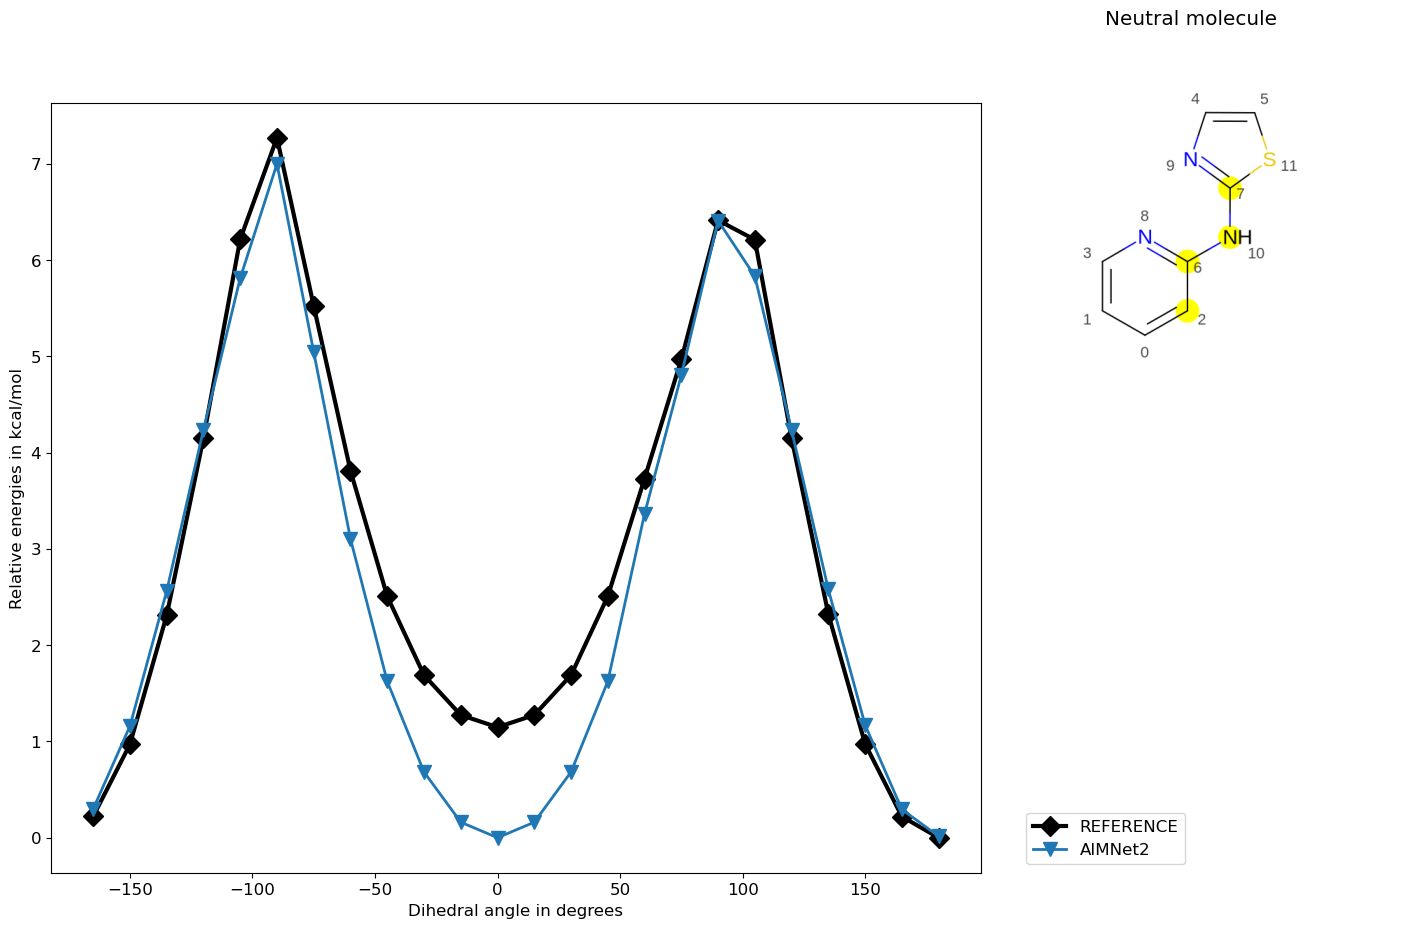

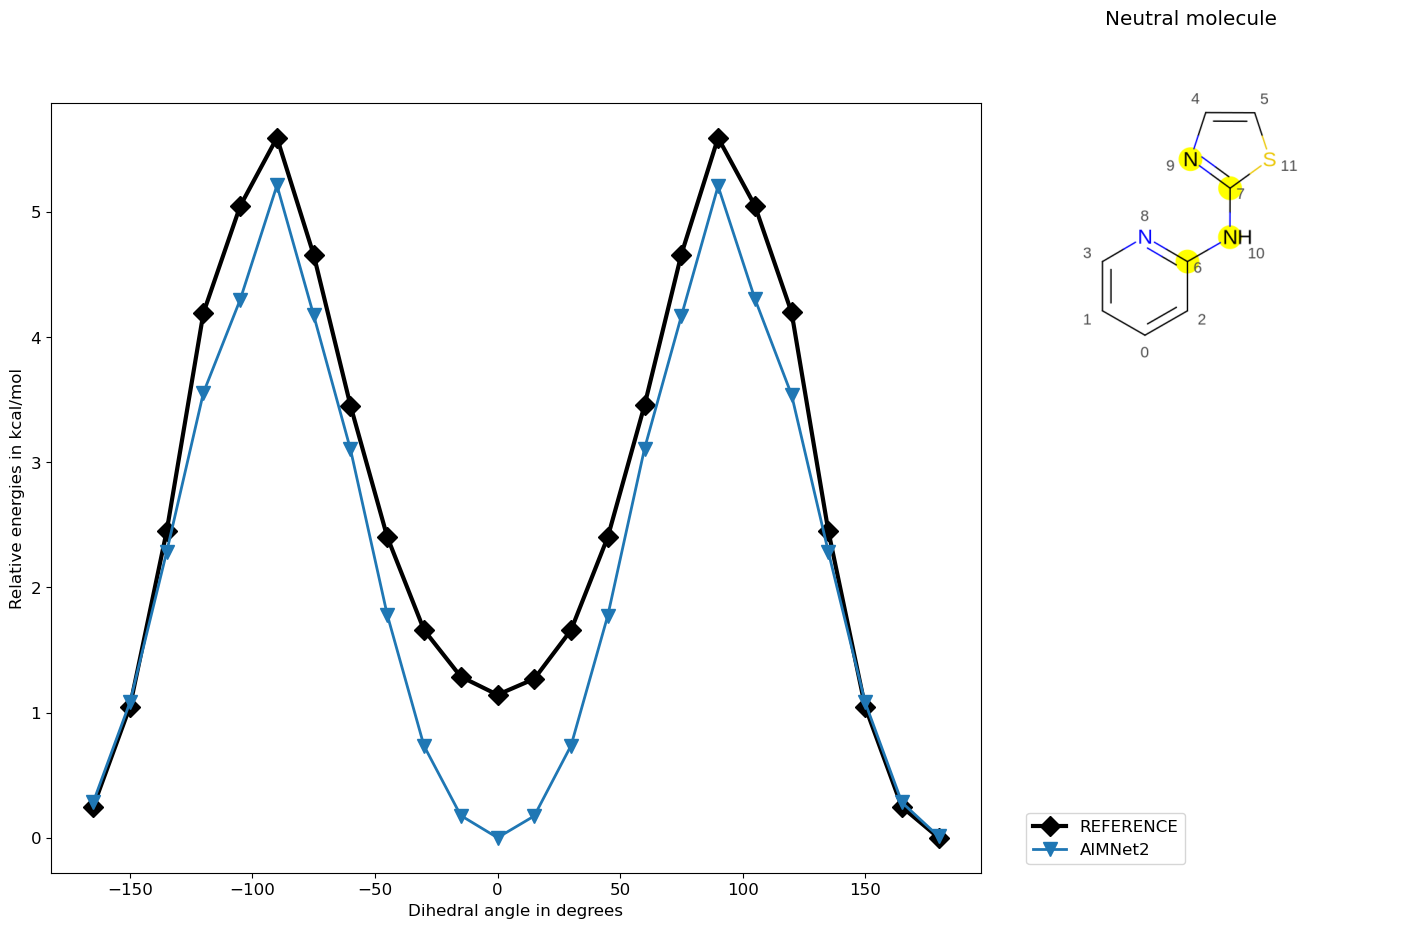

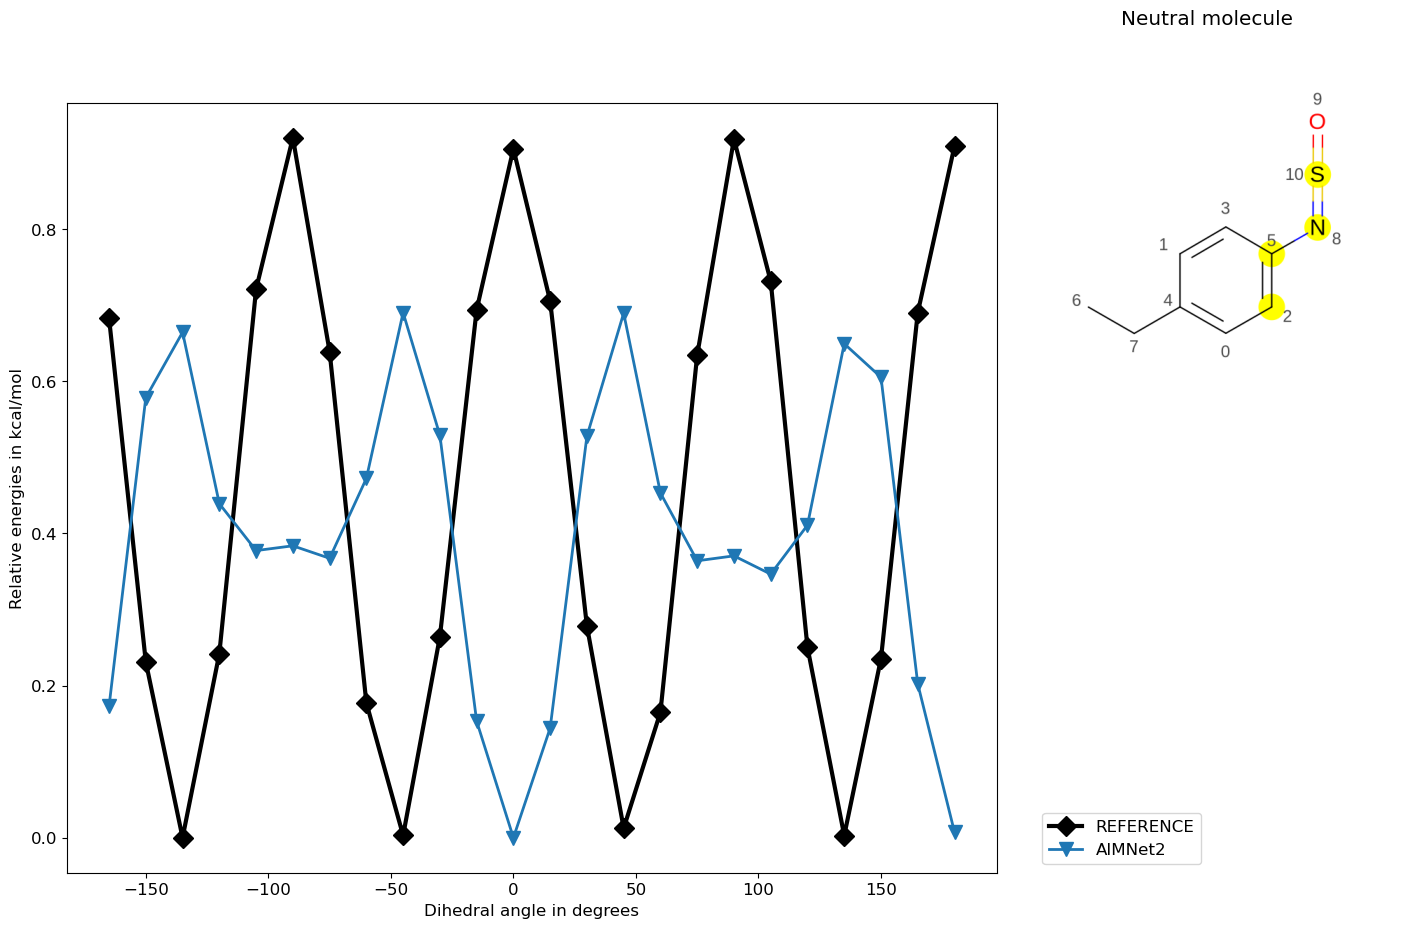

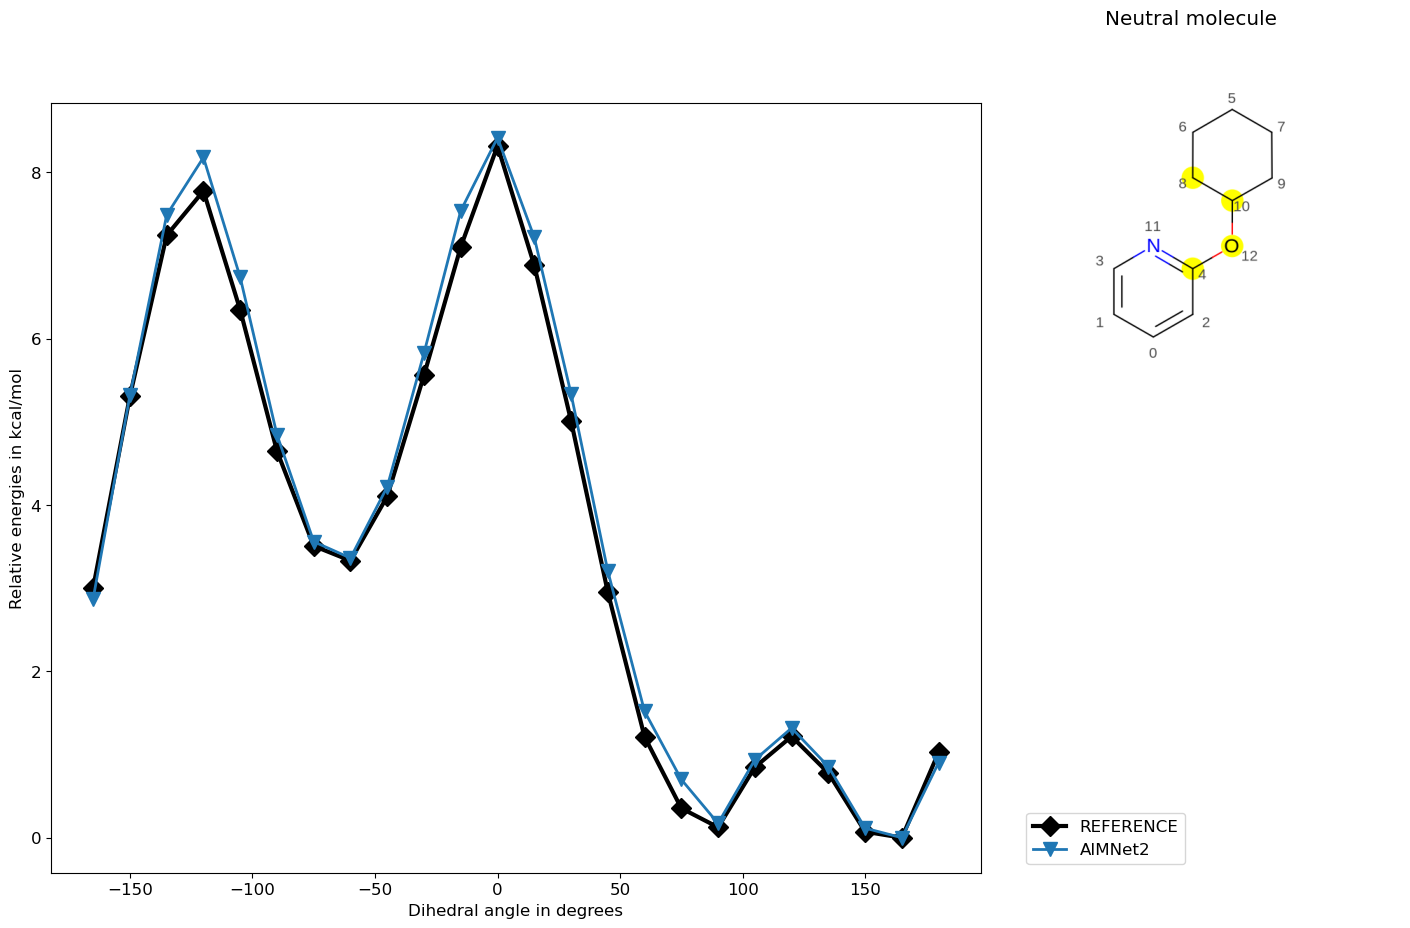

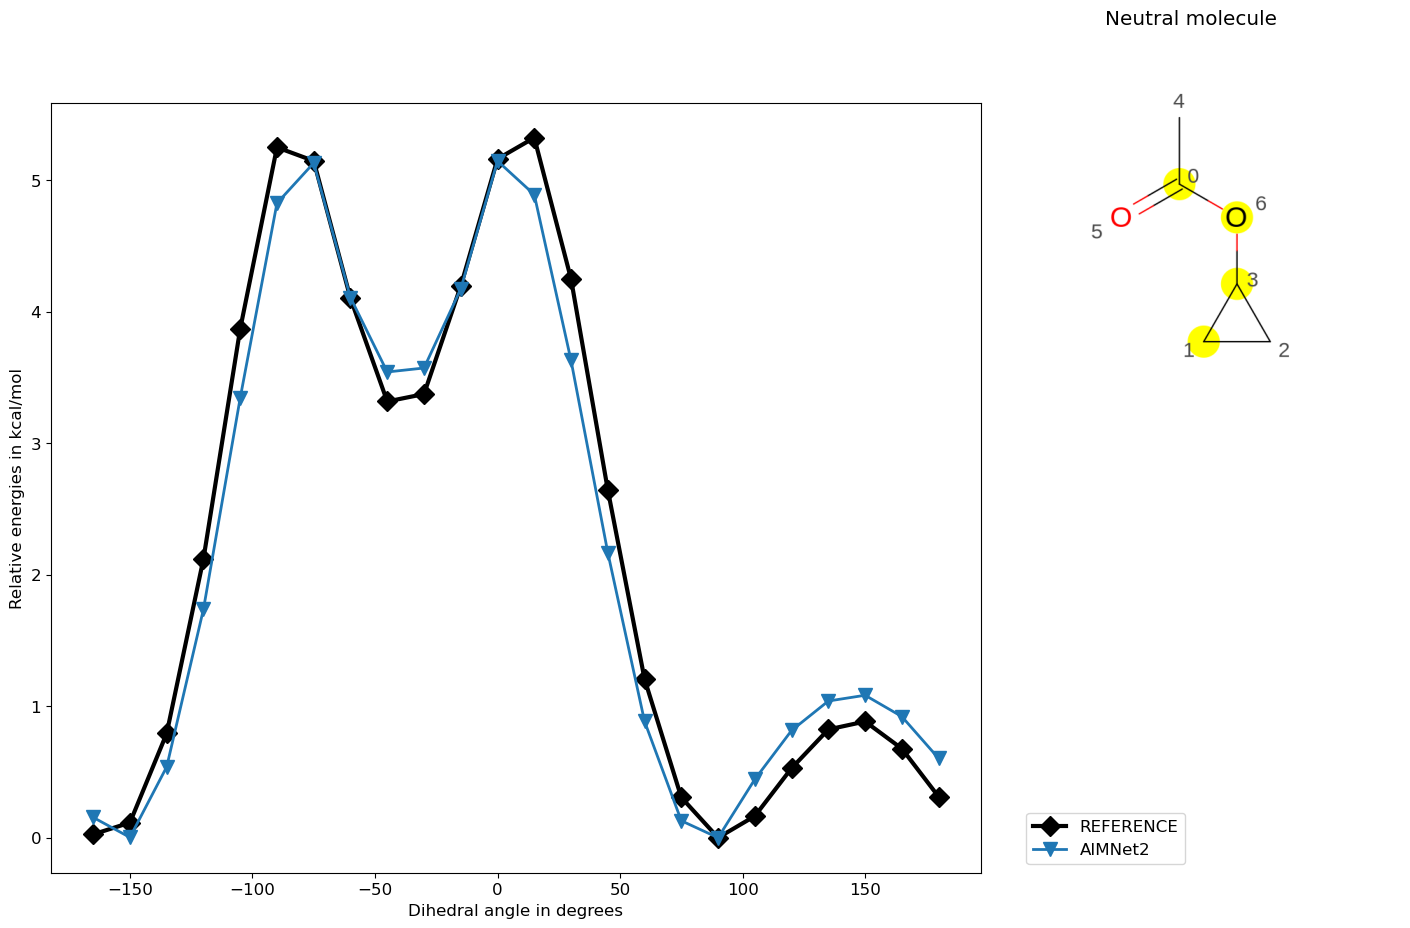

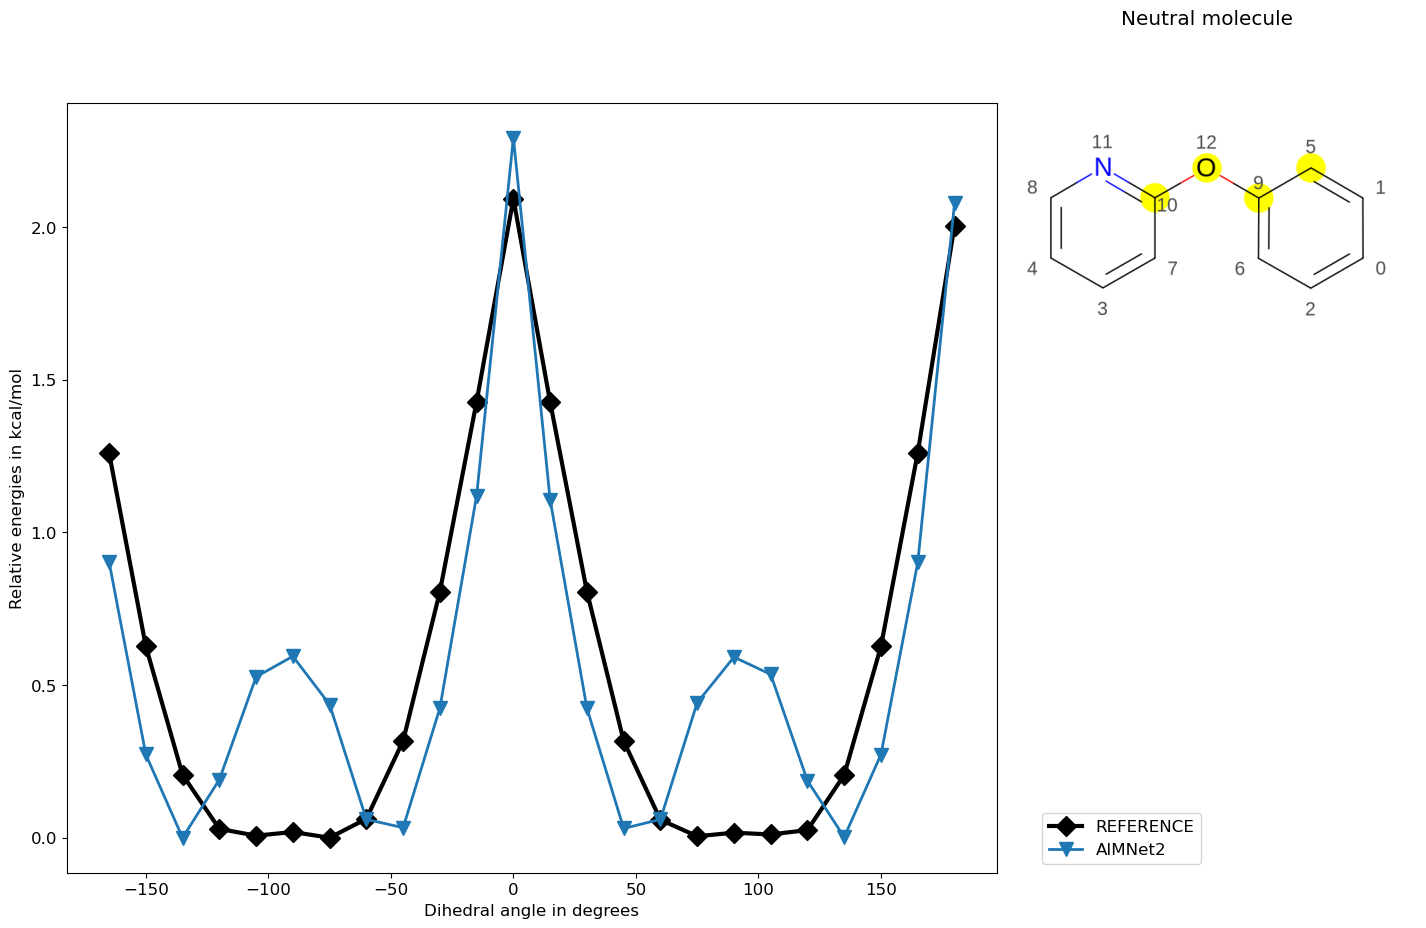

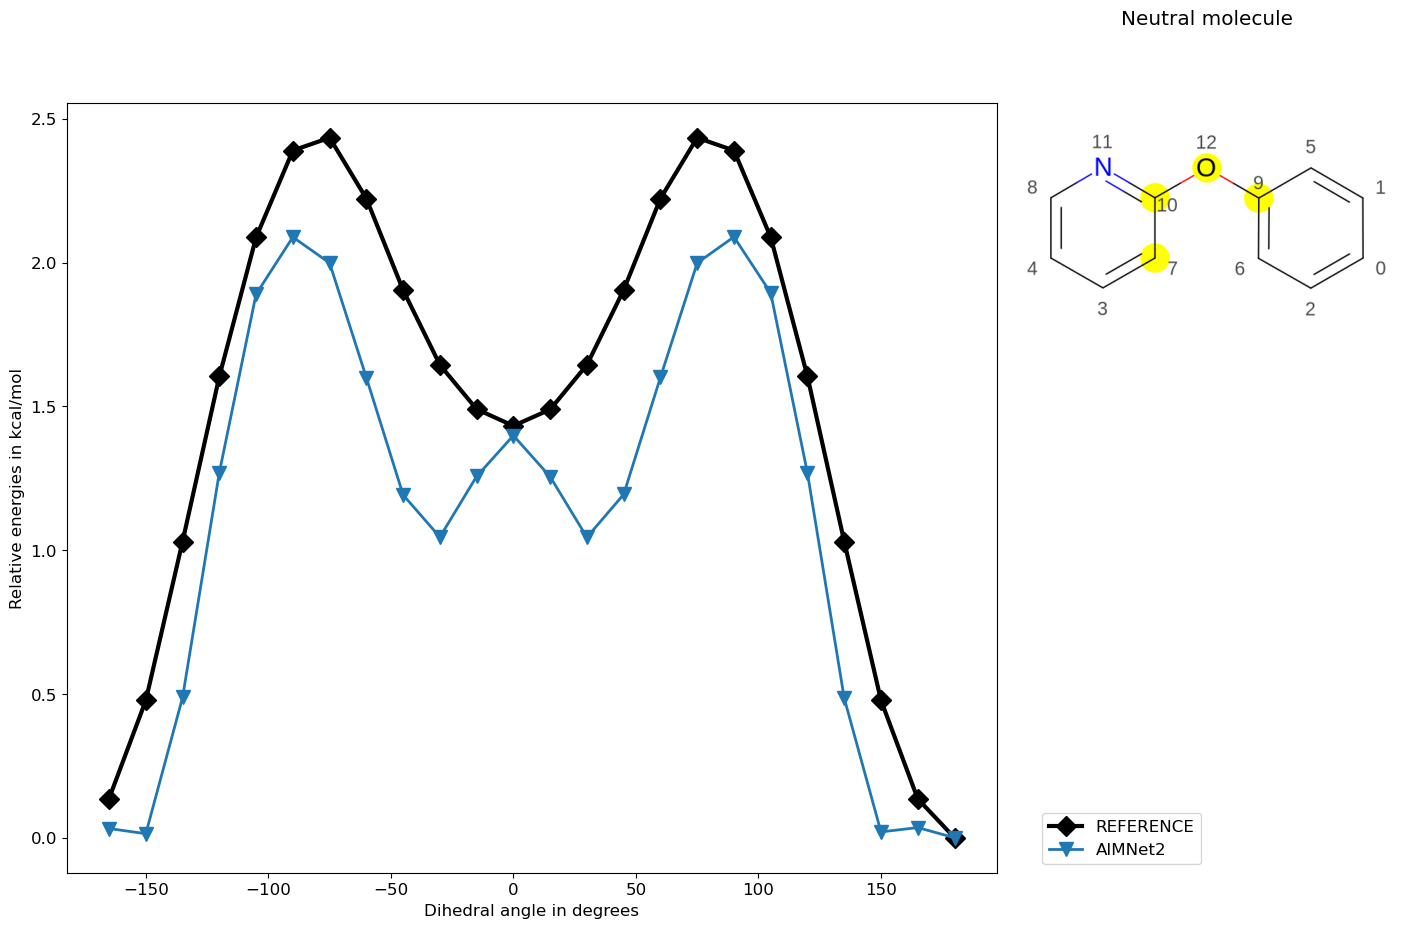

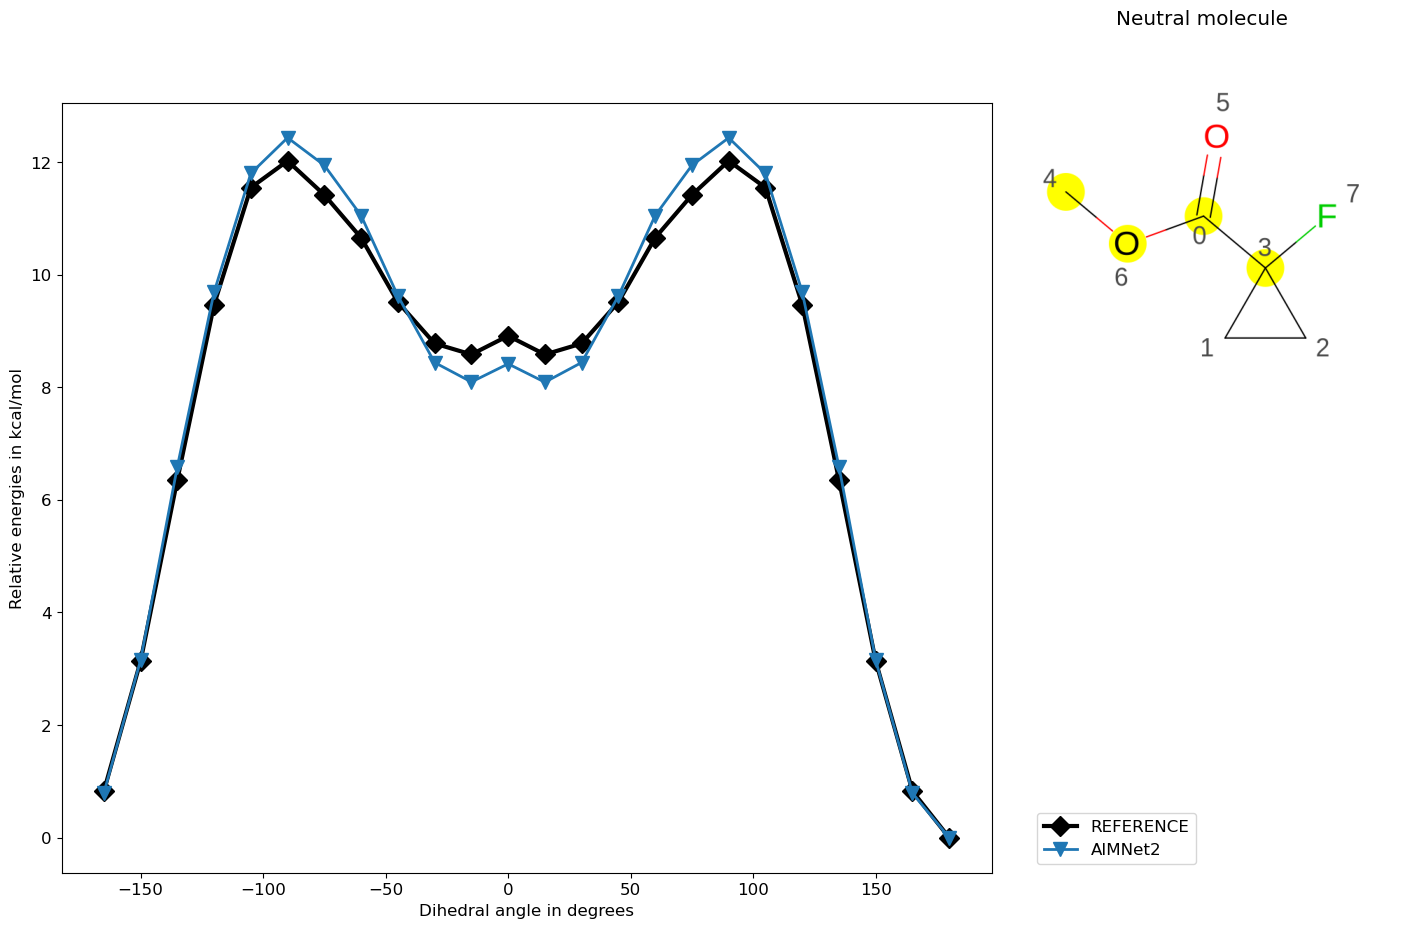

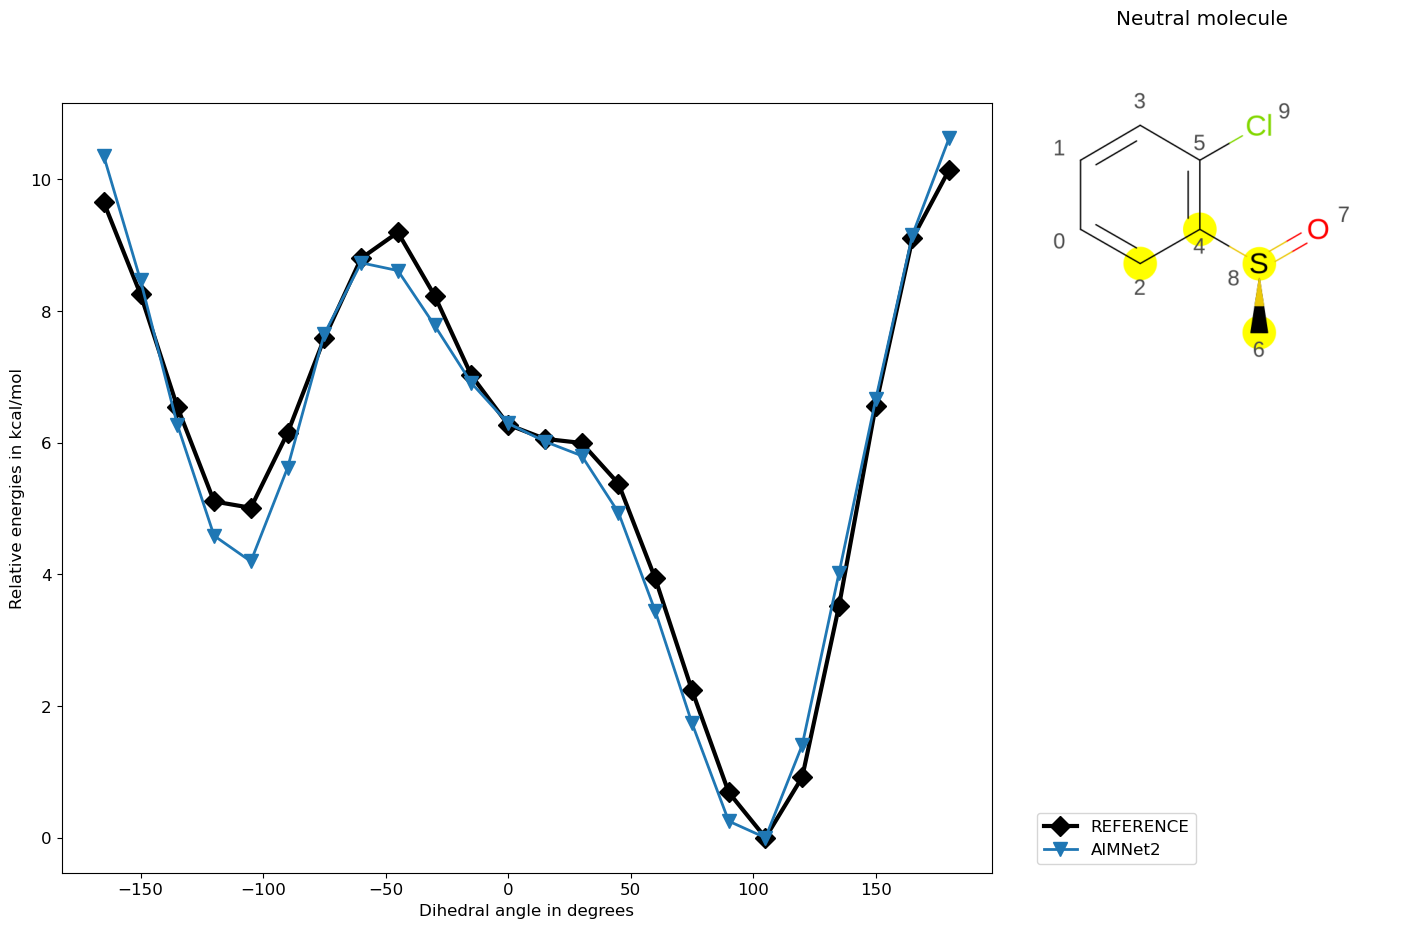

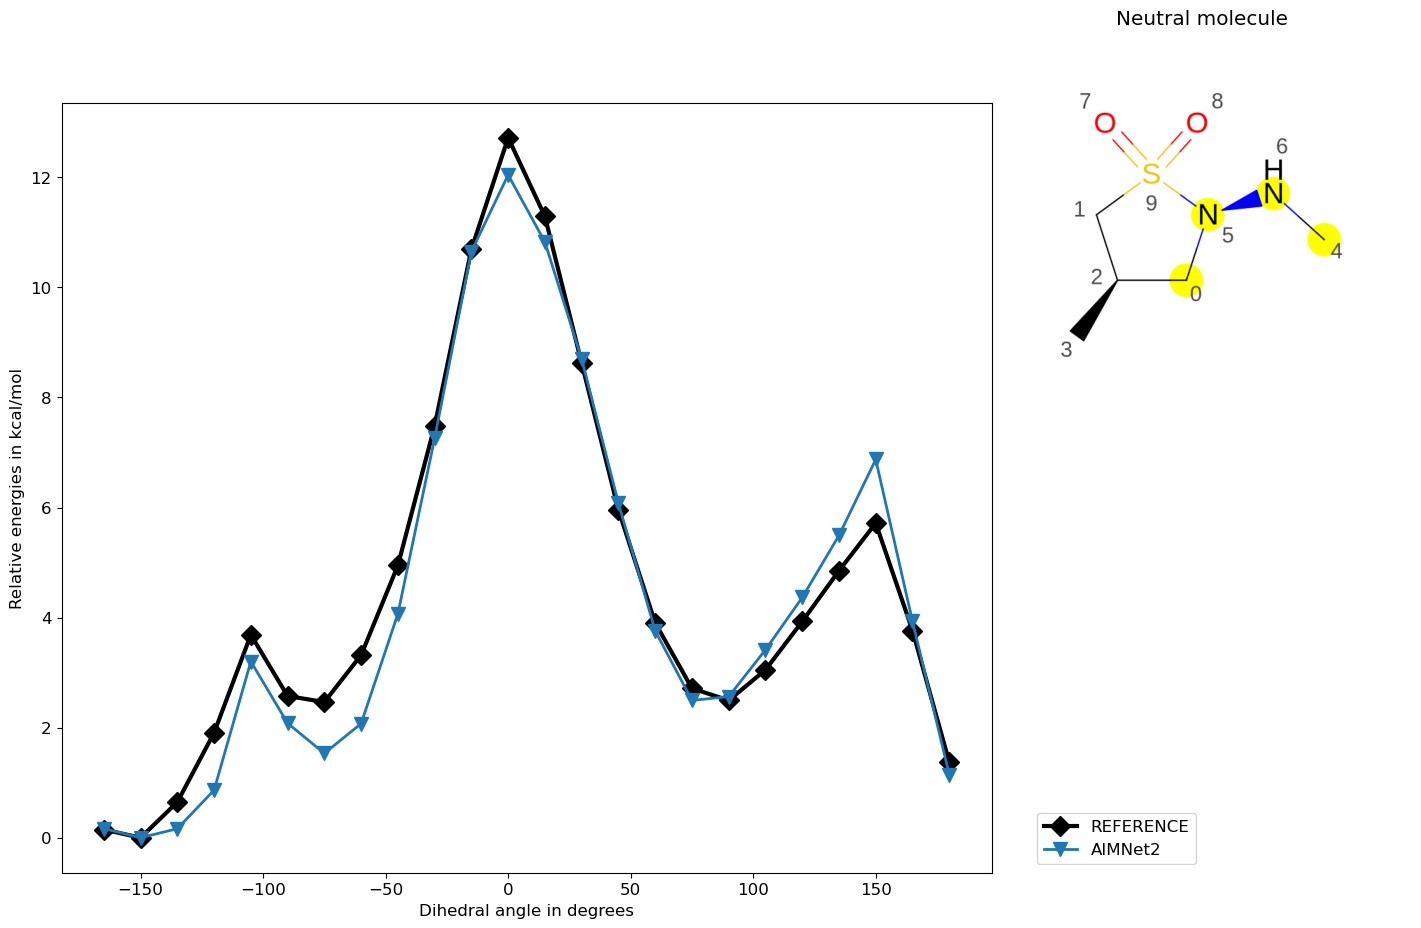

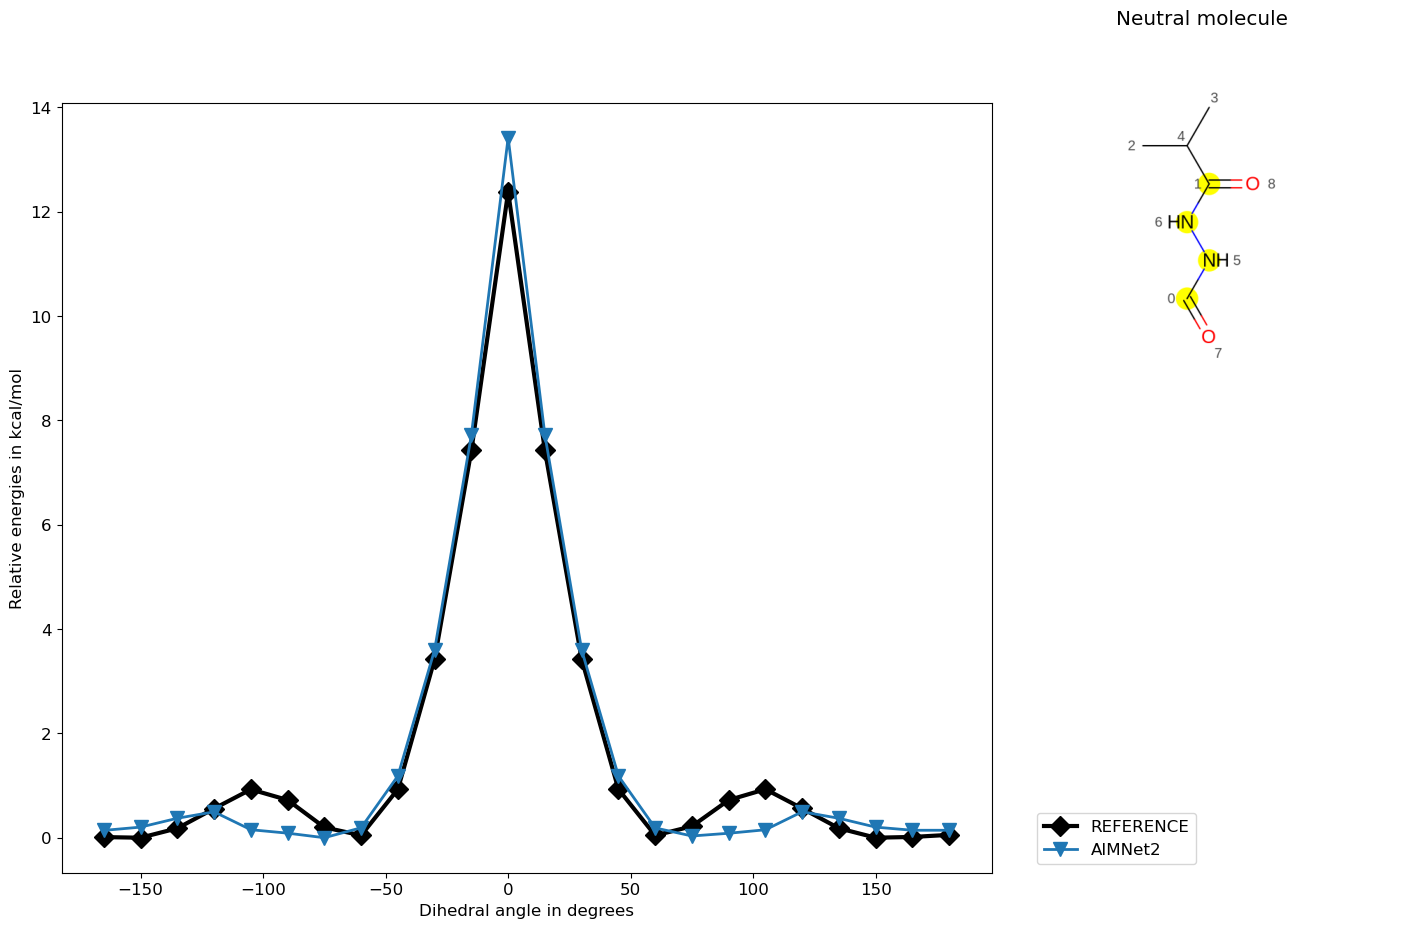

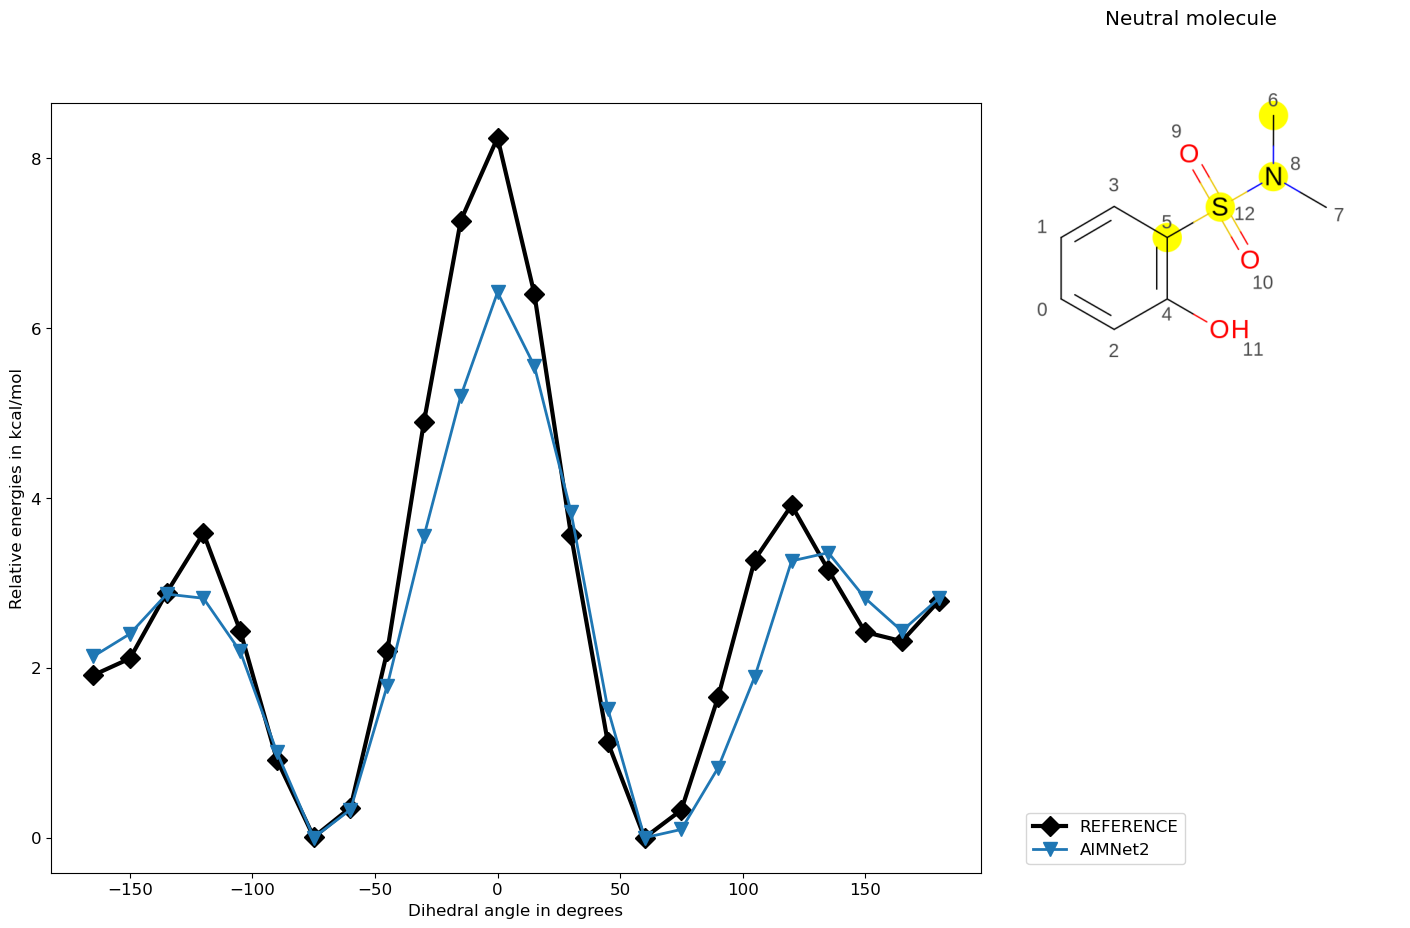

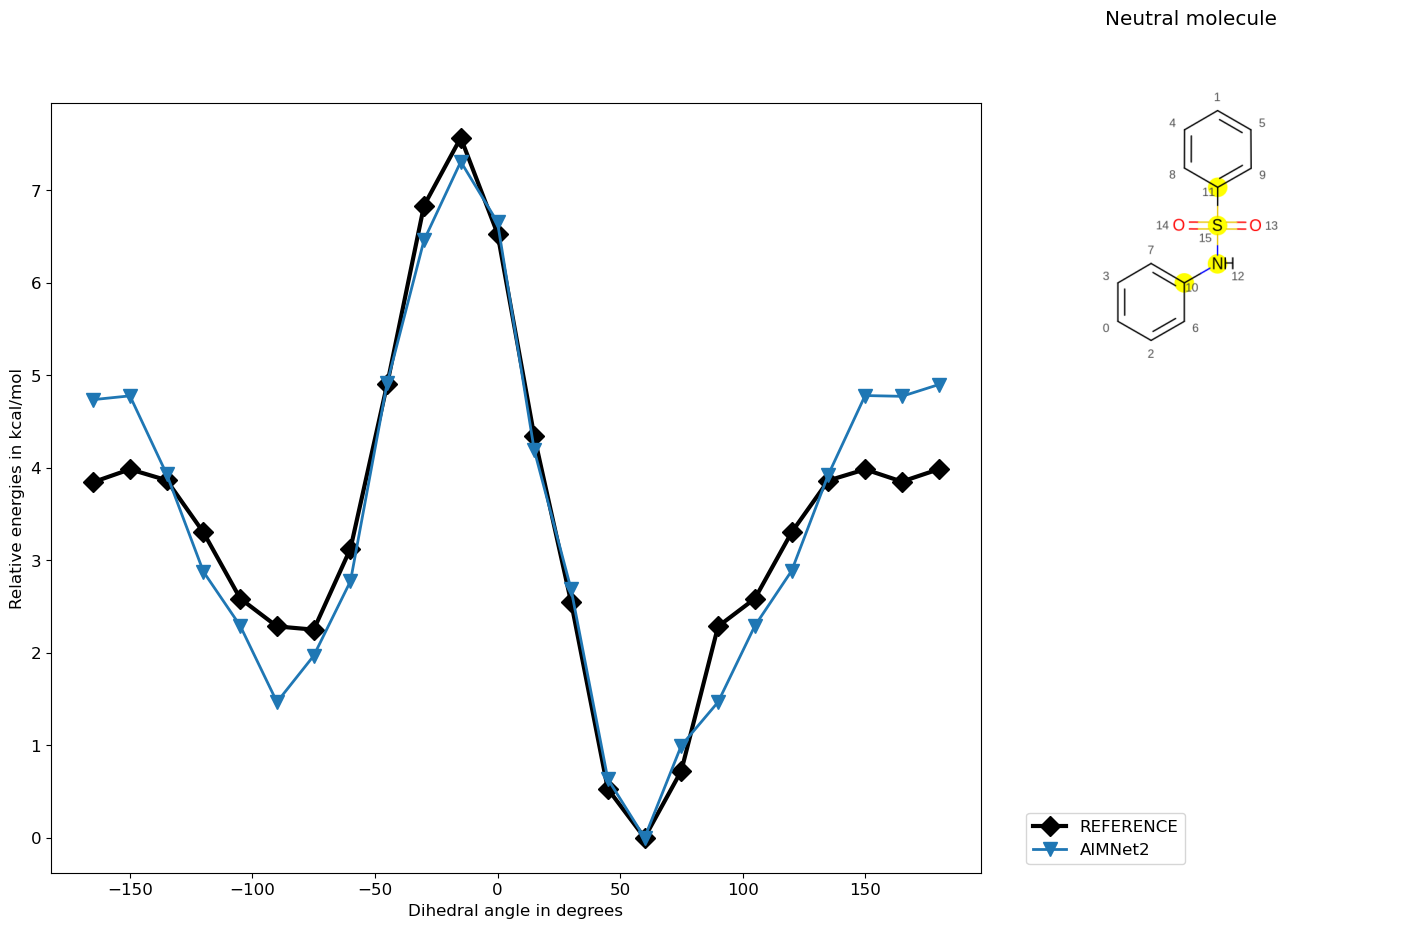

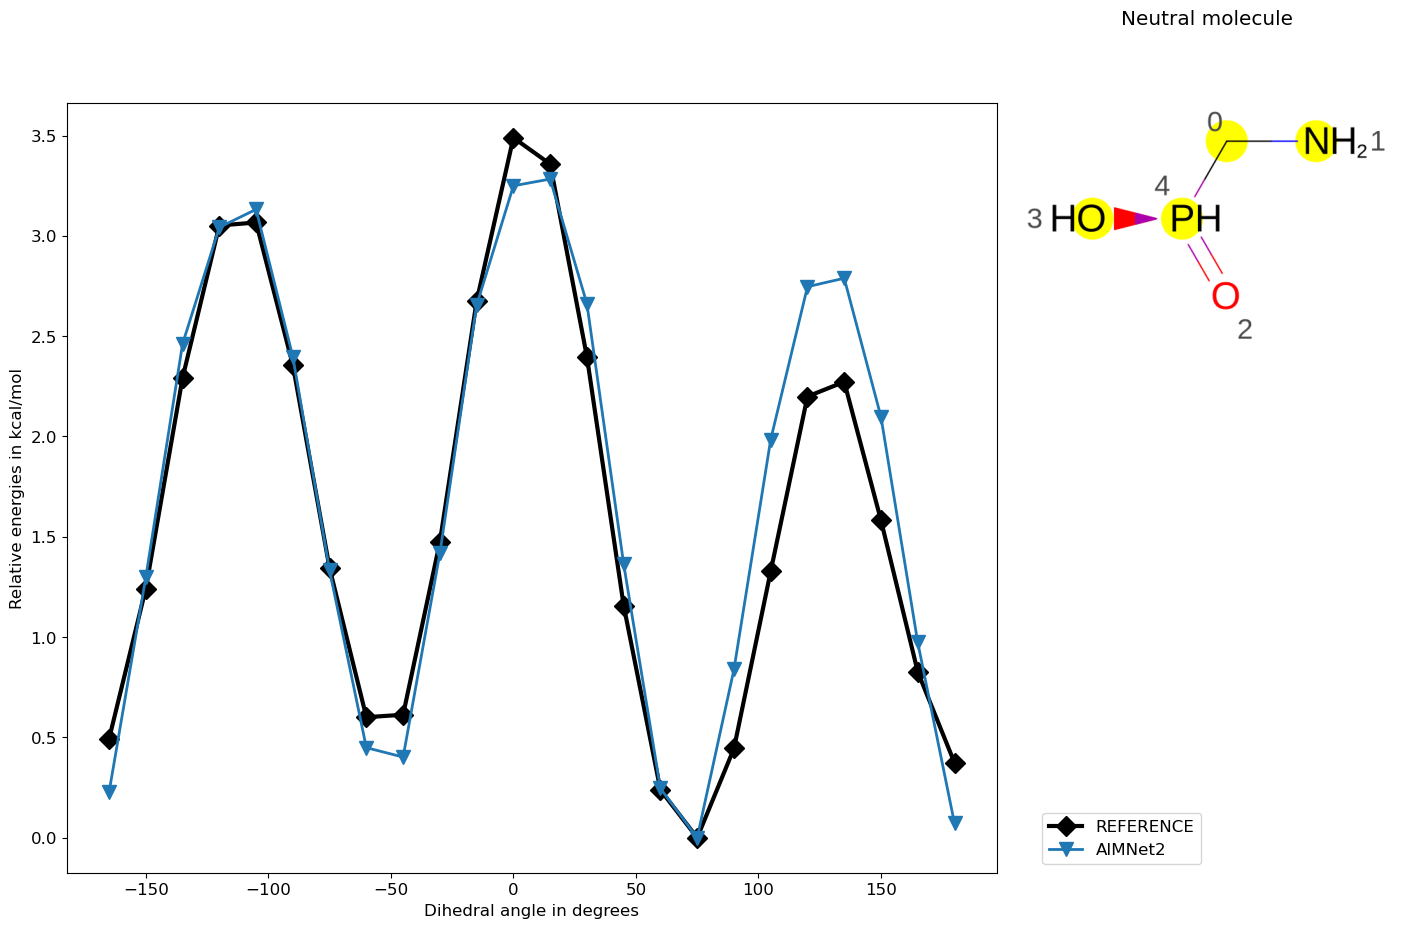

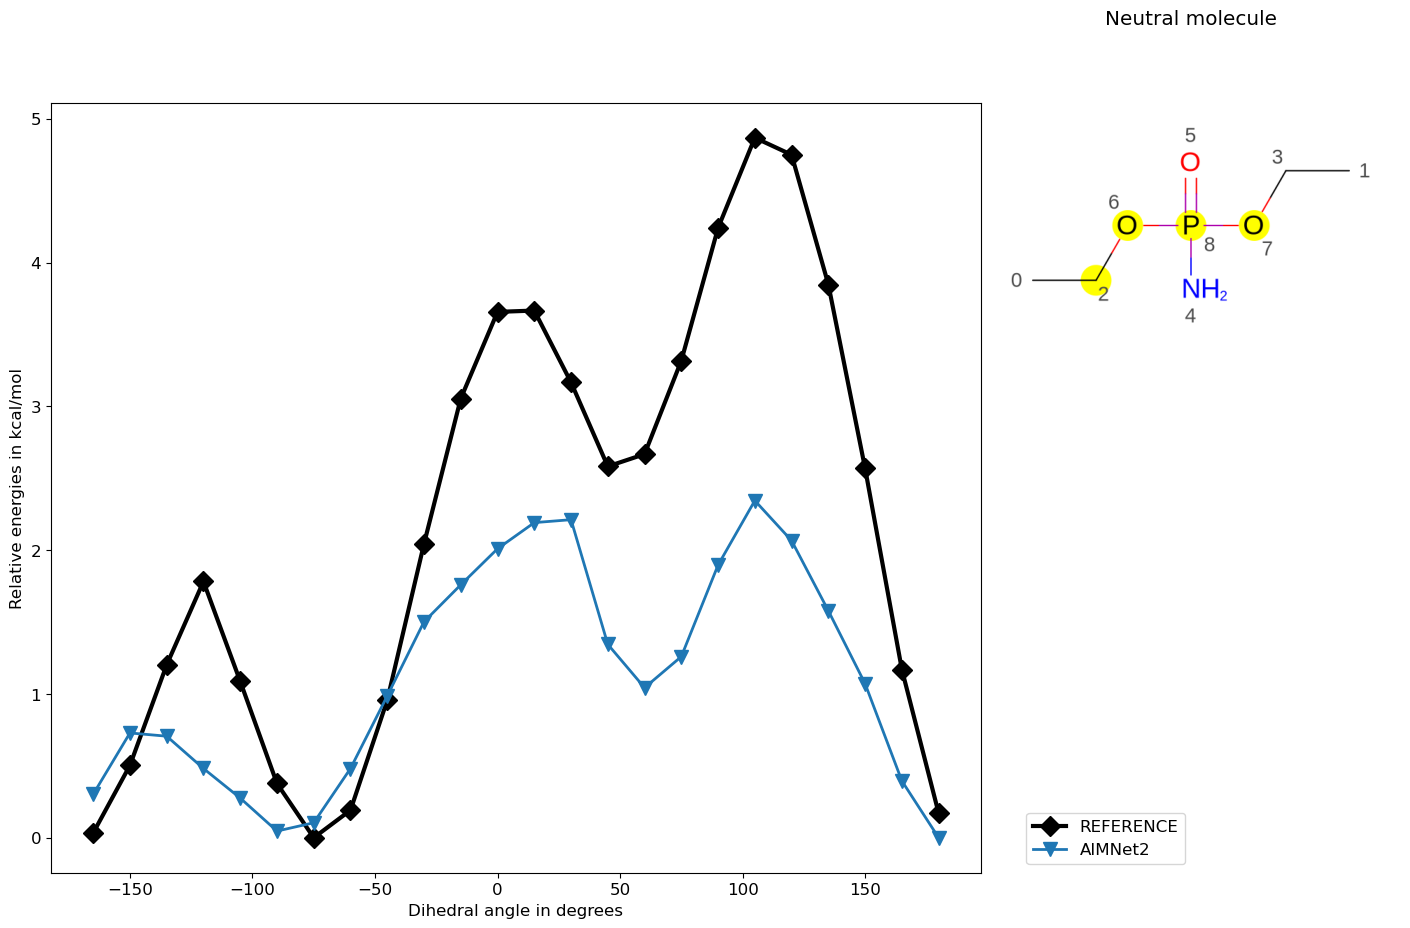

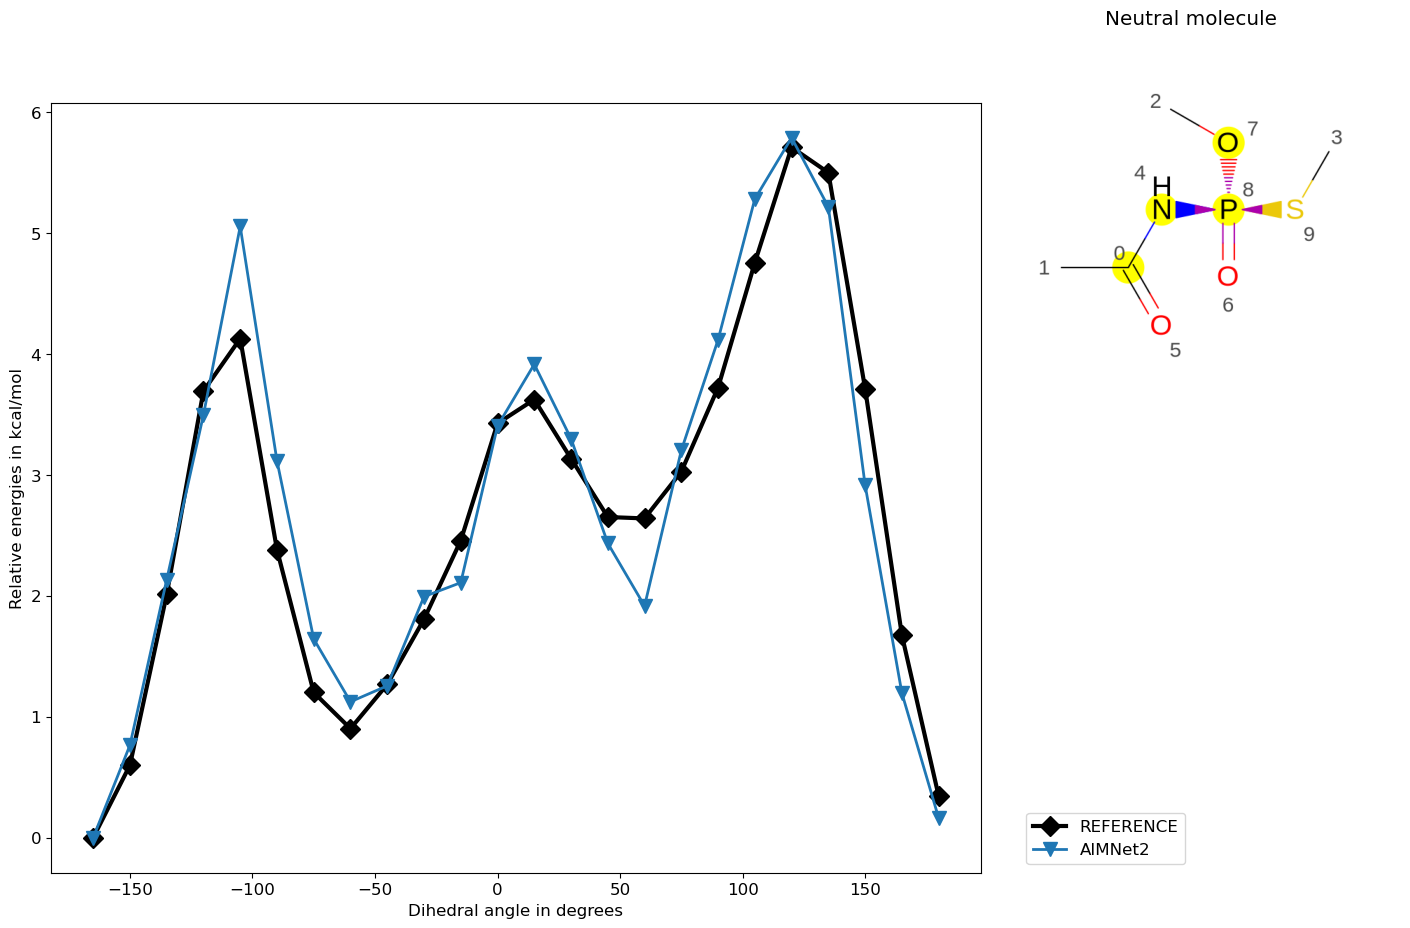

In [5]:
rmse = defaultdict(float)
mae = defaultdict(float)
all_energies = []
neutral_energies = []
charged_energies = []
neutral_ref = []
charged_ref = []
all_ref = []

for i in range(59):
    ref_energies = np.array(get_relative_energies(ref_dict[str(i)]['total energies'], HARTREE_TO_KCALMOL))
    ref_angles = ref_dict[str(i)]['angles']
    mapped_smiles = mp2_data[str(i)]['metadata']['mapped_smiles']
    dihedrals = mp2_data[str(i)]['metadata']['dihedral scanned'][0]
    mol_charge = mp2_data[str(i)]['metadata']['mol_charge']
    offmol = Molecule.from_mapped_smiles(mapped_smiles)
    flag_neutral = True
    if mol_charge != 0:
        flag_neutral = False
    elif mol_charge == 0  and mapped_smiles.find('+') != -1:
        flag_neutral = False
    
    all_ref.extend(ref_energies)
    if flag_neutral:
        neutral_ref.extend(ref_energies)
    else:
        charged_ref.extend(ref_energies)
        
    fig, ax = plt.subplots(figsize=[12, 10])
    ax.plot(
            ref_angles,
            ref_energies,
            "-D",
            label="REFERENCE",
            linewidth=3.0,
            c="k",
            markersize=10,
        )
    aimnet2_energies = []
    numbers = [atom.atomic_number for atom in offmol.atoms]
    for j in range(24):
        coord = np.array(mp2_data[str(i)]['final_geometries'][j]) * 0.529177
        atoms = ase.Atoms(positions=coord, numbers=numbers)
        calc.do_reset()
        calc.set_charge(mol_charge)
        atoms.set_calculator(calc)
        aimnet2_energies.append(calc.get_potential_energy(atoms))

    energies = np.array(get_relative_energies(aimnet2_energies, eV_to_kcalmol_conversion_factor))
    all_energies.extend(energies)
    if flag_neutral:
        neutral_energies.extend(energies)
    else:
        charged_energies.extend(energies)
    
    rmse_energies = np.sqrt(np.mean((energies - ref_energies) ** 2))
    mae_energies = np.mean(np.abs(energies - ref_energies))
    rmse[i] = rmse_energies
    mae[i] = mae_energies
    ax.plot(
            ref_angles,
            energies,
            "-v",
            label='AIMNet2',
            linewidth=2.0,
            markersize=10,
        )
        
    
    plt.xlabel(
        "Dihedral angle in degrees",
    )
    plt.ylabel("Relative energies in kcal/mol")
    
    plt.legend(loc="lower left", bbox_to_anchor=(1.04, 0), fontsize=12)
    oemol = offmol.to_openeye()
    image = show_oemol_struc(
        oemol, torsions=True, atom_indices=dihedrals, width=600, height=500
    )
    img = Image.open(io.BytesIO(image.data))
    im_arr = np.asarray(img)
    newax = fig.add_axes([0.9, 0.6, 0.35, 0.35], anchor="SW", zorder=-1)
    newax.imshow(im_arr)
    newax.axis("off")
    if flag_neutral:
        plt.title('Neutral molecule')
    else:
        plt.title('Charged molecule')
    plt.show()
    pdf.savefig(fig, dpi=600, bbox_inches="tight")

In [7]:
table = []
all_ref = np.array(all_ref)
method_energies = np.array(all_energies)
rmse_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='RMSE')
mue_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='MUE')   
neutral_stats = bootstrap_statistic(y_true=neutral_ref, y_pred=np.array(neutral_energies), statistic='RMSE')
charged_stats = bootstrap_statistic(y_true=charged_ref, y_pred=np.array(charged_energies), statistic='RMSE')
lt_five_rmse_stats = bootstrap_statistic(y_true=all_ref[np.abs(all_ref) < 5], y_pred=method_energies[np.abs(all_ref) < 5], statistic='RMSE')
lt_five_mue_stats = bootstrap_statistic(y_true=all_ref[np.abs(all_ref) < 5], y_pred=method_energies[np.abs(all_ref) < 5], statistic='MUE')
table.append(['AIMNet2',
              "%.4f" % rmse_stats['mle'],"%.4f" % rmse_stats['low'],"%.4f" % rmse_stats['high'],
              "%.4f" % mue_stats['mle'],"%.4f" % mue_stats['low'],"%.4f" % mue_stats['high'],
              "%.4f" % neutral_stats['mle'],"%.4f" % neutral_stats['low'],"%.4f" % neutral_stats['high'],
              "%.4f" % charged_stats['mle'],"%.4f" % charged_stats['low'],"%.4f" % charged_stats['high'],
              "%.4f" % lt_five_rmse_stats['mle'],"%.4f" % lt_five_rmse_stats['low'],"%.4f" % lt_five_rmse_stats['high']])

In [8]:
pdf.close()

print(
    tabulate(
        table,
        headers=["Specification", 
                 "RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "MAE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Neutral RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Charged RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "lt_five_RMSE in kcal/mol", "low 95% ci", "high 95% ci"],
        tablefmt="orgtbl",
    )
)
print("* closer to zero the better")

| Specification   |   RMSE in kcal/mol |   low 95% ci |   high 95% ci |   MAE in kcal/mol |   low 95% ci |   high 95% ci |   Neutral RMSE in kcal/mol |   low 95% ci |   high 95% ci |   Charged RMSE in kcal/mol |   low 95% ci |   high 95% ci |   lt_five_RMSE in kcal/mol |   low 95% ci |   high 95% ci |
|-----------------+--------------------+--------------+---------------+-------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------|
| AIMNet2         |             0.5518 |       0.5176 |        0.5891 |            0.3812 |        0.362 |        0.4025 |                     0.5737 |       0.5343 |        0.6157 |                     0.5281 |       0.4697 |        0.5877 |                     0.5031 |       0.4662 |        0.5419 |
* closer to zero the better


In [9]:
# For latex table entries
print("RMSE Neutral Charged")
for item in table:
    print(
        f"{item[0].upper()} & ${{{item[1]}}}^{{{item[2]}}}_{{{item[3]}"
        f"}}$ & ${{{item[7]}}}^{{{item[8]}}}_{{{item[9]}}}$ & ${{{item[10]}}}^{{{item[11]}}}_{{{item[12]}}}$\\\\ \\vspace{{2mm}}")

RMSE Neutral Charged
AIMNET2 & ${0.5518}^{0.5176}_{0.5891}$ & ${0.5737}^{0.5343}_{0.6157}$ & ${0.5281}^{0.4697}_{0.5877}$\\ \vspace{2mm}


In [10]:
energies_dict = defaultdict(list)
for i in range(59):
    energies_dict[i] = all_energies[i*24:(i+1)*24]
with open('../data/aimnet2_single_points_data.json', 'w') as outfile:
    json.dump(energies_dict, outfile) 